# Análise da comparação contexto e as palavras das sentenças do SQUAD 2 P(2,5%) pt-br 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do SQUAD2 P(2,5%) pt-br utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-13 23:21:56,646 : INFO : NumExpr defaulting to 2 threads.
2022-07-13 23:21:57,357 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-13 23:22:01,276 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-13 23:22:01,370 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-13 23:22:01,383 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-13 23:22:01,394 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.8 MB/s 
     |████████████████████████████████| 146 kB 40.3 MB/s 
     |████████████████████████████████| 181 kB 38.0 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0204355a0f57ab4fd3068a050eeb5f3d973a682702861db6c48b8c3cdbed8aad
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 20

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 20

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-13 23:22:37,151 : INFO : Diretório criado: /content/SQUAD2_P


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-07-13 23:22:38,814 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-07-13 23:22:39,342 : INFO : Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-13 23:22:39,397 : INFO : TERMINADO ORIGINAIS: 1419.
2022-07-13 23:22:39,401 : INFO : TERMINADO ORIGINAIS POS: 1419.


In [ ]:
lista_documentos_originais.sample(5)

id  \
978  56db3337e7c41114004b4f32   
664  56e16960cd28a01900c678a6   
272  5a53e21dbdaabd001a3867b6   
736  57270e2b708984140094d90f   
963  5a85c17db4e223001a8e71f7   

                                             sentencas  \
978  ['Que atriz se retirou da participação no reve...   
664   ['Qual foi o orçamento do filme Love Actually?']   
272  ['De que igreja a Igreja Apostólica Armênia se...   
736  ['Qual a quantidade de energia que um capacito...   
963  ['Por que os humanos consideram desnecessárias...   

                                             documento  respondivel  
978  Que atriz se retirou da participação no reveza...            1  
664       Qual foi o orçamento do filme Love Actually?            1  
272  De que igreja a Igreja Apostólica Armênia se s...            0  
736  Qual a quantidade de energia que um capacitor ...            1  
963  Por que os humanos consideram desnecessárias t...            0

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id  \
410   573415824776f41900661826   
542   56ddd58e66d3e219004dad0d   
1013  56de0b054396321400ee256d   
187   5733a70c4776f41900660f64   
1415  570614ff52bb89140068988e   

                                          pos_documento  
410   [[['No', 'final', 'de', '2006', ',', 'que', 'p...  
542   [[['Qual', 'escritório', 'de', 'advocacia', 'u...  
1013  [[['Quantos', 'institutos', 'politécnicos', 'a...  
187   [[['Que', 'entidade', 'fornece', 'ajuda', 'com...  
1415  [[['As', 'duas', 'equipes', 'listadas', 'jogam...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-13 23:22:39,645 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 1419.
2022-07-13 23:22:39,648 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 1419.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                            
5a8d89b5df8bba001a0f9afb  [O formulário Edna do Link é mais rápido do qu...   
5acfa4e977cf76001a6856da  [Quais dois ministros lutaram pelo poder em An...   
5ad19f40645df0001a2d213b  [O que Irving Langmuir descobriu que aumentari...   
56ce66aeaab44d1400b8875a  [Em que ano a célula solar de silício cristali...   
5acdabd307355d001abf48f0  [Desde que ano foi levantada a idéia de um tún...   

                                                                  documento  \
id                                                                            
5a8d89b5df8bba001a0f9afb  O formulário Edna do Link é mais rápido do que...   
5acfa4e977cf76001a6856da   Quais dois ministros lutaram pelo poder em Anne?   
5ad19f40645df0001a2d213b  O que Irving Langmuir descobriu que aumentaria...   
56ce66aeaab44d1400b8875a  Em que ano a célula solar de silício cristalin...   
5acdabd307355d001abf48f0  Desde que ano foi levantada a idéia de um túne...   

                          respondivel  
id                                     
5a8d89b5df8bba001a0f9afb            0  
5acfa4e977cf76001a6856da            0  
5ad19f40645df0001a2d213b            0  
56ce66aeaab44d1400b8875a            1  
5acdabd307355d001abf48f0            0

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[O, formulário, Edna, do, Link, é, mais, ráp...
5acfa4e977cf76001a6856da  [[[Quais, dois, ministros, lutaram, pelo, pode...
5ad19f40645df0001a2d213b  [[[O, que, Irving, Langmuir, descobriu, que, a...
56ce66aeaab44d1400b8875a  [[[Em, que, ano, a, célula, solar, de, silício...
5acdabd307355d001abf48f0  [[[Desde, que, ano, foi, levantada, a, idéia, ...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-13 23:22:40,120 : INFO : TERMINADO PERTURBADOS: 28380.
2022-07-13 23:22:40,123 : INFO : TERMINADO PERTURBADOS POS: 28380.


In [ ]:
lista_documentos_perturbados.sample(5)

id  \
10046   5ad2463dd7d075001a428ae6_pert_6   
17244   572e92b1cb0c0d14000f12db_pert_4   
17213  57064d0675f01819005e7b25_pert_13   
20294  56d138c3e7d4791d0090203a_pert_14   
25672  5acead9532bba1001ae4b00a_pert_12   

                                              perturbado  \
10046  ['Quem conhecia uma ordem em que seus membros ...   
17244  ['Qual foi a maior ameaça para as espécies veg...   
17213                 ['Onde esta o Dr. Carlos Moore ?']   
20294  ['17 de dezembro de 2010 foi o dia em que Kany...   
25672  ['Que idioma constitui o inglês como vernáculo...   

                                     documentoPerturbado  \
10046  Quem conhecia uma ordem em que seus membros ti...   
17244  Qual foi a maior ameaça para as espécies veget...   
17213                     Onde esta o Dr. Carlos Moore ?   
20294  17 de dezembro de 2010 foi o dia em que Kanye ...   
25672  Que idioma constitui o inglês como vernáculo j...   

                                               sentencas  
10046  [['Quem [MASK] uma ordem em que seus membros t...  
17244  [['Qual foi a maior ameaça para as espécies [M...  
17213  [['Onde [MASK] o Dr. Carlos Moore ?', 'trabalh...  
20294  [['17 de dezembro de 2010 foi o dia em que Kan...  
25672  [['Que idioma [MASK] o inglês como vernáculo j...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id  \
26663   56eab6410030b61400a35054_pert_3   
14171  570800b19e06ca38007e94ec_pert_11   
15350  572ff56304bcaa1900d76f2f_pert_10   
4540    57101890b654c5140001f7d6_pert_0   
14430  5ad168ad645df0001a2d1a12_pert_10   

                                           pos_documento  
26663  [[['O', 'que', 'o', 'controle', 'do', 'poder',...  
14171  [[['Que', 'grande', 'separação', ',', 'em', 'u...  
15350  [[['Quanto', 'do', 'fluxo', 'do', 'Reno', 'ao'...  
4540   [[['Que', 'perguntas', 'fazem', 'às', 'homosse...  
14430  [[['Que', 'efeitos', 'um', 'rotor', 'sem', 'nú...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-13 23:22:44,370 : INFO : TERMINADO CORREÇÃO PERTURBADO: 28380.
2022-07-13 23:22:44,374 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 28380.


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  [O form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_1  [O Form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_2  [O Can Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_3  [O da Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_4  [O Cada Edna do Link é mais rápido do que outr...   

                                                               documentoPerturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  O form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_1  O Form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_2  O Can Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_3  O da Edna do Link é mais rápido do que outro f...   
5a8d89b5df8bba001a0f9afb_pert_4  O Cada Edna do Link é mais rápido do que outro...   

                                                                         sentencas  
id                                                                                  
5a8d89b5df8bba001a0f9afb_pert_0  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_1  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_2  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_3  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_4  [[O [MASK] Edna do Link é mais rápido do que o...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                
5a8d89b5df8bba001a0f9afb_pert_0  [[[O, form, Edna, do, Link, é, mais, rápido, d...
5a8d89b5df8bba001a0f9afb_pert_1  [[[O, Form, Edna, do, Link, é, mais, rápido, d...
5a8d89b5df8bba001a0f9afb_pert_2  [[[O, Can, Edna, do, Link, é, mais, rápido, do...
5a8d89b5df8bba001a0f9afb_pert_3  [[[O, da, Edna, do, Link, é, mais, rápido, do,...
5a8d89b5df8bba001a0f9afb_pert_4  [[[O, Cada, Edna, do, Link, é, mais, rápido, d...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 1419 documentos originais


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

2022-07-13 23:22:50,006 : INFO : TERMINADO AGRUPAMENTO: 29799.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

2022-07-13 23:22:50,154 : INFO : TERMINADO AGRUPAMENTO: 29799.


In [ ]:
lista_documentos_agrupados.sample(5)

id  \
11614   5705fc5b75f01819005e7833_pert_0   
28134  572e7c43cb0c0d14000f11aa_pert_14   
27020  5ad4f0d05b96ef001a10a6f3_pert_13   
4949   572f5f7a947a6a140053c8d0_pert_13   
28770          56db3994e7c41114004b4f6f   

                                               sentencas  \
11614              [Como os pássaros produzem energia ?]   
28134      [Chipre é um espaço insular ou sem litoral ?]   
27020  [Que pessoas proeminentes não vestem vermelho ...   
4949         [Onde a ferrovia de Bagdá ia se conectar ?]   
28770  [Quem disse que milhares de apoiadores pró-Peq...   

                                               documento  classe  
11614                Como os pássaros produzem energia ?       0  
28134        Chipre é um espaço insular ou sem litoral ?       0  
27020  Que pessoas proeminentes não vestem vermelho p...       0  
4949           Onde a ferrovia de Bagdá ia se conectar ?       0  
28770  Quem disse que milhares de apoiadores pró-Pequ...       1

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

2022-07-13 23:22:50,250 : INFO : TERMINADO AGRUPAMENTO POS: 29799.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

id  \
11173  5a3c0860cc5d22001a521d55_pert_13   
20378  572a0ce11d046914007796fe_pert_18   
877            5ad232d0d7d075001a428776   
20033  570cba0cb3d812140066d25b_pert_13   
17879  57268c14dd62a815002e891f_pert_19   

                                           pos_documento  
11173  [[[Quem, deverá, ser, competente, em, governar...  
20378  [[[Que, bactéria, alimentar, é, um, produto, d...  
877    [[[O, que, foi, fácil, para, Popper, lidar, co...  
20033  [[[De, qual, país, o, lápis-lazúli, foi, tradu...  
17879  [[[Quais, dois, países, aconteceram, revoltas,...

#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = lista_documentos_agrupados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                   
5a8d89b5df8bba001a0f9afb         [O formulário Edna do Link é mais rápido do qu...   
5a8d89b5df8bba001a0f9afb_pert_0  [O form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_1  [O Form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_2  [O Can Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_3  [O da Edna do Link é mais rápido do que outro ...   

                                                                         documento  \
id                                                                                   
5a8d89b5df8bba001a0f9afb         O formulário Edna do Link é mais rápido do que...   
5a8d89b5df8bba001a0f9afb_pert_0  O form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_1  O Form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_2  O Can Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_3  O da Edna do Link é mais rápido do que outro f...   

                                 classe  
id                                       
5a8d89b5df8bba001a0f9afb              1  
5a8d89b5df8bba001a0f9afb_pert_0       0  
5a8d89b5df8bba001a0f9afb_pert_1       0  
5a8d89b5df8bba001a0f9afb_pert_2       0  
5a8d89b5df8bba001a0f9afb_pert_3       0

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[O, formulário, Edna, do, Link, é, mais, ráp...
5acfa4e977cf76001a6856da  [[[Quais, dois, ministros, lutaram, pelo, pode...
5ad19f40645df0001a2d213b  [[[O, que, Irving, Langmuir, descobriu, que, a...
56ce66aeaab44d1400b8875a  [[[Em, que, ano, a, célula, solar, de, silício...
5acdabd307355d001abf48f0  [[[Desde, que, ano, foi, levantada, a, idéia, ...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-13 23:22:50,532 : INFO : Diretório já existe: /content/SQUAD2_P


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

2022-07-13 23:22:51,674 : INFO : Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

2022-07-13 23:22:54,782 : INFO : Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

2022-07-13 23:23:02,455 : INFO : TERMINADO ORIGINAIS: 340095.


In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  \
208141   572e92b1cb0c0d14000f12db_pert_2            18105               0   
321298  5a284cb7d1a287001a6d0b24_pert_10            28235               0   
271924   5acfa1d377cf76001a68560d_pert_7            23906               0   
49705   56f81eceaef2371900625de5_pert_11             4212               0   
169180  5ace7ee632bba1001ae4a82d_pert_11            14733               0   

        index_wi         wi  pos_i  cos_ctxall_mean  euc_ctxall_mean  \
208141         1        foi    AUX         0.865894        19.388903   
321298         4   Conselho  PROPN         0.838991        20.292395   
271924         7   expandir   VERB         0.833668        21.591169   
49705          4     viajou   VERB         0.743399        27.998566   
169180         1  extensões   NOUN         0.871305        18.719719   

        man_ctxall_mean  cos_ctxclean_mean  ...  man_ctxclean_max  \
208141        936.30493           0.734779  ...        1262.66480   
321298        941.24457           0.771723  ...        1107.04660   
271924       1027.93480           0.881882  ...         892.95935   
49705        1334.34250           0.767054  ...        1292.96340   
169180        904.75330           0.885365  ...        1075.69650   

        cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  \
208141         1.000000         0.000000         0.000000         0.665092   
321298         0.675693        30.595516      1443.752686              NaN   
271924         0.919493        15.368957       749.961670         0.744944   
49705          0.919853        16.383505       797.079712         0.693874   
169180         0.679365        32.914047      1590.581299         0.838482   

        euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
208141        29.878588      1414.795776             0.856972   
321298              NaN              NaN             0.675693   
271924        27.034367      1281.687988             0.907219   
49705         30.457436      1476.677490             0.792848   
169180        21.951542      1048.107056             0.832376   

        euc_ctxverbnoun_max  man_ctxverbnoun_max  
208141            19.919058           943.197266  
321298            30.595516          1443.752686  
271924            16.504854           792.907776  
49705             25.452415          1231.937744  
169180            22.321192          1070.076416  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  \
54881   572409ef0ba9f01400d97b44_pert_6             4690               0   
118801  572ebe14cb0c0d14000f14f0_pert_4            10379               0   
13046          5ad3c82a604f3c001a3ff066             1071               0   
308633  5ad17f87645df0001a2d1e58_pert_0            27112               0   
103759  56e02cb57aa994140058e2f9_pert_5             8931               0   

        index_wi         wi  pos_i  cos_ctxall_mean  euc_ctxall_mean  \
54881          8          ?  PUNCT         0.834971        20.207533   
118801         7  significa   VERB         0.803197        32.229874   
13046          5        não    ADV         0.829154        23.631771   
308633         3  biografia   NOUN         0.785211        23.964592   
103759         4       ilha   NOUN         0.756102        24.307180   

        man_ctxall_mean  cos_ctxclean_mean  ...  man_ctxclean_max  \
54881         1011.6625           0.824024  ...         1023.3826   
118801        1459.7517           0.826952  ...         1392.4141   
13046         1113.7039           0.776111  ...         1241.0264   
308633        1137.0496           0.825664  ...         1042.2192   
103759        1122.2509           0.797388  ...         1027.1593   

        cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  \
54881          0.750027        26.160776      1308.864990         0.635569   
118801         0.932199        19.197977       935.814087         0.759108   
13046          0.737022        28.769608      1375.763306         0.621346   
308633         0.648879        31.311110      1475.437744         0.909663   
103759         0.550135        37.993622      1776.401733         0.827131   

        euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
54881         31.102543      1509.954102             0.720388   
118801        34.100067      1606.797485             0.890544   
13046         34.953907      1651.044434             0.730607   
308633        16.125648       747.178223             0.852736   
103759        20.759417       945.793213             0.808147   

        euc_ctxverbnoun_max  man_ctxverbnoun_max  
54881             26.593311          1301.102783  
118801            24.435184          1166.853882  
13046             28.813709          1358.052246  
308633            20.256491           956.908569  
103759            21.783768           988.496094  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Faz uma cópia da lista não indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_comparacao_contexto_indexado.set_index(["id", "index_sentenca", "index_wi", "pos_i"], inplace=True)
lista_comparacao_contexto_indexado.head()

index_documento  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        DET                  0   
                                        1        NOUN                 0   
                                        2        PROPN                0   
                                        3        ADP                  0   
                                        4        PROPN                0   

                                                                wi  \
id                       index_sentenca index_wi pos_i               
5a8d89b5df8bba001a0f9afb 0              0        DET             O   
                                        1        NOUN   formulário   
                                        2        PROPN        Edna   
                                        3        ADP            do   
                                        4        PROPN        Link   

                                                        cos_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        DET           0.859250   
                                        1        NOUN          0.905944   
                                        2        PROPN         0.806291   
                                        3        ADP           0.847299   
                                        4        PROPN         0.772715   

                                                        euc_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        DET          19.518106   
                                        1        NOUN         15.706674   
                                        2        PROPN        23.799168   
                                        3        ADP          21.641386   
                                        4        PROPN        31.348534   

                                                        man_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        DET          962.85077   
                                        1        NOUN         764.11290   
                                        2        PROPN       1153.51970   
                                        3        ADP         1052.07900   
                                        4        PROPN       1384.30630   

                                                        cos_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        DET             0.821651   
                                        1        NOUN            0.874748   
                                        2        PROPN           0.833320   
                                        3        ADP             0.831344   
                                        4        PROPN           0.828884   

                                                        euc_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        DET            21.844885   
                                        1        NOUN           17.976768   
                                        2        PROPN          22.240156   
                                        3        ADP            22.575476   
                                        4        PROPN          28.159580   

                                                        man_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        DET           1072.31570   
                                        1        NOUN           858.73596   
                                        2        PROPN         1094.86160

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count   340095.000000   340095.000000   340095.000000  340095.000000   
mean         0.809786       23.147593     1109.294026       0.799864   
std          0.063689        3.799373      164.173175       0.065768   
min          0.123609        9.172180      448.242980       0.123609   
25%          0.784300       20.649336     1001.471255       0.774482   
50%          0.815291       22.823093     1101.795200       0.807668   
75%          0.844283       25.237112     1209.890650       0.837164   
max          0.965054       46.385330     1961.549000       0.936969   

      euc_ctxall_max man_ctxall_max  
count  340095.000000  340095.000000  
mean       23.855613    1144.185559  
std         3.753973     163.365589  
min        12.501791     611.675300  
25%        21.266454    1032.698350  
50%        23.425156    1128.724100  
75%        25.932325    1239.989850  
max        46.385330    2224.240700

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count    29799.000000    29799.000000    29799.000000   29799.000000   
mean         0.726776       28.876608     1329.881595       0.706343   
std          0.138444        4.215226      154.904240       0.136635   
min          0.123609       15.303283      729.124500       0.123609   
25%          0.726391       25.819633     1224.805700       0.696547   
50%          0.760742       28.405247     1322.920000       0.738760   
75%          0.788350       31.548376     1428.610050       0.773420   
max          0.906775       46.385330     1961.549000       0.906775   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count   29799.000000    29799.00000  
mean       29.551680     1375.43653  
std         4.162910      177.92457  
min        15.303283      729.12450  
25%        26.592832     1256.42555  
50%        29.246595     1361.47310  
75%        32.274279     1480.88565  
max        46.385330     2224.24070

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/29799 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 29633
2 de 15372
3 que 11796
4 o 10112
5 a 9257
6 do 5096
7 em 4949
8 da 4926
9 é 4721
10 Qual 4523
11 O 4204
12 os 3842
13 foi 3680
14 Que 3554
15 para 2940
16 e 2760
17 Quem 2608
18 , 2571
19 um 2444
20 Em 2310


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count     340095.000000     340095.000000     340095.000000    340095.000000   
mean           0.789919         24.226210       1158.243978         0.780062   
std            0.071891          3.652454        169.817091         0.074095   
min            0.091714          0.000000          0.000000         0.091714   
25%            0.756935         21.802636       1041.825350         0.746819   
50%            0.797100         24.075121       1155.564500         0.787803   
75%            0.833007         26.410422       1268.977950         0.824966   
max            1.000000         47.041553       2145.623500         1.000000   

      euc_ctxclean_max man_ctxclean_max  
count    340095.000000    340095.000000  
mean         24.908069      1191.354374  
std           3.648706       169.945851  
min           0.000000         0.000000  
25%          22.445575      1076.591300  
50%          24.656116      1183.699500  
75%          27.008127      1295.178000  
max          47.041553      2245.952600

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count      29799.000000      29799.000000      29799.000000     29799.000000   
mean           0.686909         29.382019       1387.290131         0.666160   
std            0.141675          3.864966        146.255799         0.138816   
min            0.091714         17.288593        860.083070         0.091714   
25%            0.681924         26.686961       1288.347600         0.657012   
50%            0.720719         28.806044       1376.984100         0.698418   
75%            0.751427         31.476672       1478.541850         0.733301   
max            0.881714         47.041553       2145.623500         0.869385   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count     29799.000000     29799.000000  
mean         30.335113      1436.385287  
std           3.840058       166.191734  
min          18.656073       902.962650  
25%          27.607383      1323.750550  
50%          29.895153      1419.541100  
75%          32.537281      1531.098350  
max          47.041553      2245.952600

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/29799 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 29633
2 de 15372
3 que 11796
4 o 10112
5 a 9257
6 do 5096
7 em 4949
8 da 4926
9 é 4721
10 Qual 4523
11 O 4204
12 os 3842
13 foi 3680
14 Que 3554
15 para 2940
16 e 2760
17 Quem 2608
18 , 2571
19 um 2444
20 Em 2310


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count    331912.000000    331912.000000    331912.000000   331912.000000   
mean          0.700006        29.674597      1419.602261        0.692011   
std           0.127552         9.331478       435.689519        0.132714   
min           0.035415         0.000000         0.000000        0.035415   
25%           0.624257        27.036452      1315.383362        0.613372   
50%           0.686261        31.303370      1507.000000        0.681156   
75%           0.752709        35.207200      1678.912323        0.750148   
max           1.000000        62.451836      2418.588623        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count   331912.000000   331912.000000  
mean        30.174545     1443.203088  
std          9.542134      445.342536  
min          0.000000        0.000000  
25%         27.249225     1326.963013  
50%         31.743555     1526.587952  
75%         35.897658     1709.629364  
max         62.451836     2609.769287

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count     28954.000000     28954.000000     28954.000000    28954.000000   
mean          0.556355        37.295313      1746.659854        0.526154   
std           0.132484         4.813394       195.254832        0.129274   
min           0.035415        23.325924      1126.848022        0.035415   
25%           0.526022        33.901908      1612.225525        0.487926   
50%           0.582522        36.908403      1736.765625        0.547514   
75%           0.631959        40.444599      1879.375916        0.602677   
max           0.791451        62.451836      2418.588623        0.791451   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count    28954.000000    28954.000000  
mean        38.718330     1814.835501  
std          4.832458      210.344428  
min         23.325924     1126.848022  
25%         35.339045     1665.824951  
50%         38.515408     1809.421631  
75%         41.948651     1954.719696  
max         62.451836     2609.769287

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/29799 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 29633
2 de 15372
3 que 11796
4 o 10112
5 a 9257
6 do 5096
7 em 4949
8 da 4926
9 é 4721
10 Qual 4523
11 O 4204
12 os 3842
13 foi 3680
14 Que 3554
15 para 2940
16 e 2760
17 Quem 2608
18 , 2571
19 um 2444
20 Em 2310


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count    324048.000000    324048.000000    324048.000000   324048.000000   
mean          0.722569        27.761247      1322.220621        0.714011   
std           0.111869         7.129056       336.516919        0.113589   
min           0.069511         0.000000         0.000000        0.069511   
25%           0.655730        25.139366      1204.383514        0.647753   
50%           0.710517        28.842566      1383.303833        0.704677   
75%           0.777302        31.894205      1525.053253        0.769681   
max           1.000000        54.870331      2405.960449        1.000000   

      euc_ctxnoun_max man_ctxnoun_max  
count   324048.000000   324048.000000  
mean        28.360421     1351.437228  
std          7.044752      332.423615  
min          0.000000        0.000000  
25%         25.660860     1231.443176  
50%         29.228889     1401.512573  
75%         32.421236     1548.919067  
max         56.903202     2523.168213

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count     27734.000000     27734.000000     27734.000000    27734.000000   
mean          0.584880        35.288554      1653.892862        0.565278   
std           0.126566         4.260116       164.046545        0.126021   
min           0.069511        23.841101      1136.175537        0.069511   
25%           0.565451        32.076857      1532.371460        0.538568   
50%           0.614425        34.683594      1634.475098        0.594214   
75%           0.653528        38.000524      1760.567139        0.638953   
max           0.776291        54.870331      2405.960449        0.768288   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count    27734.000000    27734.000000  
mean        36.199662     1699.612210  
std          4.357156      182.787775  
min         25.184208     1204.628784  
25%         32.946217     1564.717407  
50%         35.810059     1679.625366  
75%         38.976355     1817.161987  
max         56.903202     2523.168213

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/29799 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 29633
2 de 15372
3 que 11796
4 o 10112
5 a 9257
6 do 5096
7 em 4949
8 da 4926
9 é 4721
10 Qual 4523
11 O 4204
12 os 3842
13 foi 3680
14 Que 3554
15 para 2940
16 e 2760
17 Quem 2608
18 , 2571
19 um 2444
20 Em 2310


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count        339469.000000        339469.000000        339469.000000   
mean              0.764602            25.640929          1224.678101   
std               0.093543             5.079661           235.616019   
min               0.064910             0.000000             0.000000   
25%               0.712676            22.527838          1075.542725   
50%               0.763456            25.897774          1247.447388   
75%               0.828851            28.674824          1377.537842   
max               1.000000            56.015049          2418.588623   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count       339469.000000       339469.000000       339469.000000  
mean             0.755558           26.234810         1253.304524  
std              0.099241            5.345338          248.489716  
min              0.064910            0.000000            0.000000  
25%              0.703379           23.010130         1101.235962  
50%              0.756941           26.304796         1267.959717  
75%              0.822912           29.275644         1404.048828  
max              1.000000           56.015049         2444.037109

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count         29713.000000         29713.000000         29713.000000   
mean              0.634823            32.111556          1506.528948   
std               0.137070             4.273558           157.876237   
min               0.064910            21.228088          1034.589600   
25%               0.621562            29.075106          1397.491333   
50%               0.668421            31.415257          1490.156738   
75%               0.705097            34.458836          1598.634033   
max               0.819148            56.015049          2418.588623   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count        29713.000000        29713.000000        29713.000000  
mean             0.605970           33.561675         1576.456699  
std              0.137254            4.484056          193.025240  
min              0.064910           21.228088         1034.589600  
25%              0.574763           30.235628         1440.018921  
50%              0.638322           33.163887         1551.975098  
75%              0.685744           36.549168         1698.708984  
max              0.819148           56.015049         2444.037109

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/29799 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 29633
2 de 15372
3 que 11796
4 o 10112
5 a 9257
6 do 5096
7 em 4949
8 da 4926
9 é 4721
10 Qual 4523
11 O 4204
12 os 3842
13 foi 3680
14 Que 3554
15 para 2940
16 e 2760
17 Quem 2608
18 , 2571
19 um 2444
20 Em 2310


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20383.000000 0.806776 0.046407 0.644606 0.776397 0.806943 0.835424   
ADP   52238.000000 0.814976 0.042357 0.595752 0.789827 0.819588 0.845205   
ADV   10296.000000 0.803791 0.047021 0.602720 0.778837 0.808125 0.835204   
AUX   15843.000000 0.847100 0.032987 0.663923 0.828060 0.849704 0.870113   
CCONJ  3213.000000 0.462961 0.298256 0.123609 0.193278 0.246911 0.797733   
DET   41284.000000 0.836473 0.039698 0.635535 0.810963 0.841385 0.865226   
INTJ     30.000000 0.854505 0.035210 0.748292 0.858587 0.867611 0.876089   
NOUN  67194.000000 0.800422 0.043708 0.574900 0.775372 0.802012 0.827633   
NUM    4482.000000 0.777009 0.053994 0.628236 0.741875 0.772842 0.811186   
PRON  22978.000000 0.817339 0.037429 0.654361 0.792553 0.819279 0.843997   
PROPN 31801.000000 0.804336 0.060761 0.589256 0.760977 0.802586 0.848408   
PUNCT 33654.000000 0.817964 0.036333 0.567105 0.796270 0.820561 0.842952   
SCONJ  7705.000000 0.804616 0.038796 0.653748 0.781032 0.806846 0.832932   
SYM     127.000000 0.750986 0.031454 0.690787 0.720572 0.759323 0.774157   
VERB  28822.000000 0.803526 0.040361 0.588625 0.778519 0.804714 0.830679   
X        45.000000 0.818779 0.021780 0.742248 0.802305 0.817552 0.834310   

           max  
pos_i           
ADJ   0.959933  
ADP   0.928267  
ADV   0.919950  
AUX   0.932916  
CCONJ 0.910548  
DET   0.940439  
INTJ  0.887836  
NOUN  0.958752  
NUM   0.940208  
PRON  0.926414  
PROPN 0.965054  
PUNCT 0.923204  
SCONJ 0.902588  
SYM   0.834843  
VERB  0.947553  
X     0.856765

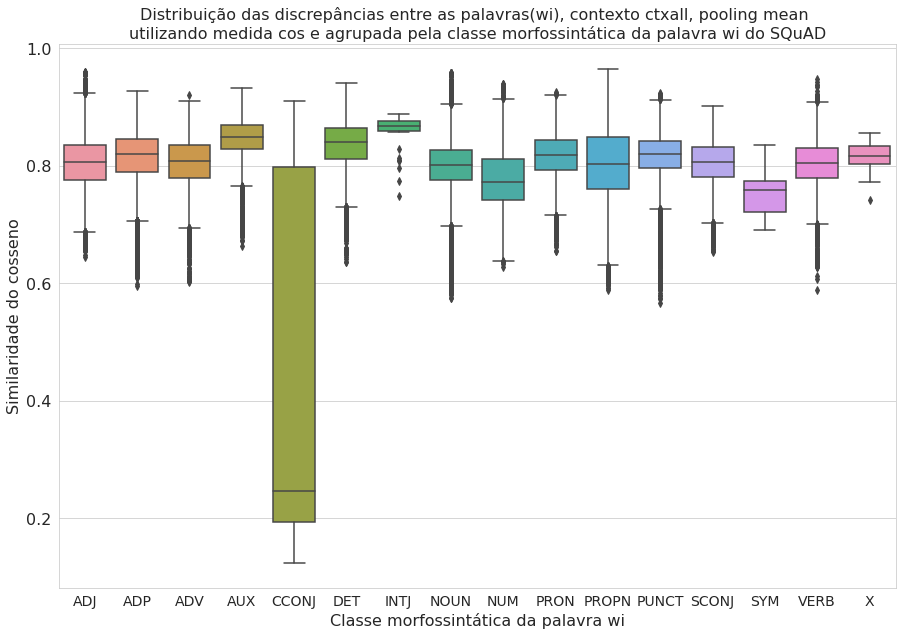

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20383.000000 0.783636 0.046399 0.502812 0.758288 0.789643 0.815994   
ADP   52238.000000 0.814873 0.042388 0.595752 0.789769 0.819539 0.845122   
ADV   10296.000000 0.800779 0.048144 0.509917 0.776170 0.805981 0.832568   
AUX   15843.000000 0.847100 0.032987 0.663923 0.828060 0.849704 0.870113   
CCONJ  3213.000000 0.462961 0.298256 0.123609 0.193278 0.246911 0.797733   
DET   41284.000000 0.833651 0.040974 0.602782 0.806888 0.838772 0.863707   
INTJ     30.000000 0.818662 0.021148 0.748292 0.812629 0.821410 0.827149   
NOUN  67194.000000 0.787078 0.045273 0.523323 0.764000 0.793194 0.818380   
NUM    4482.000000 0.758066 0.052297 0.559132 0.728005 0.758699 0.791539   
PRON  22978.000000 0.815947 0.037803 0.654361 0.791066 0.818202 0.842697   
PROPN 31801.000000 0.755281 0.052514 0.523505 0.723283 0.759075 0.793195   
PUNCT 33654.000000 0.817960 0.036324 0.567105 0.796270 0.820561 0.842952   
SCONJ  7705.000000 0.804026 0.039027 0.653748 0.780636 0.806664 0.832560   
SYM     127.000000 0.750986 0.031454 0.690787 0.720572 0.759323 0.774157   
VERB  28822.000000 0.797706 0.040121 0.588625 0.773984 0.800429 0.825269   
X        45.000000 0.755279 0.035668 0.698809 0.722442 0.769087 0.785142   

           max  
pos_i           
ADJ   0.901771  
ADP   0.928267  
ADV   0.909638  
AUX   0.932916  
CCONJ 0.910548  
DET   0.936969  
INTJ  0.863205  
NOUN  0.912274  
NUM   0.903224  
PRON  0.926414  
PROPN 0.916917  
PUNCT 0.923204  
SCONJ 0.902367  
SYM   0.834843  
VERB  0.919745  
X     0.834129

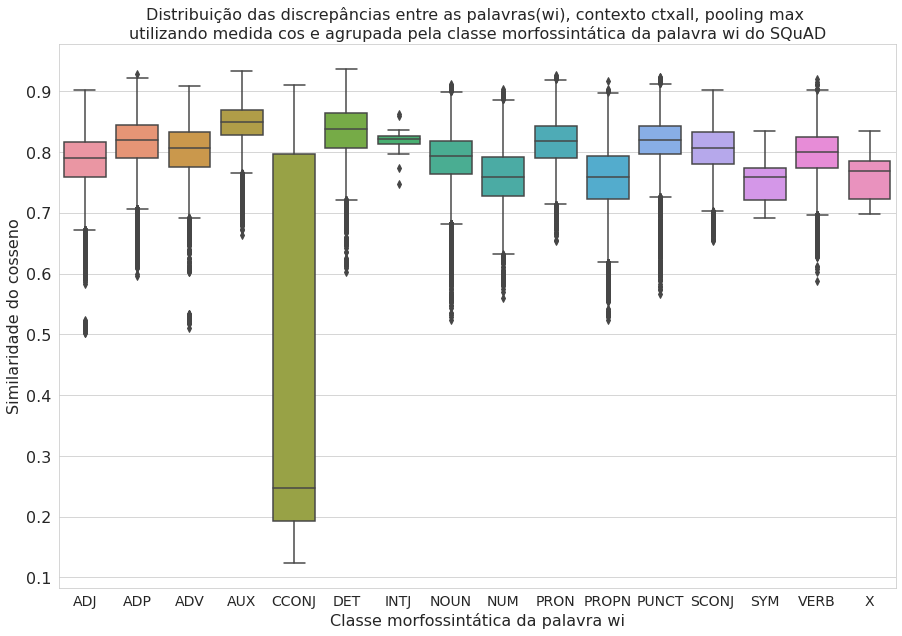

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20383.000000 24.082249 4.353178  9.172180 21.560193 23.970776 26.701731   
ADP   52238.000000 22.850782 2.870425 13.389707 20.874622 22.654317 24.631146   
ADV   10296.000000 25.331577 4.164297 14.238940 22.423481 24.656613 27.802938   
AUX   15843.000000 20.664777 2.573975 13.137630 19.023217 20.466484 21.993328   
CCONJ  3213.000000 30.173497 5.643423 16.619169 24.277632 33.723442 34.969162   
DET   41284.000000 21.089903 2.848805 12.359625 19.048265 20.847254 22.838903   
INTJ     30.000000 22.418025 4.018479 18.055672 20.438106 20.883345 22.284157   
NOUN  67194.000000 23.964285 3.680312 10.079731 21.849502 23.753217 25.909436   
NUM    4482.000000 25.805697 4.476386 11.601833 23.348081 25.993273 28.900959   
PRON  22978.000000 22.526763 2.681414 14.534090 20.751534 22.381326 24.186944   
PROPN 31801.000000 23.162687 4.667349 10.568486 19.956770 23.462679 26.051680   
PUNCT 33654.000000 21.545391 2.174412 13.755169 20.075774 21.489208 22.902702   
SCONJ  7705.000000 23.593904 2.812431 15.302048 21.701403 23.476315 25.167358   
SYM     127.000000 26.916694 1.411573 24.109472 25.757528 27.246630 28.178794   
VERB  28822.000000 25.672197 3.868382 12.059925 23.136622 25.586034 27.960104   
X        45.000000 21.675328 3.361236 19.224360 20.514080 21.192690 21.714134   

            max  
pos_i            
ADJ   43.632034  
ADP   40.753586  
ADV   41.980412  
AUX   39.541492  
CCONJ 37.809742  
DET   38.079781  
INTJ  34.623745  
NOUN  46.167938  
NUM   41.954193  
PRON  41.206821  
PROPN 46.385330  
PUNCT 38.586517  
SCONJ 37.724739  
SYM   29.194403  
VERB  46.314487  
X     40.573982

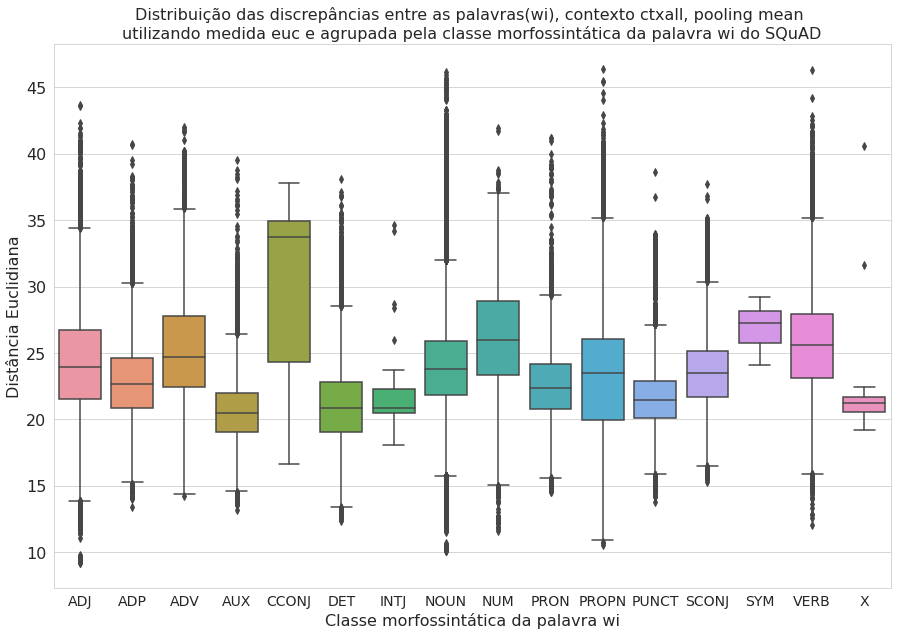

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20383.000000 25.738324 3.479766 16.907627 23.240249 25.237612 27.749339   
ADP   52238.000000 22.858244 2.869197 13.389707 20.883083 22.657211 24.635745   
ADV   10296.000000 25.550914 4.080892 15.387263 22.640911 24.850226 27.966472   
AUX   15843.000000 20.664777 2.573975 13.137630 19.023217 20.466484 21.993328   
CCONJ  3213.000000 30.173497 5.643423 16.619169 24.277632 33.723442 34.969162   
DET   41284.000000 21.292880 2.885261 12.501791 19.181095 21.061783 23.142574   
INTJ     30.000000 24.701492 3.013060 21.496655 23.537295 23.740415 24.359479   
NOUN  67194.000000 24.902088 3.333178 14.963335 22.658449 24.420317 26.670372   
NUM    4482.000000 27.182162 3.778535 15.781477 24.757718 26.982066 29.640566   
PRON  22978.000000 22.629460 2.691123 14.534090 20.842374 22.449286 24.279369   
PROPN 31801.000000 26.667572 3.459547 17.499249 24.347260 26.186781 28.683340   
PUNCT 33654.000000 21.545581 2.174864 13.755169 20.075774 21.489208 22.902702   
SCONJ  7705.000000 23.635841 2.808575 16.073885 21.726290 23.492344 25.190823   
SYM     127.000000 26.916694 1.411573 24.109472 25.757528 27.246630 28.178794   
VERB  28822.000000 26.102668 3.556526 15.788789 23.679472 25.860943 28.198838   
X        45.000000 26.186376 2.899787 21.007139 24.398876 26.594067 27.481270   

            max  
pos_i            
ADJ   43.632034  
ADP   40.753586  
ADV   41.980412  
AUX   39.541492  
CCONJ 37.809742  
DET   38.079781  
INTJ  34.623745  
NOUN  46.167938  
NUM   41.954193  
PRON  41.206821  
PROPN 46.385330  
PUNCT 38.586517  
SCONJ 37.724739  
SYM   29.194403  
VERB  46.314487  
X     40.573982

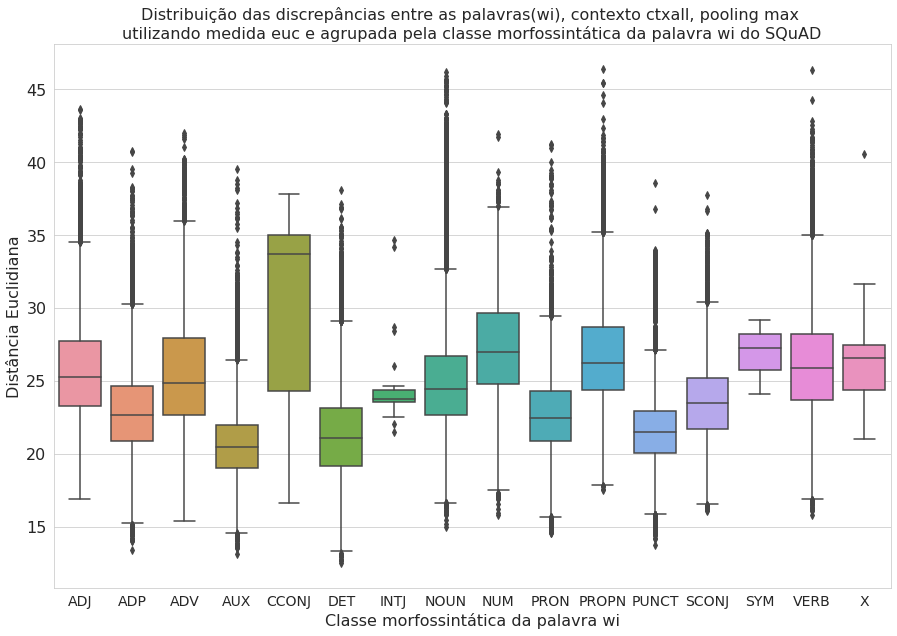

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20383.000000 1131.413532 188.607473  448.242980 1019.752250 1137.014300   
ADP   52238.000000 1122.330266 140.304246  667.694800 1026.256850 1111.968550   
ADV   10296.000000 1212.563296 174.020779  675.652800 1094.650375 1197.168450   
AUX   15843.000000 1002.097966 123.928230  630.887300  920.964800  991.290650   
CCONJ  3213.000000 1133.585263  93.592165  801.715940 1077.295800 1107.440700   
DET   41284.000000 1034.243293 139.152079  605.476260  934.916975 1022.291820   
INTJ     30.000000 1068.329073 129.578268  887.508800  993.262563 1023.041950   
NOUN  67194.000000 1127.249850 162.009393  494.700870 1032.662700 1121.452100   
NUM    4482.000000 1236.014728 202.057800  577.368160 1129.511700 1255.139500   
PRON  22978.000000 1105.592072 132.891837  696.312000 1016.581425 1100.135800   
PROPN 31801.000000 1074.935771 196.309237  510.974240  941.468400 1087.840700   
PUNCT 33654.000000 1061.327735 109.854465  670.702150  986.010075 1058.368700   
SCONJ  7705.000000 1160.159652 140.231079  747.813600 1066.983900 1154.369400   
SYM     127.000000 1308.508537  67.914587 1180.803200 1254.151950 1325.936500   
VERB  28822.000000 1217.896628 163.844155  587.284200 1112.360925 1221.237850   
X        45.000000  995.323250 129.804253  898.906500  956.917400  971.880740   

              75%         max  
pos_i                          
ADJ   1258.837350 1776.136700  
ADP   1210.146550 1931.374500  
ADV   1320.910000 1913.178700  
AUX   1069.051950 1749.553000  
CCONJ 1163.362500 1643.121700  
DET   1119.220500 1742.123000  
INTJ  1080.084900 1415.025600  
NOUN  1222.908850 1941.543000  
NUM   1374.287775 1699.940600  
PRON  1191.118500 1732.075100  
PROPN 1202.382800 1961.549000  
PUNCT 1131.539000 1640.667600  
SCONJ 1236.896900 1809.667500  
SYM   1360.731800 1440.843500  
VERB  1321.684300 1847.138700  
X      991.575440 1653.552700

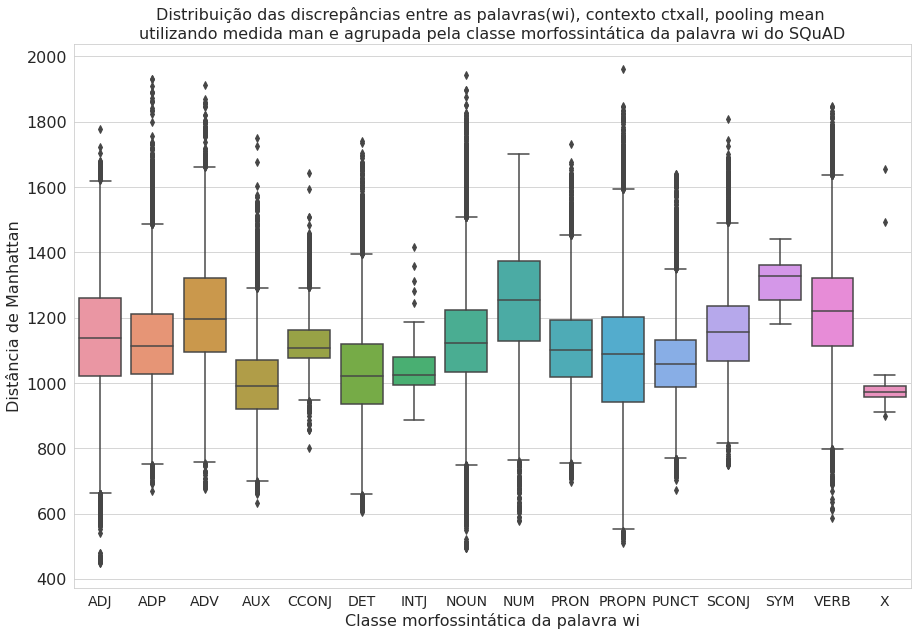

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20383.000000 1212.522955 155.191287  794.167970 1101.134150 1197.933500   
ADP   52238.000000 1122.702430 140.257400  667.694800 1026.505250 1112.123900   
ADV   10296.000000 1223.263011 169.052560  746.965200 1105.658550 1205.026400   
AUX   15843.000000 1002.097966 123.928230  630.887300  920.964800  991.290650   
CCONJ  3213.000000 1133.585263  93.592165  801.715940 1077.295800 1107.440700   
DET   41284.000000 1043.878749 140.451799  611.675300  941.357375 1032.608700   
INTJ     30.000000 1194.518150  74.008771 1046.804100 1171.850025 1181.843900   
NOUN  67194.000000 1172.857262 150.015309  703.497300 1070.294475 1153.070700   
NUM    4482.000000 1304.962469 175.848744  772.108200 1192.109675 1293.410400   
PRON  22978.000000 1109.909383 132.496809  696.312000 1020.931505 1102.768650   
PROPN 31801.000000 1250.229260 172.269952  829.957200 1132.589800 1226.645400   
PUNCT 33654.000000 1061.360556 109.854826  670.702150  986.057593 1058.389100   
SCONJ  7705.000000 1162.381434 140.315802  776.482670 1068.048800 1155.019500   
SYM     127.000000 1308.508537  67.914587 1180.803200 1254.151950 1325.936500   
VERB  28822.000000 1239.004202 150.185957  778.337160 1136.391800 1234.577900   
X        45.000000 1176.124358 105.570232  964.992700 1117.696400 1172.921900   

              75%         max  
pos_i                          
ADJ   1307.460200 2224.240700  
ADP   1210.318275 1931.374500  
ADV   1326.021275 1913.178700  
AUX   1069.051950 1749.553000  
CCONJ 1163.362500 1643.121700  
DET   1132.529000 1742.123000  
INTJ  1207.111125 1415.025600  
NOUN  1256.300300 2191.228500  
NUM   1413.775875 2050.824700  
PRON  1195.027625 1732.075100  
PROPN 1343.315700 2063.592800  
PUNCT 1131.560125 1640.667600  
SCONJ 1237.732900 1809.667500  
SYM   1360.731800 1440.843500  
VERB  1332.568025 1847.138700  
X     1215.872300 1653.552700

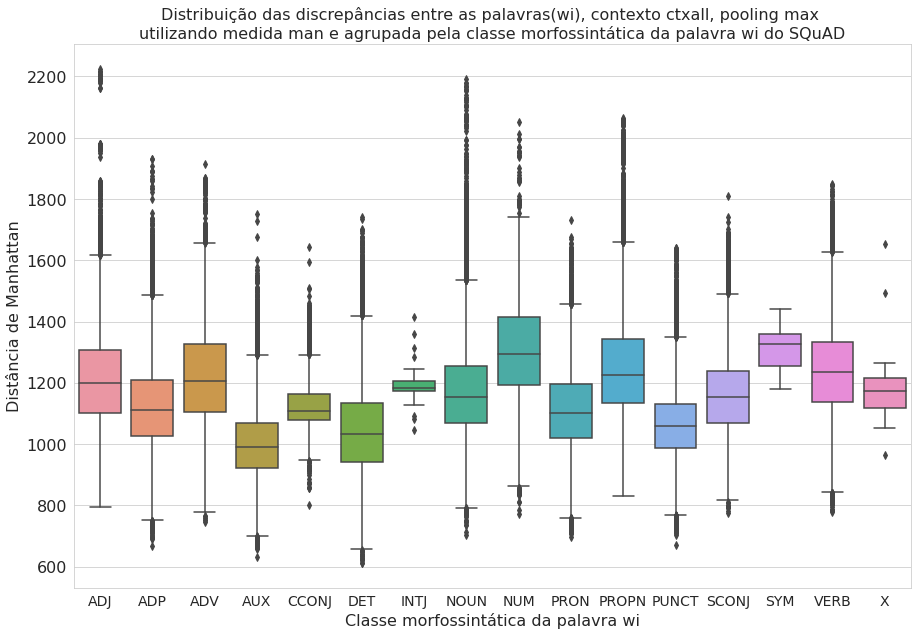

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20383.000000 0.822525 0.049753 0.560665 0.795755 0.829470 0.857998   
ADP   52238.000000 0.756333 0.047996 0.525074 0.727519 0.760804 0.790422   
ADV   10296.000000 0.770628 0.059797 0.574387 0.732813 0.767446 0.811958   
AUX   15843.000000 0.784553 0.043839 0.551211 0.756648 0.784753 0.813772   
CCONJ  3213.000000 0.410918 0.295107 0.091714 0.146291 0.188197 0.738696   
DET   41284.000000 0.778555 0.044700 0.552544 0.750446 0.781775 0.809745   
INTJ     30.000000 0.862024 0.058351 0.722395 0.871975 0.884364 0.895216   
NOUN  67194.000000 0.818249 0.049999 0.506326 0.793167 0.825756 0.853237   
NUM    4482.000000 0.783606 0.048716 0.577502 0.755915 0.787322 0.818422   
PRON  22978.000000 0.749584 0.042795 0.543183 0.722628 0.751540 0.779179   
PROPN 31801.000000 0.816318 0.051072 0.574917 0.786278 0.822867 0.853349   
PUNCT 33654.000000 0.810944 0.041213 0.580682 0.785294 0.812192 0.838150   
SCONJ  7705.000000 0.745054 0.043741 0.566126 0.718130 0.749355 0.774781   
SYM     127.000000 0.776336 0.034492 0.690690 0.755442 0.785008 0.803205   
VERB  28822.000000 0.821501 0.044448 0.517346 0.797168 0.826732 0.852410   
X        45.000000 0.785366 0.023140 0.747688 0.768272 0.784959 0.798442   

           max  
pos_i           
ADJ   0.939648  
ADP   0.908497  
ADV   0.935724  
AUX   0.925113  
CCONJ 0.871489  
DET   0.946615  
INTJ  0.932395  
NOUN  0.946003  
NUM   0.912556  
PRON  0.934621  
PROPN 0.943330  
PUNCT 1.000000  
SCONJ 0.870935  
SYM   0.864027  
VERB  0.936870  
X     0.867728

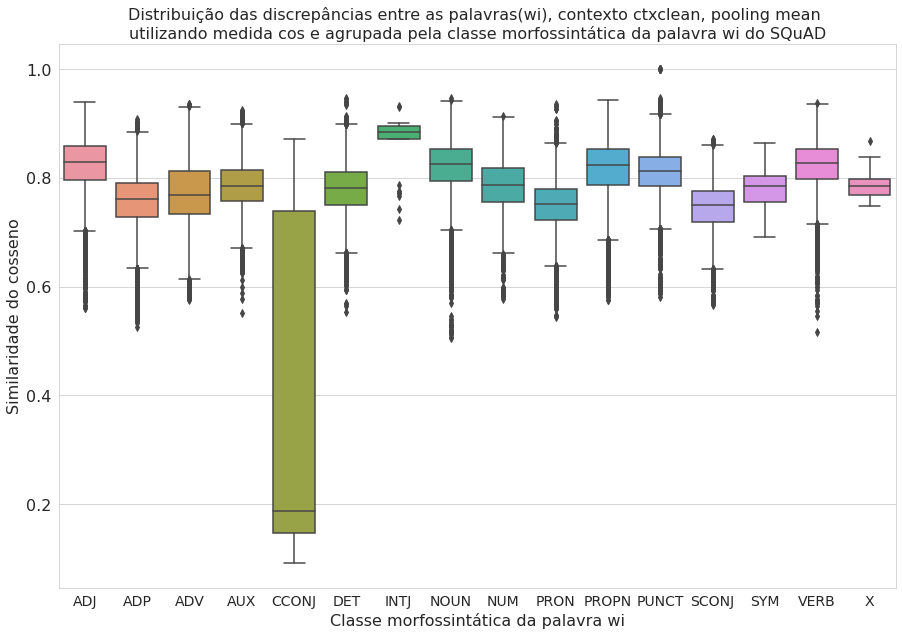

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20383.000000 0.799402 0.062701 0.459425 0.762273 0.810388 0.844050   
ADP   52238.000000 0.756231 0.047961 0.525074 0.727430 0.760764 0.790366   
ADV   10296.000000 0.767617 0.059656 0.480910 0.731490 0.765592 0.807073   
AUX   15843.000000 0.784553 0.043839 0.551211 0.756648 0.784753 0.813772   
CCONJ  3213.000000 0.410918 0.295107 0.091714 0.146291 0.188197 0.738696   
DET   41284.000000 0.775752 0.044310 0.552544 0.747972 0.779696 0.807328   
INTJ     30.000000 0.824452 0.044410 0.722395 0.812180 0.833432 0.839487   
NOUN  67194.000000 0.804930 0.061042 0.455170 0.773738 0.818040 0.848039   
NUM    4482.000000 0.765035 0.057579 0.522174 0.733621 0.772585 0.804922   
PRON  22978.000000 0.748247 0.044216 0.543183 0.721433 0.750895 0.778899   
PROPN 31801.000000 0.767836 0.071522 0.455110 0.722696 0.777627 0.820836   
PUNCT 33654.000000 0.810940 0.041208 0.580682 0.785294 0.812192 0.838150   
SCONJ  7705.000000 0.744476 0.043567 0.566126 0.717882 0.749101 0.774448   
SYM     127.000000 0.776336 0.034492 0.690690 0.755442 0.785008 0.803205   
VERB  28822.000000 0.815614 0.048307 0.517346 0.789171 0.822476 0.849308   
X        45.000000 0.721573 0.046230 0.655359 0.683526 0.733330 0.749268   

           max  
pos_i           
ADJ   0.939648  
ADP   0.896688  
ADV   0.935724  
AUX   0.925113  
CCONJ 0.871489  
DET   0.946615  
INTJ  0.932395  
NOUN  0.946003  
NUM   0.897777  
PRON  0.934621  
PROPN 0.942992  
PUNCT 1.000000  
SCONJ 0.865313  
SYM   0.864027  
VERB  0.934306  
X     0.867728

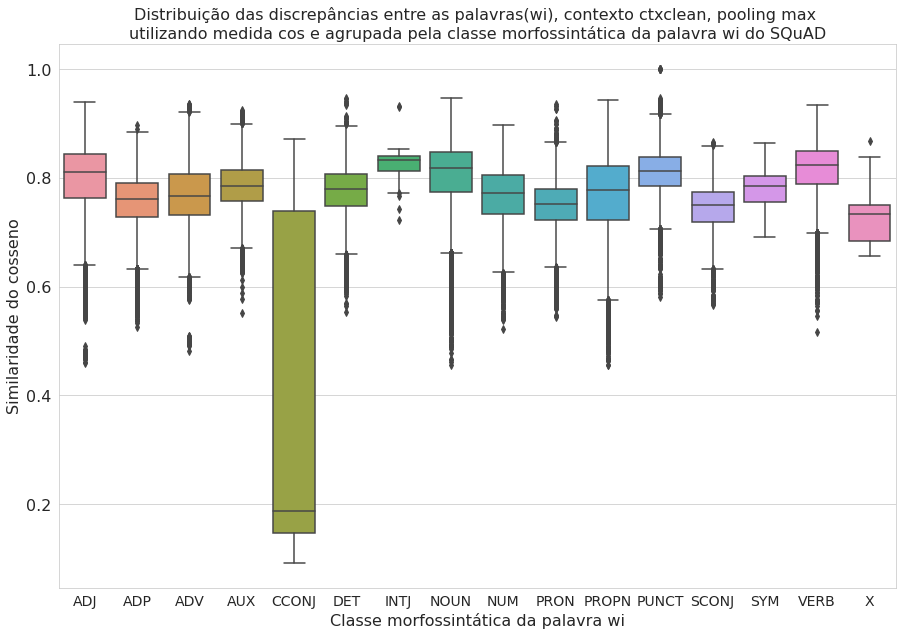

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20383.000000 23.145946 4.039583 12.932697 20.286030 22.779629 25.712864   
ADP   52238.000000 25.985680 2.763893 16.529690 24.053437 25.845020 27.669967   
ADV   10296.000000 27.003460 3.606099 13.674975 24.917369 26.711769 29.062625   
AUX   15843.000000 24.227406 2.572992 14.022170 22.695033 24.246092 25.764890   
CCONJ  3213.000000 33.006491 5.532494 20.610165 27.365627 36.448025 37.651096   
DET   41284.000000 24.358655 2.694116 13.181326 22.511747 24.234776 26.032580   
INTJ     30.000000 21.352852 3.761007 17.031250 18.903325 19.658255 24.459342   
NOUN  67194.000000 22.948073 3.615788 12.095321 20.544742 22.493617 24.869676   
NUM    4482.000000 25.536106 3.710674 14.372837 23.197065 25.416836 28.083324   
PRON  22978.000000 26.207638 2.508441 13.143435 24.585350 26.062046 27.714410   
PROPN 31801.000000 22.589980 3.586234 12.234723 20.113636 22.386646 24.649822   
PUNCT 33654.000000 22.002226 2.474281  0.000000 20.464590 22.033776 23.593751   
SCONJ  7705.000000 26.737769 2.771811 17.459837 24.998203 26.559900 28.247871   
SYM     127.000000 25.695999 1.565185 23.247709 24.437287 25.363523 27.066669   
VERB  28822.000000 24.564871 3.648148 13.196042 22.093099 24.406538 26.770092   
X        45.000000 23.447700 2.733968 18.940807 22.627096 23.130518 23.703159   

            max  
pos_i            
ADJ   41.505409  
ADP   45.095535  
ADV   45.082916  
AUX   44.445507  
CCONJ 41.339409  
DET   41.119804  
INTJ  30.480700  
NOUN  42.424927  
NUM   40.586639  
PRON  44.128262  
PROPN 43.504749  
PUNCT 34.781311  
SCONJ 42.970169  
SYM   29.106361  
VERB  47.041553  
X     40.028549

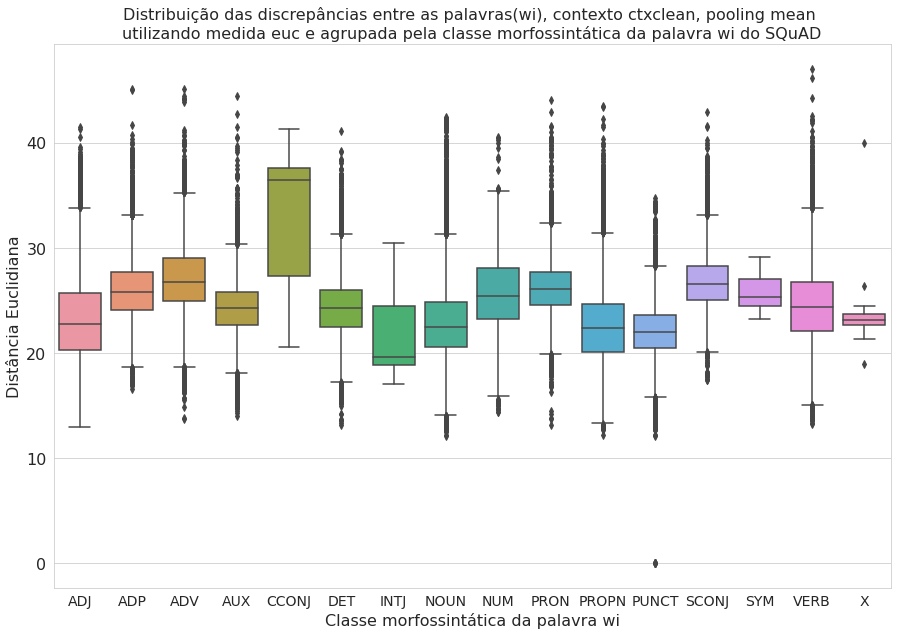

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20383.000000 24.762914 3.960949 13.788529 21.884633 24.472086 27.177157   
ADP   52238.000000 25.992790 2.758817 17.409979 24.055225 25.846957 27.671961   
ADV   10296.000000 27.220132 3.448443 16.257898 25.055292 26.800387 29.157979   
AUX   15843.000000 24.227406 2.572992 14.022170 22.695033 24.246092 25.764890   
CCONJ  3213.000000 33.006491 5.532494 20.610165 27.365627 36.448025 37.651096   
DET   41284.000000 24.549494 2.624033 13.181326 22.703379 24.387049 26.193287   
INTJ     30.000000 24.004085 2.187661 21.439110 22.781851 23.056658 24.459342   
NOUN  67194.000000 23.853526 3.874890 12.095321 21.155116 23.260228 26.095335   
NUM    4482.000000 26.849809 3.540365 18.475286 24.238539 26.484993 28.891983   
PRON  22978.000000 26.294755 2.575941 13.143435 24.609781 26.111251 27.795607   
PROPN 31801.000000 25.949979 4.087589 13.748887 23.023344 25.542873 28.460016   
PUNCT 33654.000000 22.002335 2.474643  0.000000 20.464590 22.033776 23.593751   
SCONJ  7705.000000 26.777091 2.748210 18.771667 25.010525 26.571117 28.262995   
SYM     127.000000 25.695999 1.565185 23.247709 24.437287 25.363523 27.066669   
VERB  28822.000000 24.991487 3.554840 13.196042 22.589512 24.779565 27.132053   
X        45.000000 27.741634 2.719598 18.940807 26.357603 27.508673 29.098995   

            max  
pos_i            
ADJ   44.719810  
ADP   45.095535  
ADV   45.082916  
AUX   44.445507  
CCONJ 41.339409  
DET   41.119804  
INTJ  30.480700  
NOUN  42.424927  
NUM   41.572437  
PRON  44.128262  
PROPN 43.504749  
PUNCT 34.781311  
SCONJ 42.970169  
SYM   29.106361  
VERB  47.041553  
X     40.028549

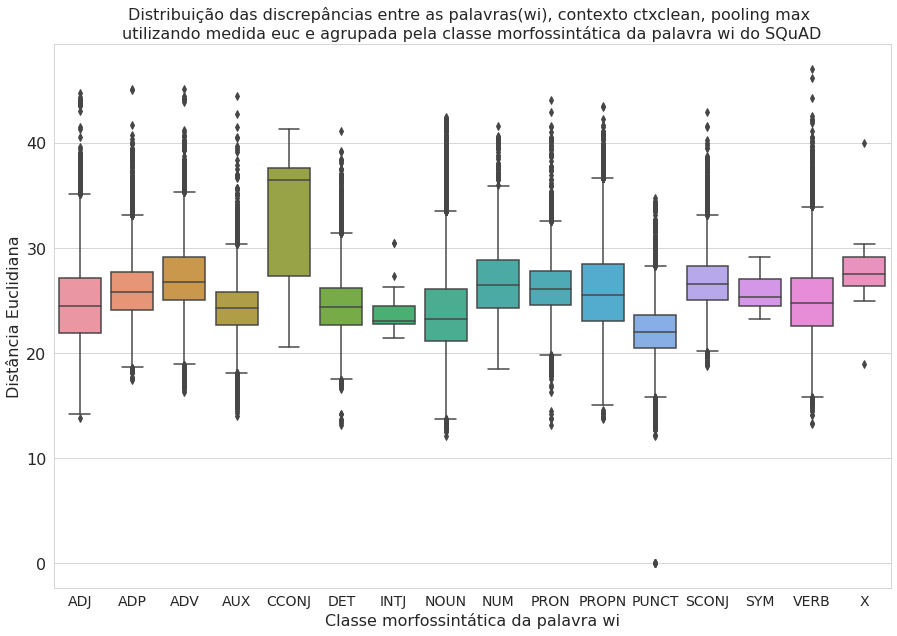

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20383.000000 1089.206735 184.380937  629.886800  954.036920 1077.822500   
ADP   52238.000000 1267.850314 134.068597  818.554140 1174.793150 1260.026650   
ADV   10296.000000 1293.285299 167.071964  649.199460 1198.142000 1287.905650   
AUX   15843.000000 1165.240770 117.357557  680.152340 1094.145750 1165.422700   
CCONJ  3213.000000 1236.557209 102.762782  987.171260 1164.538800 1203.411600   
DET   41284.000000 1184.830801 128.056591  636.548340 1098.366325 1178.168200   
INTJ     30.000000 1033.888453 163.258410  836.544430  933.380465  973.564200   
NOUN  67194.000000 1082.312734 165.929097  584.524400  970.134870 1061.390950   
NUM    4482.000000 1222.946707 178.789932  694.345760 1113.148300 1215.700050   
PRON  22978.000000 1274.757943 121.783207  633.122200 1195.474825 1269.302500   
PROPN 31801.000000 1049.769706 151.195969  605.816830  948.119140 1040.476600   
PUNCT 33654.000000 1068.064089 121.482009    0.000000  990.511813 1070.396800   
SCONJ  7705.000000 1306.171108 137.144298  847.006200 1220.987800 1297.328100   
SYM     127.000000 1238.627586  70.101050 1119.771600 1178.750400 1225.013000   
VERB  28822.000000 1168.932452 161.677335  641.974240 1060.454850 1165.806250   
X        45.000000 1072.840845  93.188084  880.371640 1047.464400 1063.099400   

              75%         max  
pos_i                          
ADJ   1210.876750 1840.369300  
ADP   1348.970350 2035.425000  
ADV   1388.693725 1882.942400  
AUX   1235.649050 1977.860700  
CCONJ 1275.857000 1813.863000  
DET   1263.054050 1874.351700  
INTJ  1049.467267 1497.539300  
NOUN  1173.055650 1963.251200  
NUM   1344.620425 1779.231200  
PRON  1349.549475 1955.705600  
PROPN 1138.437500 1867.252800  
PUNCT 1147.569000 1625.104500  
SCONJ 1377.731400 2058.707300  
SYM   1310.987100 1358.539300  
VERB  1271.215275 2145.623500  
X     1078.318100 1611.274200

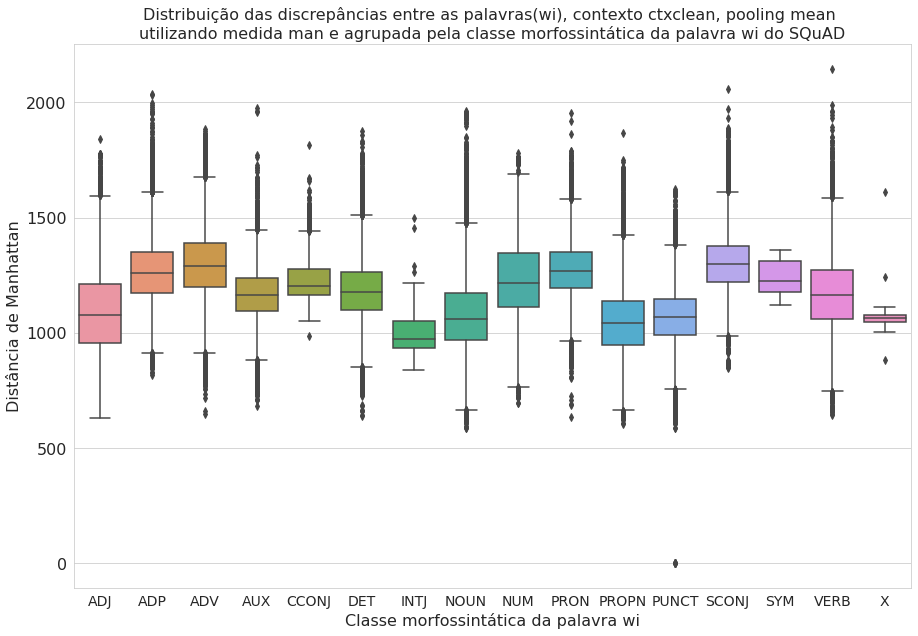

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20383.000000 1167.338611 187.851055  641.898700 1031.805300 1153.630500   
ADP   52238.000000 1268.199153 133.815314  857.921100 1174.964250 1260.179550   
ADV   10296.000000 1303.764598 158.320260  774.281860 1206.274350 1291.807650   
AUX   15843.000000 1165.240770 117.357557  680.152340 1094.145750 1165.422700   
CCONJ  3213.000000 1236.557209 102.762782  987.171260 1164.538800 1203.411600   
DET   41284.000000 1193.812552 124.037464  636.548340 1106.887125 1185.975000   
INTJ     30.000000 1163.098576 101.347642 1022.244570 1122.687275 1139.555250   
NOUN  67194.000000 1125.521526 180.653506  584.524400  999.872090 1099.172000   
NUM    4482.000000 1288.341758 177.520383  895.117070 1159.433050 1264.728550   
PRON  22978.000000 1278.314121 123.578575  633.122200 1197.818450 1271.836900   
PROPN 31801.000000 1215.420377 206.681575  645.978760 1067.737800 1187.252000   
PUNCT 33654.000000 1068.096222 121.505522    0.000000  990.535400 1070.433100   
SCONJ  7705.000000 1308.237999 136.226742  912.303960 1223.400500 1298.333500   
SYM     127.000000 1238.627586  70.101050 1119.771600 1178.750400 1225.013000   
VERB  28822.000000 1189.639560 158.876154  641.974240 1083.107050 1184.334400   
X        45.000000 1238.436201  89.850192  880.371640 1201.523000 1241.756600   

              75%         max  
pos_i                          
ADJ   1283.513550 2245.952600  
ADP   1349.145775 2035.425000  
ADV   1391.783400 1904.473000  
AUX   1235.649050 1977.860700  
CCONJ 1275.857000 1813.863000  
DET   1271.023525 1874.351700  
INTJ  1166.063025 1497.539300  
NOUN  1227.841825 2224.537600  
NUM   1398.676750 2113.470000  
PRON  1353.209475 1955.705600  
PROPN 1332.219000 2080.227800  
PUNCT 1147.627350 1625.104500  
SCONJ 1379.135700 2058.707300  
SYM   1310.987100 1358.539300  
VERB  1288.436125 2145.623500  
X     1272.682000 1611.274200

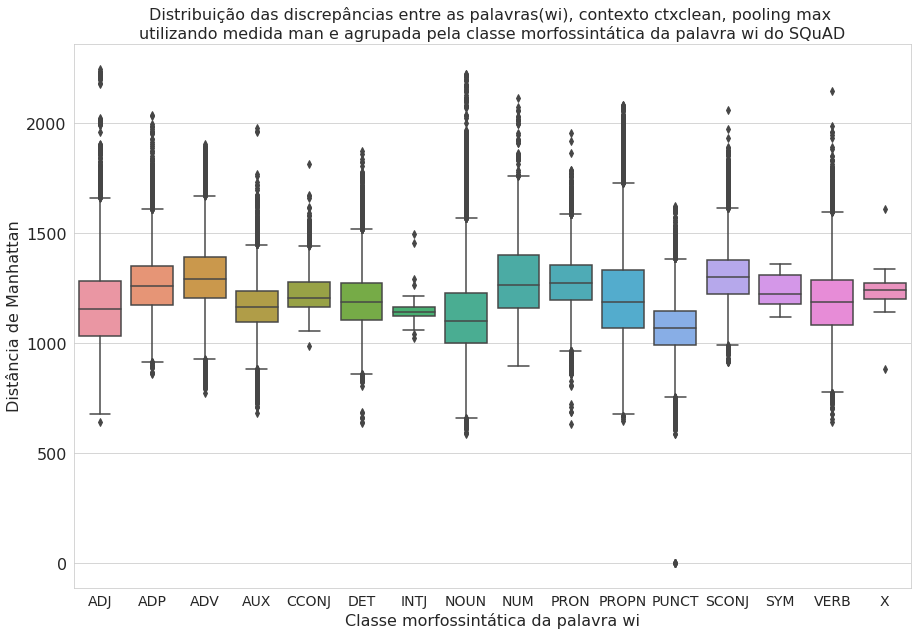

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   19836.000000 0.658008 0.073116 0.361098 0.608581 0.662627 0.710647   
ADP   50733.000000 0.654325 0.075837 0.300268 0.605544 0.661294 0.709834   
ADV   10054.000000 0.719667 0.069376 0.411200 0.679233 0.731128 0.770737   
AUX   15843.000000 0.942496 0.056434 0.712334 0.899559 0.931522 1.000000   
CCONJ  3088.000000 0.338029 0.276992 0.035415 0.101259 0.135191 0.649898   
DET   40203.000000 0.704510 0.078329 0.336929 0.654743 0.704405 0.758729   
INTJ      3.000000 0.708774 0.022694 0.692511 0.695810 0.699110 0.716905   
NOUN  65423.000000 0.649309 0.069546 0.358891 0.604963 0.653745 0.699713   
NUM    4357.000000 0.623381 0.070789 0.385838 0.577247 0.623410 0.669930   
PRON  22489.000000 0.712886 0.065510 0.445084 0.668481 0.716970 0.761221   
PROPN 30622.000000 0.606105 0.073543 0.274632 0.556460 0.609104 0.658968   
PUNCT 32658.000000 0.683417 0.067382 0.288670 0.641334 0.691398 0.734249   
SCONJ  7614.000000 0.709650 0.061893 0.475291 0.669363 0.715457 0.755126   
SYM     126.000000 0.588181 0.046880 0.452587 0.567335 0.595518 0.620166   
VERB  28822.000000 0.934907 0.056046 0.737606 0.895033 0.928599 1.000000   
X        41.000000 0.612163 0.049622 0.470648 0.587830 0.604842 0.643305   

           max  
pos_i           
ADJ   0.894001  
ADP   0.860169  
ADV   0.901100  
AUX   1.000000  
CCONJ 0.847443  
DET   0.894395  
INTJ  0.734700  
NOUN  0.870525  
NUM   0.842727  
PRON  0.872565  
PROPN 0.888948  
PUNCT 0.850400  
SCONJ 0.869629  
SYM   0.713183  
VERB  1.000000  
X     0.756656

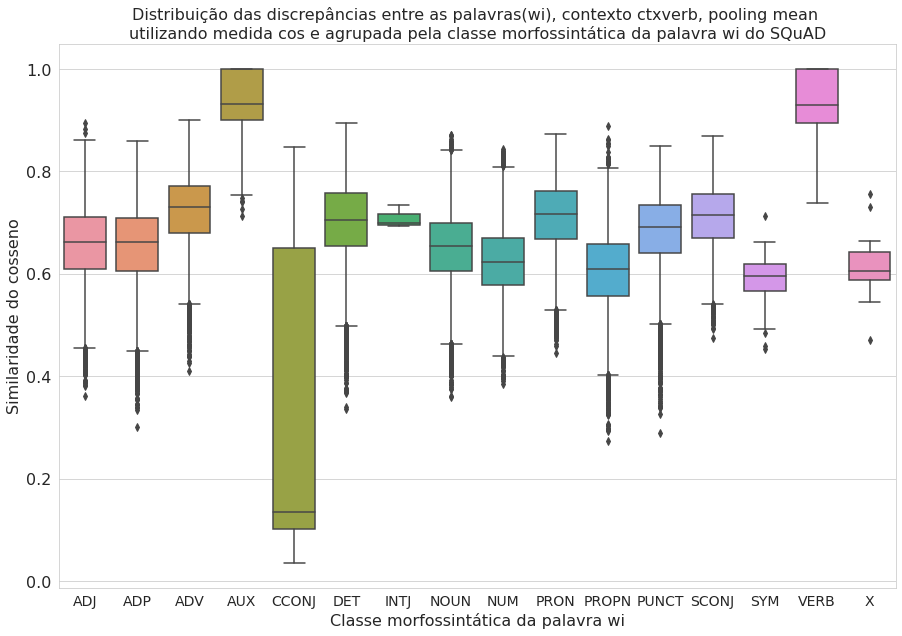

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   19836.000000 0.639553 0.081822 0.272986 0.588337 0.644317 0.699031   
ADP   50733.000000 0.654254 0.075924 0.300268 0.605467 0.661235 0.709831   
ADV   10054.000000 0.717075 0.071740 0.411200 0.675859 0.729259 0.770044   
AUX   15843.000000 0.942496 0.056434 0.712334 0.899559 0.931522 1.000000   
CCONJ  3088.000000 0.338029 0.276992 0.035415 0.101259 0.135191 0.649898   
DET   40203.000000 0.702112 0.078859 0.336929 0.652510 0.701940 0.755518   
INTJ      3.000000 0.690487 0.045259 0.644250 0.668380 0.692511 0.713605   
NOUN  65423.000000 0.638344 0.076450 0.273082 0.590212 0.644596 0.694126   
NUM    4357.000000 0.608395 0.079992 0.325585 0.558379 0.608111 0.665060   
PRON  22489.000000 0.711691 0.065425 0.377507 0.667377 0.716381 0.760592   
PROPN 30622.000000 0.567774 0.076987 0.274582 0.515469 0.570630 0.622233   
PUNCT 32658.000000 0.683416 0.067381 0.288670 0.641334 0.691398 0.734249   
SCONJ  7614.000000 0.709131 0.062639 0.475291 0.668937 0.715240 0.755126   
SYM     126.000000 0.588181 0.046880 0.452587 0.567335 0.595518 0.620166   
VERB  28822.000000 0.928938 0.065036 0.594533 0.889568 0.927677 1.000000   
X        41.000000 0.557891 0.060507 0.468172 0.523124 0.549903 0.594620   

           max  
pos_i           
ADJ   0.894001  
ADP   0.860169  
ADV   0.901100  
AUX   1.000000  
CCONJ 0.847443  
DET   0.894395  
INTJ  0.734700  
NOUN  0.870525  
NUM   0.842727  
PRON  0.872565  
PROPN 0.862878  
PUNCT 0.850400  
SCONJ 0.869629  
SYM   0.713183  
VERB  1.000000  
X     0.756656

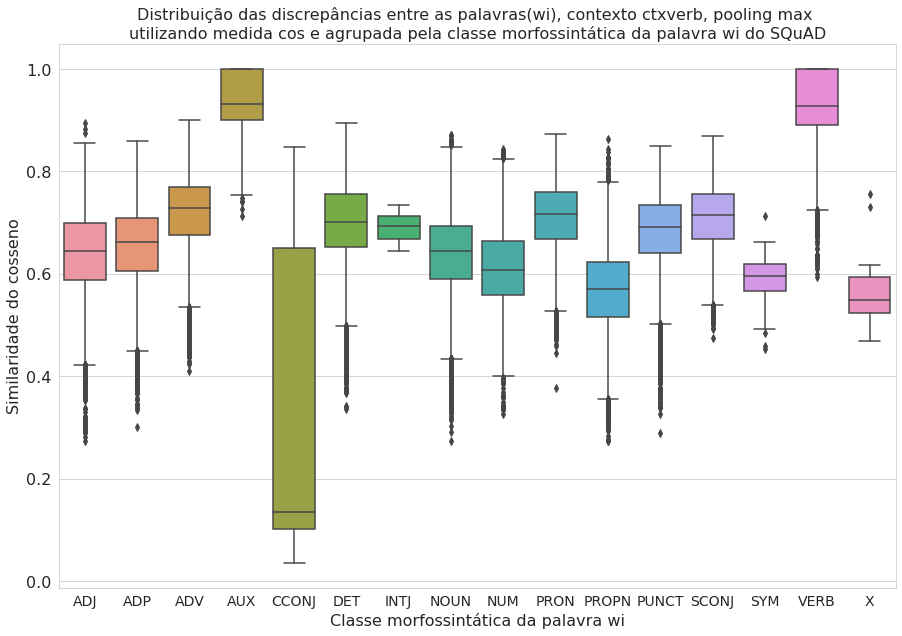

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   19836.000000 33.341912 4.604709 19.307701 30.111374 33.024475 36.342114   
ADP   50733.000000 33.153658 4.754323 19.033123 29.715635 32.666004 36.097309   
ADV   10054.000000 30.932019 4.914681 19.952049 27.106971 30.376533 34.092588   
AUX   15843.000000  9.678203 8.780885  0.000000  0.000000 14.178749 17.291537   
CCONJ  3088.000000 40.028763 7.010644 20.864567 33.881786 42.026518 44.739022   
DET   40203.000000 30.273279 5.325525 16.768291 26.509215 30.171822 33.771559   
INTJ      3.000000 32.639454 0.877770 31.628677 32.354246 33.079815 33.144842   
NOUN  65423.000000 33.632994 4.350733 18.706682 30.598806 33.367889 36.358948   
NUM    4357.000000 35.625534 4.786794 21.236176 32.198853 35.665707 38.566757   
PRON  22489.000000 29.869441 4.646917 18.841503 26.482672 29.398550 32.828472   
PROPN 30622.000000 35.368289 4.299029 22.472353 32.438620 35.161678 38.021111   
PUNCT 32658.000000 30.929880 4.661795 19.601683 27.410871 30.045796 33.873917   
SCONJ  7614.000000 30.057099 4.424083 18.834415 27.018847 29.484384 32.759356   
SYM     126.000000 37.303716 3.519884 32.833092 34.840186 36.141562 39.840800   
VERB  28822.000000 11.984327 9.307691  0.000000  0.000000 16.006541 19.189392   
X        41.000000 35.266933 2.705134 28.288782 33.525177 35.065056 37.092300   

            max  
pos_i            
ADJ   54.829559  
ADP   55.755062  
ADV   52.643291  
AUX   29.903566  
CCONJ 62.451836  
DET   57.827114  
INTJ  33.209869  
NOUN  56.597595  
NUM   52.569065  
PRON  53.626038  
PROPN 58.201260  
PUNCT 60.367714  
SCONJ 48.605480  
SYM   51.547646  
VERB  33.503696  
X     44.411758

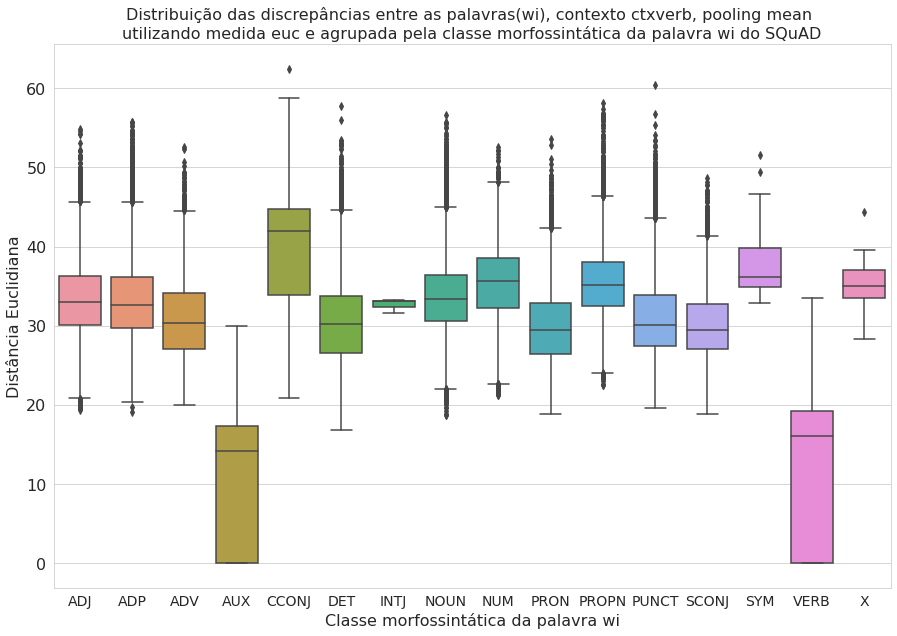

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   19836.000000 34.465492 4.723568 20.707390 31.110764 34.098074 37.346991   
ADP   50733.000000 33.157821 4.758429 19.033123 29.715706 32.667091 36.104694   
ADV   10054.000000 31.097489 4.986399 19.952049 27.221073 30.521657 34.289993   
AUX   15843.000000  9.678203 8.780885  0.000000  0.000000 14.178749 17.291537   
CCONJ  3088.000000 40.028763 7.010644 20.864567 33.881786 42.026518 44.739022   
DET   40203.000000 30.419270 5.342732 16.768291 26.693032 30.316223 33.915482   
INTJ      3.000000 33.573875 2.233593 31.628677 32.354246 33.079815 34.546474   
NOUN  65423.000000 34.283120 4.537695 18.706682 31.126902 33.952751 37.096861   
NUM    4357.000000 36.567446 5.095196 21.236176 33.060902 36.457645 39.855114   
PRON  22489.000000 29.950766 4.624214 18.841503 26.550644 29.435711 32.906971   
PROPN 30622.000000 37.691792 4.296945 22.472353 34.608168 37.383146 40.371018   
PUNCT 32658.000000 30.929931 4.661826 19.601683 27.410871 30.045796 33.874248   
SCONJ  7614.000000 30.088459 4.448403 18.834415 27.021569 29.512638 32.810844   
SYM     126.000000 37.303716 3.519884 32.833092 34.840186 36.141562 39.840800   
VERB  28822.000000 12.536544 9.677058  0.000000  0.000000 16.238789 19.818084   
X        41.000000 38.475027 2.832260 28.288782 36.669388 38.671402 39.947586   

            max  
pos_i            
ADJ   59.637615  
ADP   55.755062  
ADV   52.643291  
AUX   29.903566  
CCONJ 62.451836  
DET   57.827114  
INTJ  36.013134  
NOUN  57.363255  
NUM   52.569065  
PRON  53.626038  
PROPN 59.451775  
PUNCT 60.367714  
SCONJ 48.605480  
SYM   51.547646  
VERB  35.646072  
X     44.411758

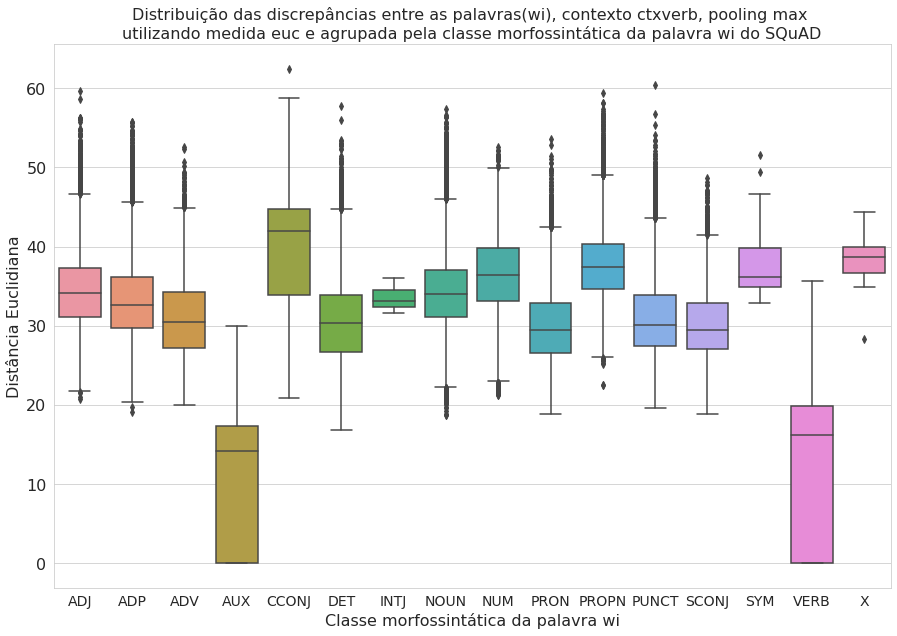

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   19836.000000 1579.584441 204.028781  914.090698 1438.335968 1570.005249   
ADP   50733.000000 1608.659191 209.591957  948.130371 1456.456299 1593.731445   
ADV   10054.000000 1490.018069 221.190531  954.995239 1323.712677 1465.081482   
AUX   15843.000000  463.312826 419.507690    0.000000    0.000000  685.080811   
CCONJ  3088.000000 1617.622807 185.496413 1027.109375 1480.947540 1603.904846   
DET   40203.000000 1463.120653 239.132961  814.933960 1295.640076 1464.252319   
INTJ      3.000000 1568.684774  51.638454 1529.632324 1539.410706 1549.189087   
NOUN  65423.000000 1593.136731 194.603384  895.426636 1455.477905 1585.381592   
NUM    4357.000000 1707.277321 218.034930 1047.021484 1553.103271 1703.306519   
PRON  22489.000000 1445.802688 214.918189  918.492981 1292.356445 1428.287354   
PROPN 30622.000000 1665.850587 187.747342 1053.313477 1533.218933 1659.351990   
PUNCT 32658.000000 1498.161653 201.488486  973.144714 1345.661377 1467.255859   
SCONJ  7614.000000 1460.928516 211.055977  910.677979 1316.747223 1431.757751   
SYM     126.000000 1786.030121 145.593879 1584.705200 1664.146881 1749.715393   
VERB  28822.000000  574.559014 445.506495    0.000000    0.000000  769.939789   
X        41.000000 1644.696780 117.901094 1330.310059 1578.537842 1631.825684   

              75%         max  
pos_i                          
ADJ   1715.783173 2388.907715  
ADP   1748.784180 2417.771484  
ADV   1630.403839 2406.385742  
AUX    827.657043 1428.114990  
CCONJ 1750.393585 2367.872070  
DET   1625.017700 2406.042480  
INTJ  1588.210999 1627.232910  
NOUN  1721.655334 2413.784424  
NUM   1841.225830 2418.588623  
PRON  1585.234131 2405.947510  
PROPN 1789.460144 2372.669922  
PUNCT 1634.417786 2365.271973  
SCONJ 1593.393951 2229.729492  
SYM   1900.640778 2177.899414  
VERB   921.787491 1589.097900  
X     1690.488525 2123.088867

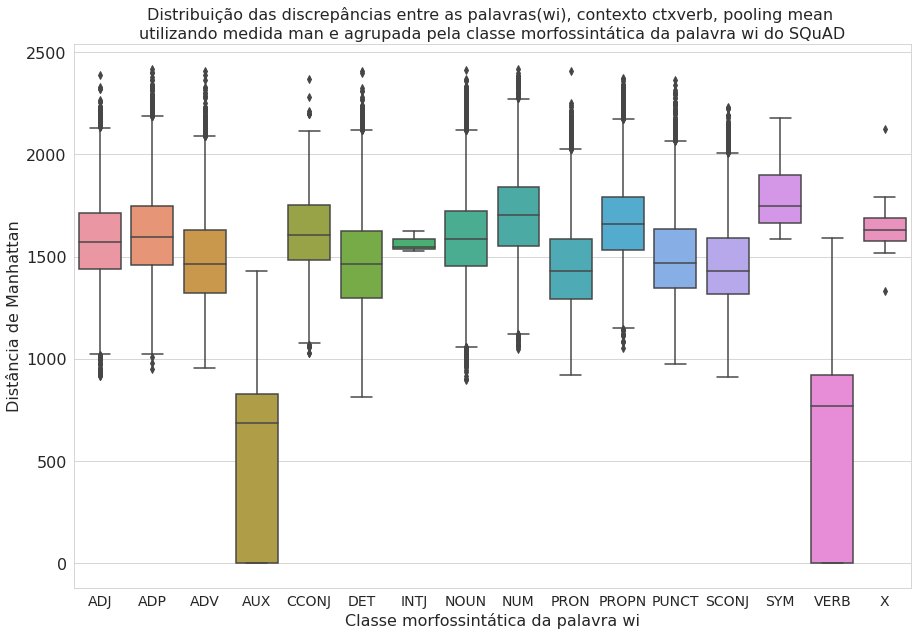

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   19836.000000 1632.621601 211.209140  972.370544 1484.550568 1617.512085   
ADP   50733.000000 1608.859568 209.795125  948.130371 1456.466309 1593.787720   
ADV   10054.000000 1497.846178 223.502857  956.671875 1327.037659 1473.039185   
AUX   15843.000000  463.312826 419.507690    0.000000    0.000000  685.080811   
CCONJ  3088.000000 1617.622807 185.496413 1027.109375 1480.947540 1603.904846   
DET   40203.000000 1469.874168 239.612784  814.933960 1304.593445 1470.855103   
INTJ      3.000000 1604.689412 113.488085 1529.632324 1539.410706 1549.189087   
NOUN  65423.000000 1623.170731 202.657529  895.426636 1479.215149 1613.797607   
NUM    4357.000000 1751.897095 230.829699 1059.199707 1587.327881 1751.665283   
PRON  22489.000000 1449.212757 213.562860  918.492981 1294.568481 1429.556641   
PROPN 30622.000000 1776.804125 200.348797 1081.096313 1632.436462 1766.608398   
PUNCT 32658.000000 1498.166330 201.490958  973.144714 1345.661377 1467.255859   
SCONJ  7614.000000 1462.525455 212.375378  910.677979 1317.377930 1433.251587   
SYM     126.000000 1786.030121 145.593879 1584.705200 1664.146881 1749.715393   
VERB  28822.000000  601.274924 463.697214    0.000000    0.000000  780.192871   
X        41.000000 1764.572382 119.909446 1330.310059 1687.561646 1773.573242   

              75%         max  
pos_i                          
ADJ   1771.027100 2609.769287  
ADP   1749.063599 2417.771484  
ADV   1638.852356 2406.385742  
AUX    827.657043 1428.114990  
CCONJ 1750.393585 2367.872070  
DET   1631.582092 2406.042480  
INTJ  1642.217957 1735.246826  
NOUN  1753.434692 2505.884521  
NUM   1901.158203 2418.588623  
PRON  1588.395996 2405.947510  
PROPN 1908.631775 2591.963867  
PUNCT 1634.485352 2365.271973  
SCONJ 1596.354156 2229.729492  
SYM   1900.640778 2177.899414  
VERB   950.568924 1705.520508  
X     1810.528076 2123.088867

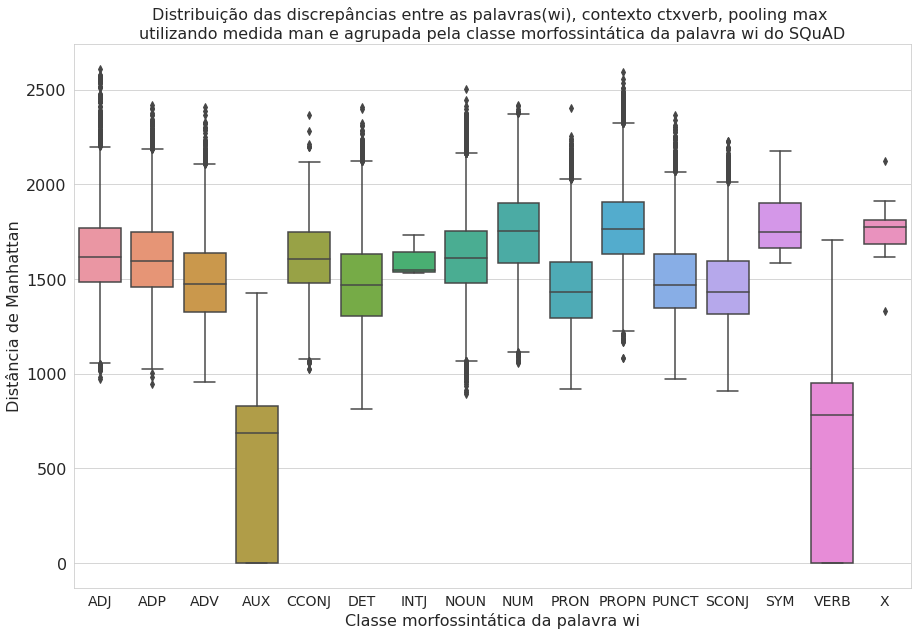

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   19966.000000 0.724652 0.055578 0.422520 0.689529 0.727807 0.761327   
ADP   50738.000000 0.704042 0.065993 0.402593 0.667080 0.713288 0.750816   
ADV    9476.000000 0.657897 0.062919 0.451318 0.615476 0.663153 0.703426   
AUX   14705.000000 0.693034 0.053583 0.463940 0.656453 0.695405 0.732744   
CCONJ  3061.000000 0.371973 0.266644 0.069511 0.133081 0.184236 0.658375   
DET   39806.000000 0.714676 0.052378 0.421008 0.682473 0.718914 0.751710   
INTJ     28.000000 0.682998 0.039513 0.564175 0.659826 0.681596 0.713155   
NOUN  67194.000000 0.883187 0.059440 0.593737 0.845799 0.880502 0.914627   
NUM    4311.000000 0.664756 0.063335 0.417681 0.628317 0.668949 0.705369   
PRON  21221.000000 0.647994 0.056725 0.435795 0.609679 0.650877 0.687569   
PROPN 27546.000000 0.643642 0.073436 0.311699 0.594590 0.646822 0.696162   
PUNCT 31487.000000 0.658631 0.050080 0.396007 0.627462 0.661525 0.692738   
SCONJ  7291.000000 0.648282 0.063268 0.436728 0.606411 0.650956 0.693065   
SYM     127.000000 0.667732 0.064771 0.557632 0.613612 0.664124 0.729743   
VERB  27047.000000 0.689830 0.061034 0.419089 0.654182 0.696538 0.733659   
X        44.000000 0.601641 0.024482 0.567506 0.581111 0.602214 0.616955   

           max  
pos_i           
ADJ   0.945726  
ADP   0.876021  
ADV   0.877483  
AUX   0.845581  
CCONJ 0.824883  
DET   0.871882  
INTJ  0.748272  
NOUN  1.000000  
NUM   0.811266  
PRON  0.857496  
PROPN 0.880035  
PUNCT 0.829145  
SCONJ 0.824882  
SYM   0.785436  
VERB  0.849375  
X     0.684856

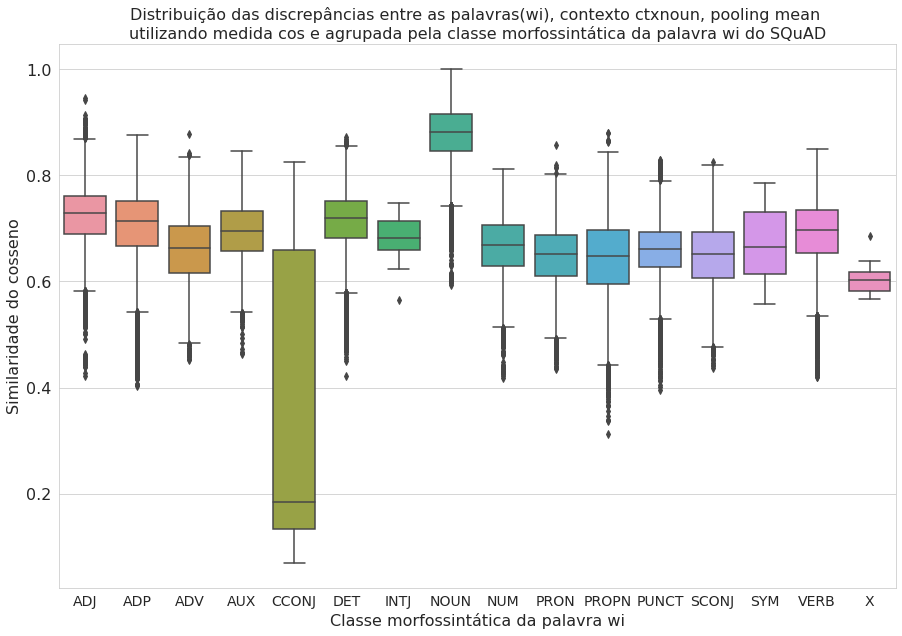

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   19966.000000 0.704179 0.066300 0.238952 0.664945 0.711513 0.750145   
ADP   50738.000000 0.703951 0.066044 0.402593 0.666980 0.713202 0.750787   
ADV    9476.000000 0.655150 0.064204 0.359081 0.613423 0.660309 0.701574   
AUX   14705.000000 0.693034 0.053583 0.463940 0.656453 0.695405 0.732744   
CCONJ  3061.000000 0.371973 0.266644 0.069511 0.133081 0.184236 0.658375   
DET   39806.000000 0.712139 0.054835 0.421008 0.678524 0.717608 0.751400   
INTJ     28.000000 0.653743 0.031963 0.564175 0.636766 0.658960 0.673886   
NOUN  67194.000000 0.869650 0.071581 0.504419 0.832076 0.873135 0.911094   
NUM    4311.000000 0.649528 0.071019 0.417681 0.606797 0.657799 0.696141   
PRON  21221.000000 0.646879 0.057716 0.435795 0.607381 0.649972 0.687465   
PROPN 27546.000000 0.604423 0.079649 0.263824 0.552187 0.606208 0.659845   
PUNCT 31487.000000 0.658629 0.050081 0.396007 0.627461 0.661525 0.692734   
SCONJ  7291.000000 0.647753 0.063061 0.436728 0.605696 0.650698 0.692739   
SYM     127.000000 0.667732 0.064771 0.557632 0.613612 0.664124 0.729743   
VERB  27047.000000 0.684414 0.061650 0.419089 0.647546 0.691729 0.728538   
X        44.000000 0.545983 0.047199 0.487112 0.502883 0.563010 0.579240   

           max  
pos_i           
ADJ   0.945726  
ADP   0.876021  
ADV   0.877483  
AUX   0.845581  
CCONJ 0.824883  
DET   0.871882  
INTJ  0.718548  
NOUN  1.000000  
NUM   0.811266  
PRON  0.857496  
PROPN 0.880035  
PUNCT 0.829145  
SCONJ 0.824882  
SYM   0.785436  
VERB  0.849375  
X     0.684856

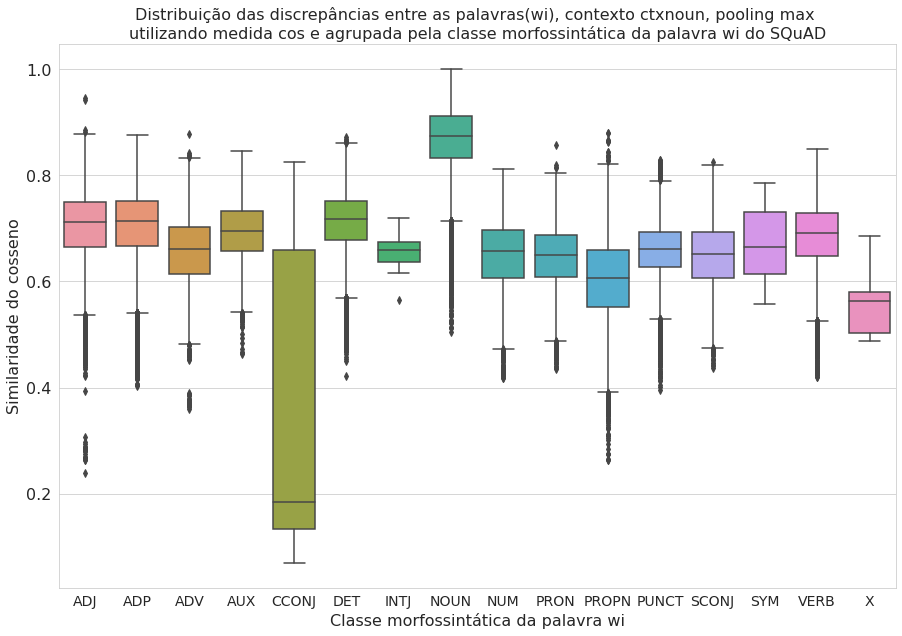

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   19966.000000 28.934629 4.181614 12.179195 26.147133 28.756595 31.311268   
ADP   50738.000000 29.152282 3.710833 18.706591 26.549667 28.691933 31.244641   
ADV    9476.000000 33.249472 4.011966 21.302179 30.519475 32.760464 35.560148   
AUX   14705.000000 29.604476 3.121748 21.325266 27.451097 29.328842 31.425543   
CCONJ  3061.000000 36.213440 5.244506 22.751181 31.968481 37.748112 39.845650   
DET   39806.000000 28.300427 3.084951 18.214766 26.164492 27.993687 30.043051   
INTJ     28.000000 33.309811 4.682714 28.198931 30.963462 32.759455 33.583703   
NOUN  67194.000000 17.550377 7.116641  0.000000 15.994550 19.001740 21.680735   
NUM    4311.000000 31.941537 4.061886 22.414501 29.210097 31.546614 34.681782   
PRON  21221.000000 31.841044 3.143394 22.532213 29.648092 31.511095 33.769508   
PROPN 27546.000000 32.513378 4.633772 17.864832 29.258844 32.003117 35.484309   
PUNCT 31487.000000 30.500073 2.987420 21.648113 28.482304 30.079136 32.136597   
SCONJ  7291.000000 32.044561 3.513886 22.024609 29.556749 31.833002 34.163736   
SYM     127.000000 31.538867 2.436318 27.595846 29.564803 31.171530 33.020361   
VERB  27047.000000 31.893317 3.990506 20.285978 29.236368 31.563770 34.153843   
X        44.000000 34.447201 2.050331 32.577873 33.615145 34.289774 34.784938   

            max  
pos_i            
ADJ   52.511204  
ADP   52.239079  
ADV   53.594624  
AUX   48.267151  
CCONJ 54.827644  
DET   48.655800  
INTJ  50.258076  
NOUN  40.591515  
NUM   47.117363  
PRON  51.516499  
PROPN 54.870331  
PUNCT 51.080406  
SCONJ 47.053703  
SYM   39.769611  
VERB  54.366077  
X     46.829559

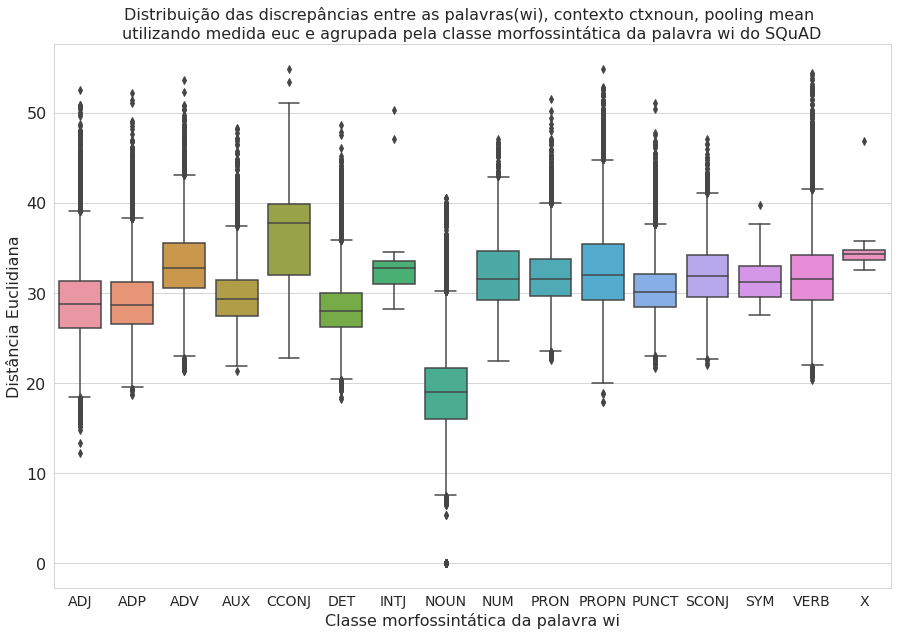

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   19966.000000 30.233647 4.211453 12.179195 27.498368 29.921159 32.603024   
ADP   50738.000000 29.157870 3.715431 18.706591 26.552375 28.692737 31.249868   
ADV    9476.000000 33.426190 3.989570 21.302179 30.693961 32.848112 35.678998   
AUX   14705.000000 29.604476 3.121748 21.325266 27.451097 29.328842 31.425543   
CCONJ  3061.000000 36.213440 5.244506 22.751181 31.968481 37.748112 39.845650   
DET   39806.000000 28.452844 3.186291 18.214766 26.190373 28.099972 30.351168   
INTJ     28.000000 34.837549 4.319411 28.198931 32.942355 33.773123 35.506775   
NOUN  67194.000000 18.695180 7.289260  0.000000 16.461041 19.731310 22.844383   
NUM    4311.000000 32.950637 4.165295 22.414501 30.079202 32.290302 35.749125   
PRON  21221.000000 31.910732 3.191908 22.532213 29.668158 31.570204 33.892918   
PROPN 27546.000000 34.962220 4.546710 17.864832 31.668535 34.763783 37.846600   
PUNCT 31487.000000 30.500043 2.987331 21.648113 28.482304 30.079136 32.136597   
SCONJ  7291.000000 32.078520 3.491651 22.024609 29.576426 31.862057 34.200069   
SYM     127.000000 31.538867 2.436318 27.595846 29.564803 31.171530 33.020361   
VERB  27047.000000 32.246606 3.797967 20.285978 29.618940 31.886673 34.365330   
X        44.000000 37.766797 2.141069 34.337273 36.128608 37.686348 39.114086   

            max  
pos_i            
ADJ   54.990620  
ADP   52.239079  
ADV   53.594624  
AUX   48.267151  
CCONJ 54.827644  
DET   48.655800  
INTJ  50.258076  
NOUN  41.630505  
NUM   47.600132  
PRON  51.516499  
PROPN 56.903202  
PUNCT 51.080406  
SCONJ 47.053703  
SYM   39.769611  
VERB  54.366077  
X     46.829559

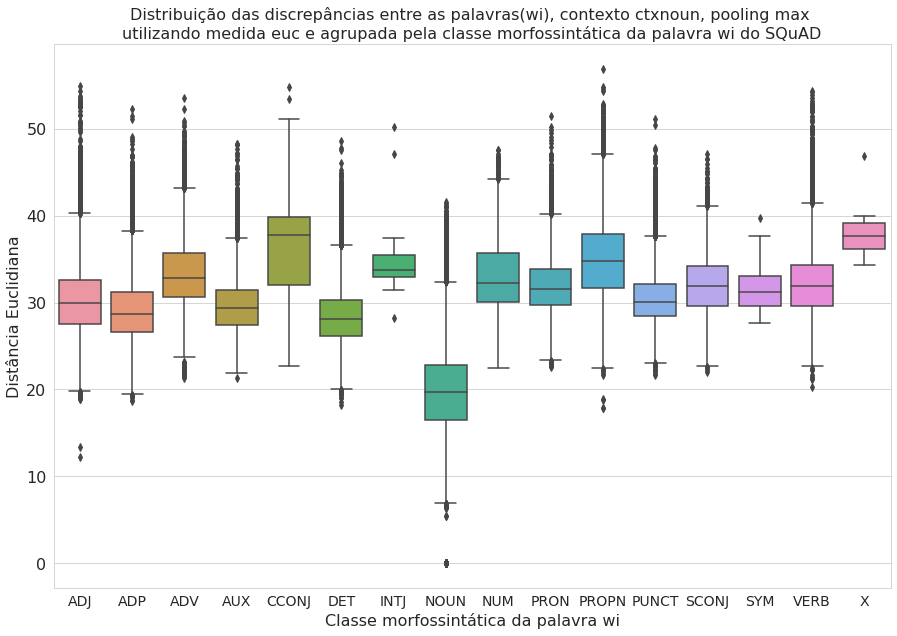

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   19966.000000 1358.836442 188.268159  586.823914 1231.218536 1359.628357   
ADP   50738.000000 1409.124407 175.313089  937.491699 1285.154053 1388.892029   
ADV    9476.000000 1580.305628 170.807391  997.279968 1464.041779 1566.170898   
AUX   14705.000000 1413.945747 141.883851 1023.106934 1313.930420 1400.634766   
CCONJ  3061.000000 1423.319015 151.907924 1107.044922 1302.865234 1387.641968   
DET   39806.000000 1362.613819 144.804920  890.108704 1261.435791 1347.091187   
INTJ     28.000000 1575.056601 110.255218 1386.895508 1501.086945 1582.885559   
NOUN  67194.000000  825.327293 332.595871    0.000000  755.431915  894.675934   
NUM    4311.000000 1522.903196 185.606513 1070.033813 1395.194153 1511.391113   
PRON  21221.000000 1536.946074 144.810954 1074.761230 1436.551514 1526.174072   
PROPN 27546.000000 1514.711496 201.925720  838.830933 1369.951538 1498.302246   
PUNCT 31487.000000 1477.342866 137.002753 1075.198975 1382.650696 1462.455811   
SCONJ  7291.000000 1553.230114 169.469687 1075.989136 1432.385376 1544.210938   
SYM     127.000000 1510.892043  95.364043 1313.286987 1449.794312 1533.729980   
VERB  27047.000000 1514.586003 174.115642  940.808838 1397.441162 1503.593628   
X        44.000000 1533.874232  65.396675 1482.197998 1514.095764 1524.889648   

              75%         max  
pos_i                          
ADJ   1484.222809 2140.948242  
ADP   1508.136749 2235.581299  
ADV   1684.255859 2301.672852  
AUX   1497.347412 2179.123779  
CCONJ 1534.467407 2070.987305  
DET   1446.810791 2185.994141  
INTJ  1616.994904 1879.806885  
NOUN  1020.557404 1791.232056  
NUM   1642.055115 2254.231934  
PRON  1628.942627 2206.191406  
PROPN 1647.386841 2328.024170  
PUNCT 1557.978516 2117.742676  
SCONJ 1658.766235 2261.999512  
SYM   1586.984619 1823.876709  
VERB  1619.849365 2405.960449  
X     1534.538940 1932.338867

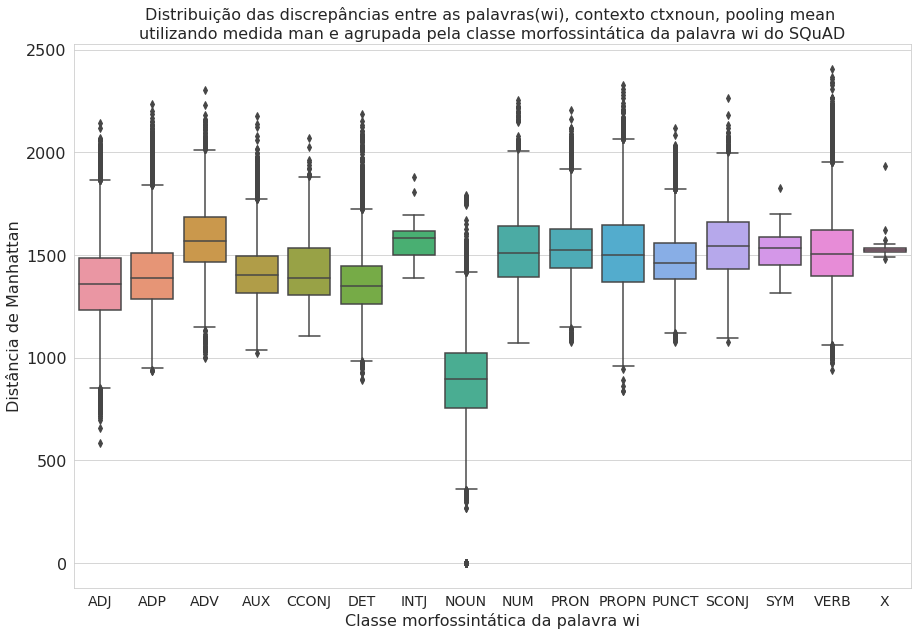

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   19966.000000 1421.447760 193.342016  586.823914 1300.364929 1411.258423   
ADP   50738.000000 1409.395215 175.427420  937.491699 1285.264954 1389.064026   
ADV    9476.000000 1588.802345 169.061415 1025.792236 1473.196411 1571.105835   
AUX   14705.000000 1413.945747 141.883851 1023.106934 1313.930420 1400.634766   
CCONJ  3061.000000 1423.319015 151.907924 1107.044922 1302.865234 1387.641968   
DET   39806.000000 1369.879280 149.760483  890.108704 1262.784149 1352.882935   
INTJ     28.000000 1654.238399  93.121560 1386.895508 1599.959198 1646.209412   
NOUN  67194.000000  881.051749 343.279617    0.000000  780.840805  931.117126   
NUM    4311.000000 1573.166794 195.015440 1085.927002 1443.384766 1546.097412   
PRON  21221.000000 1539.883766 146.566256 1074.761230 1438.817139 1528.367920   
PROPN 27546.000000 1635.393709 214.020580  838.830933 1480.515747 1626.479431   
PUNCT 31487.000000 1477.368017 137.024779 1075.198975 1382.650696 1462.456787   
SCONJ  7291.000000 1555.030846 168.238679 1075.989136 1434.041626 1545.767212   
SYM     127.000000 1510.892043  95.364043 1313.286987 1449.794312 1533.729980   
VERB  27047.000000 1531.766590 165.221927  972.968445 1417.001831 1518.601318   
X        44.000000 1659.132799  53.374498 1587.320557 1628.898010 1653.772278   

              75%         max  
pos_i                          
ADJ   1536.131531 2523.168213  
ADP   1508.321289 2235.581299  
ADV   1690.461487 2301.672852  
AUX   1497.347412 2179.123779  
CCONJ 1534.467407 2070.987305  
DET   1461.309723 2185.994141  
INTJ  1706.831635 1879.806885  
NOUN  1074.431580 2211.171387  
NUM   1697.324524 2254.231934  
PRON  1632.978516 2206.191406  
PROPN 1778.316589 2510.271240  
PUNCT 1557.993774 2117.742676  
SCONJ 1660.210632 2261.999512  
SYM   1586.984619 1823.876709  
VERB  1630.722778 2405.960449  
X     1680.924072 1932.338867

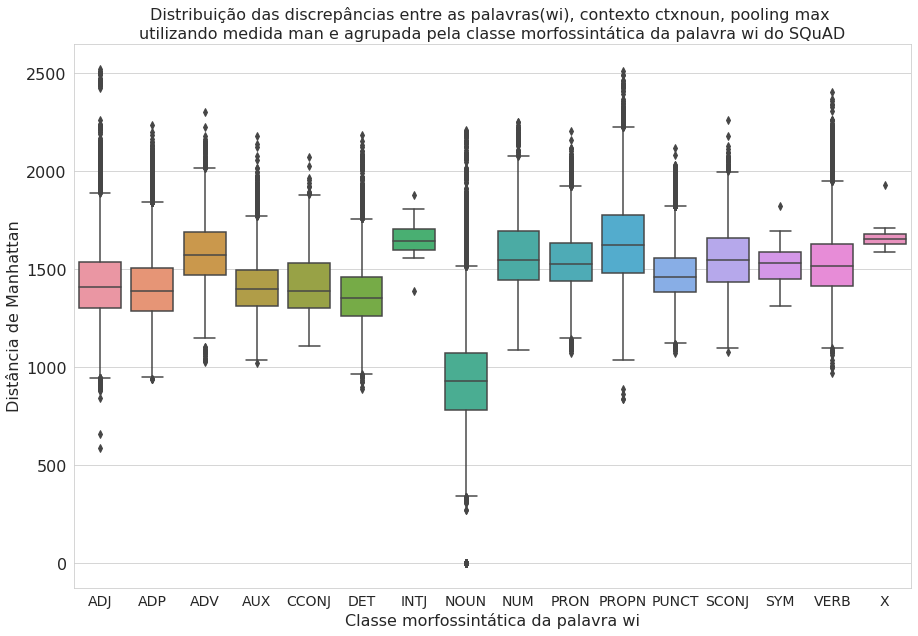

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20357.000000 0.748078 0.046584 0.468688 0.720676 0.752216 0.779763   
ADP   52155.000000 0.732625 0.057857 0.409533 0.700253 0.740287 0.772888   
ADV   10272.000000 0.738248 0.052165 0.509789 0.712300 0.745762 0.773877   
AUX   15843.000000 0.862152 0.049099 0.668007 0.832792 0.864512 0.894616   
CCONJ  3193.000000 0.385919 0.287271 0.064910 0.129348 0.176504 0.702754   
DET   41244.000000 0.758155 0.051613 0.495912 0.725177 0.760332 0.793619   
INTJ     29.000000 0.687108 0.039881 0.564175 0.663481 0.698271 0.717499   
NOUN  67194.000000 0.845190 0.045975 0.576384 0.817601 0.848203 0.876695   
NUM    4471.000000 0.696453 0.055633 0.413024 0.665274 0.695291 0.730044   
PRON  22863.000000 0.726555 0.045351 0.530206 0.696216 0.729691 0.759270   
PROPN 31599.000000 0.671148 0.066695 0.336549 0.628208 0.676206 0.718896   
PUNCT 33554.000000 0.716169 0.045806 0.339278 0.689465 0.719881 0.747476   
SCONJ  7701.000000 0.727497 0.048746 0.498960 0.698085 0.729192 0.761588   
SYM     127.000000 0.681816 0.054485 0.588124 0.633601 0.669929 0.727924   
VERB  28822.000000 0.863351 0.047499 0.659767 0.834149 0.861406 0.892517   
X        45.000000 0.644872 0.031344 0.580145 0.626007 0.638897 0.667865   

           max  
pos_i           
ADJ   0.890612  
ADP   0.882807  
ADV   0.877483  
AUX   1.000000  
CCONJ 0.839183  
DET   0.901307  
INTJ  0.748272  
NOUN  1.000000  
NUM   0.850336  
PRON  0.857496  
PROPN 0.866805  
PUNCT 0.846250  
SCONJ 0.871772  
SYM   0.784659  
VERB  1.000000  
X     0.730056

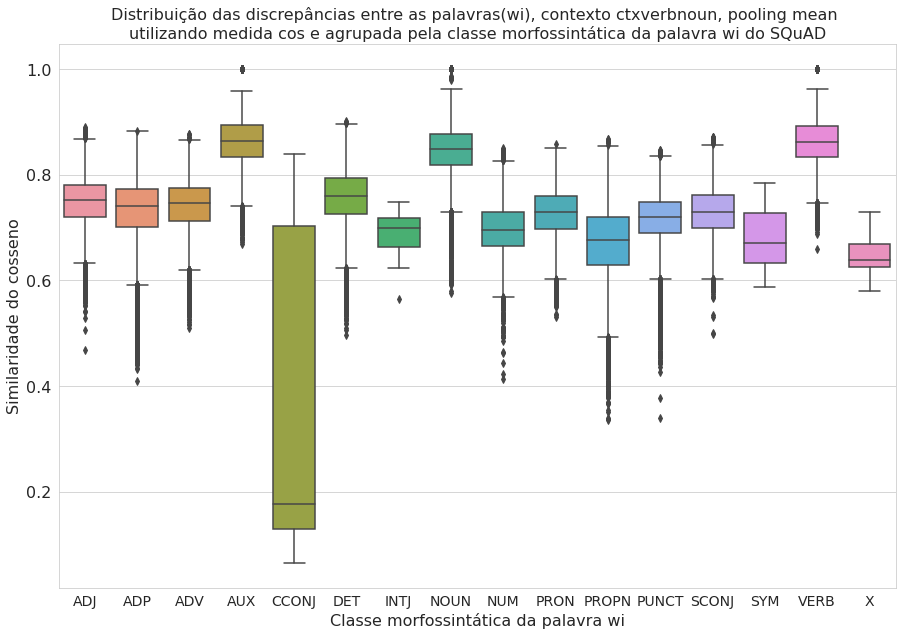

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   20357.000000 0.727010 0.061506 0.274008 0.694441 0.737575 0.769906   
ADP   52155.000000 0.732534 0.057945 0.409533 0.700162 0.740265 0.772832   
ADV   10272.000000 0.735501 0.054790 0.414932 0.708964 0.744202 0.772362   
AUX   15843.000000 0.862152 0.049099 0.668007 0.832792 0.864512 0.894616   
CCONJ  3193.000000 0.385919 0.287271 0.064910 0.129348 0.176504 0.702754   
DET   41244.000000 0.755535 0.053569 0.492504 0.721239 0.758301 0.792645   
INTJ     29.000000 0.656971 0.035865 0.564175 0.638407 0.657228 0.679841   
NOUN  67194.000000 0.831872 0.061682 0.441195 0.802945 0.842014 0.873442   
NUM    4471.000000 0.680163 0.066410 0.413024 0.640961 0.685069 0.720981   
PRON  22863.000000 0.725302 0.046097 0.521843 0.695106 0.728813 0.758194   
PROPN 31599.000000 0.629202 0.074421 0.315034 0.583130 0.634138 0.681311   
PUNCT 33554.000000 0.716167 0.045807 0.339278 0.689465 0.719881 0.747476   
SCONJ  7701.000000 0.726950 0.049096 0.498960 0.697618 0.729009 0.761148   
SYM     127.000000 0.681816 0.054485 0.588124 0.633601 0.669929 0.727924   
VERB  28822.000000 0.857425 0.054446 0.561536 0.828321 0.858632 0.890667   
X        45.000000 0.587057 0.052616 0.502611 0.545781 0.597410 0.625375   

           max  
pos_i           
ADJ   0.877795  
ADP   0.882807  
ADV   0.877483  
AUX   1.000000  
CCONJ 0.839183  
DET   0.901307  
INTJ  0.735266  
NOUN  1.000000  
NUM   0.850336  
PRON  0.857496  
PROPN 0.866805  
PUNCT 0.846250  
SCONJ 0.871772  
SYM   0.784659  
VERB  1.000000  
X     0.730056

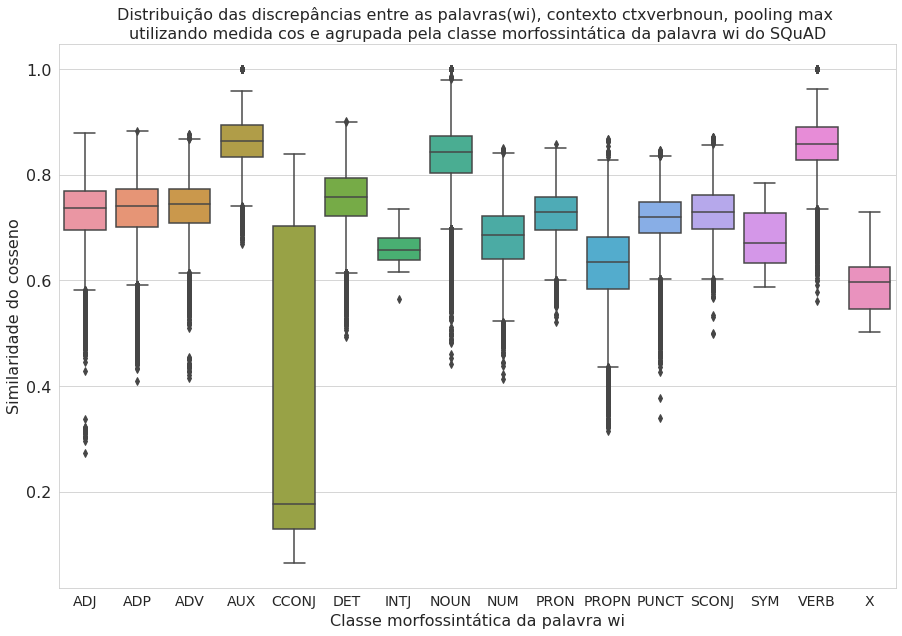

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20357.000000 27.489537 3.681698 15.949810 25.061241 27.061144 29.414457   
ADP   52155.000000 27.497360 3.209463 17.099379 25.384277 27.180721 29.306336   
ADV   10272.000000 29.015513 3.901864 19.744852 26.286882 28.382461 31.093262   
AUX   15843.000000 19.336228 4.222695  0.000000 17.443370 19.691660 21.755964   
CCONJ  3193.000000 35.109078 5.876414 21.661776 29.668221 37.612881 39.586479   
DET   41244.000000 25.796034 3.136471 15.521487 23.693976 25.678901 27.740757   
INTJ     29.000000 33.117863 4.621954 28.198931 30.979235 32.245693 33.514462   
NOUN  67194.000000 21.265510 3.583899  0.000000 19.079908 21.190631 23.377262   
NUM    4471.000000 30.222589 3.793444 19.972944 27.870808 29.961958 32.541241   
PRON  22863.000000 27.769735 2.761366 19.962072 25.898603 27.531429 29.394699   
PROPN 31599.000000 30.767993 4.027190 19.634304 28.006186 30.432438 33.045841   
PUNCT 33554.000000 27.469403 2.632596 19.767048 25.743280 27.194946 28.914918   
SCONJ  7701.000000 27.975605 3.059732 18.527853 25.953028 27.827438 29.714735   
SYM     127.000000 30.703046 1.637835 27.399889 29.444947 30.882751 32.057920   
VERB  28822.000000 21.356176 5.214789  0.000000 19.035048 21.779977 24.332668   
X        45.000000 31.826539 2.100513 28.288782 30.736506 31.562151 32.374325   

            max  
pos_i            
ADJ   49.899010  
ADP   51.660648  
ADV   50.718937  
AUX   36.433296  
CCONJ 56.015049  
DET   47.537575  
INTJ  50.258076  
NOUN  41.115711  
NUM   51.641216  
PRON  50.237045  
PROPN 53.150841  
PUNCT 53.359669  
SCONJ 43.329067  
SYM   33.813438  
VERB  39.285553  
X     42.532936

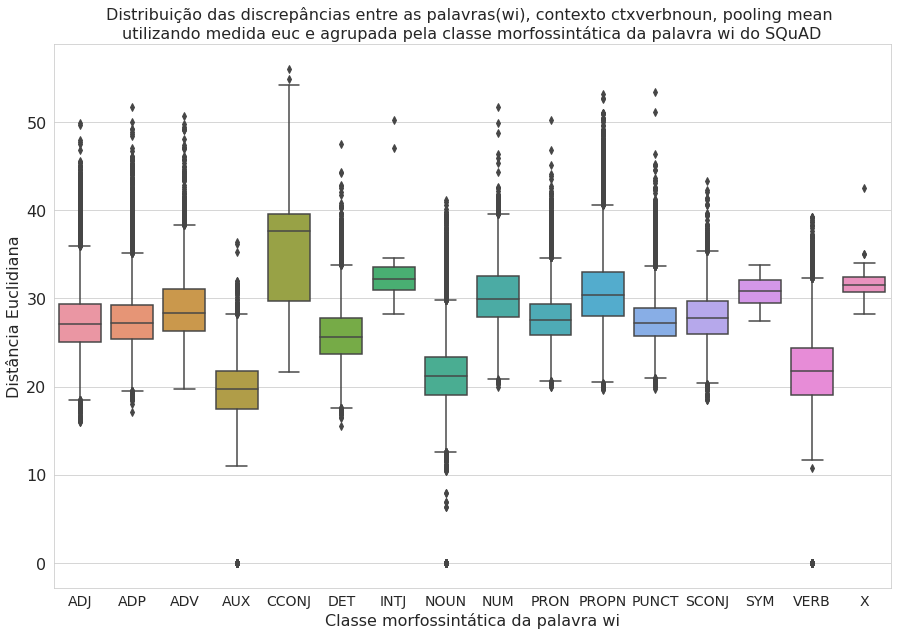

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   20357.000000 28.841480 3.791529 18.593786 26.262054 28.312592 30.802366   
ADP   52155.000000 27.503029 3.214543 17.099379 25.386895 27.184233 29.309917   
ADV   10272.000000 29.197127 3.927134 19.744852 26.428554 28.540167 31.283317   
AUX   15843.000000 19.336228 4.222695  0.000000 17.443370 19.691660 21.755964   
CCONJ  3193.000000 35.109078 5.876414 21.661776 29.668221 37.612881 39.586479   
DET   41244.000000 25.960342 3.221113 15.521487 23.791671 25.829796 28.038228   
INTJ     29.000000 34.689584 4.343937 28.198931 32.668800 33.623905 35.506775   
NOUN  67194.000000 22.191029 4.134466  0.000000 19.580528 21.851637 24.485620   
NUM    4471.000000 31.301358 3.963869 19.972944 28.945900 30.962297 33.705854   
PRON  22863.000000 27.852116 2.792807 19.962072 25.968415 27.585247 29.466795   
PROPN 31599.000000 33.388441 4.013035 20.475227 30.557249 33.061420 35.858061   
PUNCT 33554.000000 27.469394 2.632513 19.767048 25.743280 27.194946 28.914918   
SCONJ  7701.000000 28.010598 3.065125 18.527853 25.973595 27.845865 29.744350   
SYM     127.000000 30.703046 1.637835 27.399889 29.444947 30.882751 32.057920   
VERB  28822.000000 21.806291 5.323140  0.000000 19.461892 22.199906 24.861372   
X        45.000000 35.317318 2.248851 28.288782 33.863960 35.695847 36.774826   

            max  
pos_i            
ADJ   51.993923  
ADP   51.660648  
ADV   50.718937  
AUX   36.433296  
CCONJ 56.015049  
DET   47.537575  
INTJ  50.258076  
NOUN  42.399506  
NUM   51.641216  
PRON  50.237045  
PROPN 55.353260  
PUNCT 53.359669  
SCONJ 43.329067  
SYM   33.813438  
VERB  39.285553  
X     42.532936

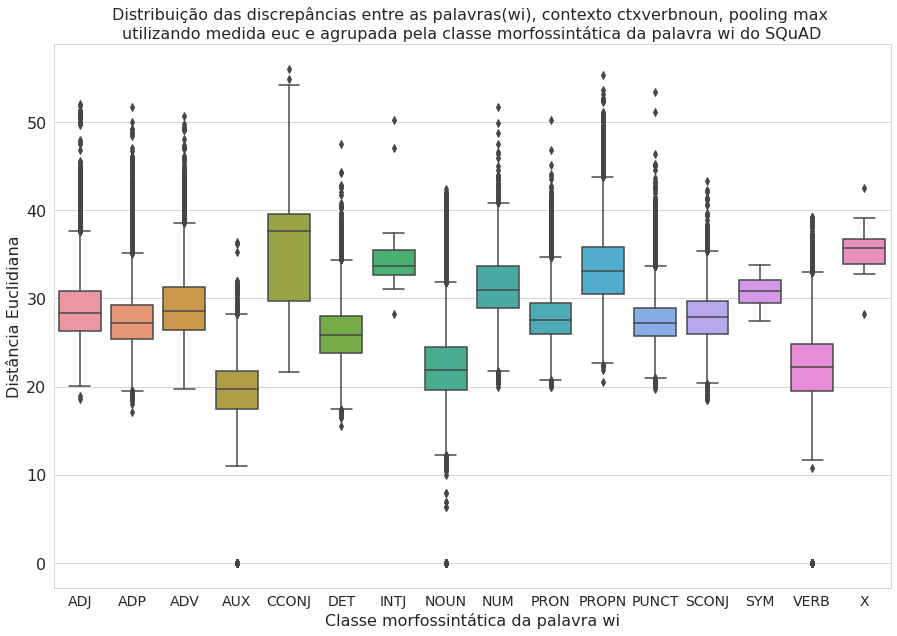

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20357.000000 1293.248828 160.666765  746.653076 1182.864990 1283.034424   
ADP   52155.000000 1336.516958 150.159282  840.207031 1236.663818 1323.334229   
ADV   10272.000000 1388.296667 164.635975  931.338562 1274.235748 1368.066467   
AUX   15843.000000  924.788839 200.826905    0.000000  836.289246  943.214233   
CCONJ  3193.000000 1344.775866 133.306069 1052.570068 1241.136230 1315.285400   
DET   41244.000000 1248.911312 147.871635  747.265503 1149.180908 1244.342102   
INTJ     29.000000 1566.751873 108.632436 1386.895508 1494.778687 1550.217773   
NOUN  67194.000000 1002.584570 162.707964    0.000000  903.306549 1000.295410   
NUM    4471.000000 1447.428715 174.040437  982.632324 1336.168823 1443.813232   
PRON  22863.000000 1347.222588 130.680328  979.378479 1257.395142 1338.892578   
PROPN 31599.000000 1437.005867 173.827005  931.319641 1313.847046 1421.978760   
PUNCT 33554.000000 1336.319571 120.843597  977.549255 1256.020721 1326.393494   
SCONJ  7701.000000 1363.515267 150.346213  888.723145 1261.920288 1355.853638   
SYM     127.000000 1469.997359  68.671662 1314.907959 1431.908875 1482.486328   
VERB  28822.000000 1016.854813 242.659261    0.000000  911.917786 1041.781555   
X        45.000000 1416.195766  81.936082 1330.310059 1380.466187 1397.781738   

              75%         max  
pos_i                          
ADJ   1391.527588 2063.817383  
ADP   1422.641724 2315.715332  
ADV   1482.778931 2228.319336  
AUX   1040.394104 1641.996948  
CCONJ 1420.141235 2034.381348  
DET   1342.072205 2080.159668  
INTJ  1610.817017 1879.806885  
NOUN  1099.508942 1794.353516  
NUM   1546.260559 2418.588623  
PRON  1427.412415 2013.358643  
PROPN 1542.767639 2298.271729  
PUNCT 1406.624420 2365.271973  
SCONJ 1451.606567 2054.363770  
SYM   1521.631470 1599.374878  
VERB  1158.999359 1729.329346  
X     1415.670898 1791.551514

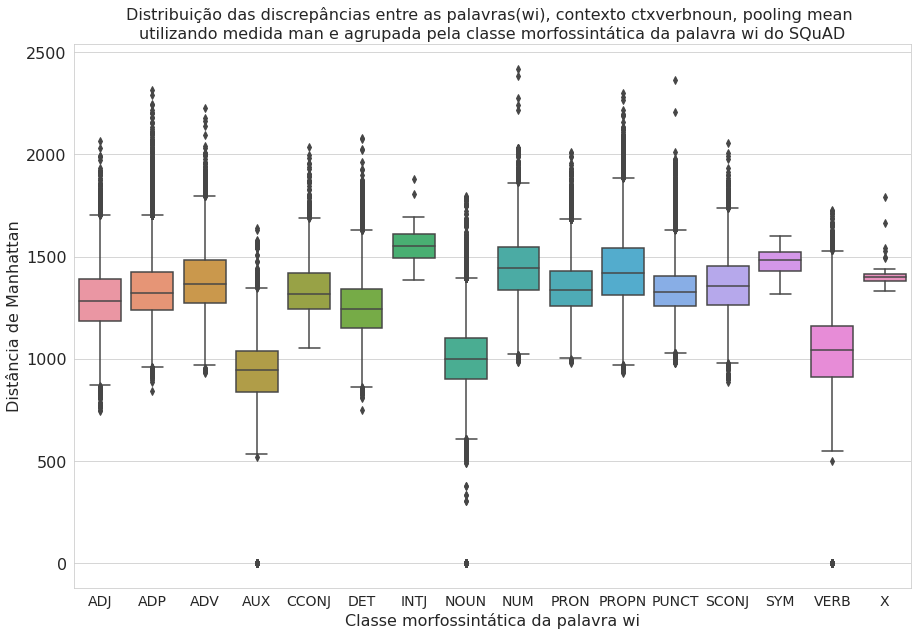

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   20357.000000 1358.140439 170.551659  875.959412 1244.805908 1337.236694   
ADP   52155.000000 1336.794480 150.343264  840.207031 1236.922913 1323.488159   
ADV   10272.000000 1396.985327 164.847191  945.467773 1282.511688 1374.423828   
AUX   15843.000000  924.788839 200.826905    0.000000  836.289246  943.214233   
CCONJ  3193.000000 1344.775866 133.306069 1052.570068 1241.136230 1315.285400   
DET   41244.000000 1256.709015 151.801952  747.265503 1153.805450 1251.583130   
INTJ     29.000000 1646.927882 101.248840 1386.895508 1597.326294 1644.328613   
NOUN  67194.000000 1046.847574 191.346434    0.000000  927.599579 1033.928345   
NUM    4471.000000 1500.445056 185.613614  986.167847 1388.306091 1481.467773   
PRON  22863.000000 1350.622737 131.362646  979.378479 1260.479248 1340.249268   
PROPN 31599.000000 1564.550532 193.318920  974.971375 1427.205200 1547.315308   
PUNCT 33554.000000 1336.343168 120.889203  977.549255 1256.020721 1326.403259   
SCONJ  7701.000000 1365.318554 150.737953  888.723145 1263.216553 1356.371338   
SYM     127.000000 1469.997359  68.671662 1314.907959 1431.908875 1482.486328   
VERB  28822.000000 1038.689677 249.076269    0.000000  931.430756 1062.251892   
X        45.000000 1546.373655  73.150035 1330.310059 1496.890015 1549.787842   

              75%         max  
pos_i                          
ADJ   1455.727783 2444.037109  
ADP   1422.825317 2315.715332  
ADV   1491.405884 2228.319336  
AUX   1040.394104 1641.996948  
CCONJ 1420.141235 2034.381348  
DET   1356.400940 2080.159668  
INTJ  1714.158325 1879.806885  
NOUN  1151.485229 2235.998047  
NUM   1598.858215 2418.588623  
PRON  1429.854370 2013.358643  
PROPN 1685.277832 2407.231934  
PUNCT 1406.631866 2365.271973  
SCONJ 1453.134766 2054.363770  
SYM   1521.631470 1599.374878  
VERB  1183.850525 1762.138916  
X     1577.847168 1791.551514

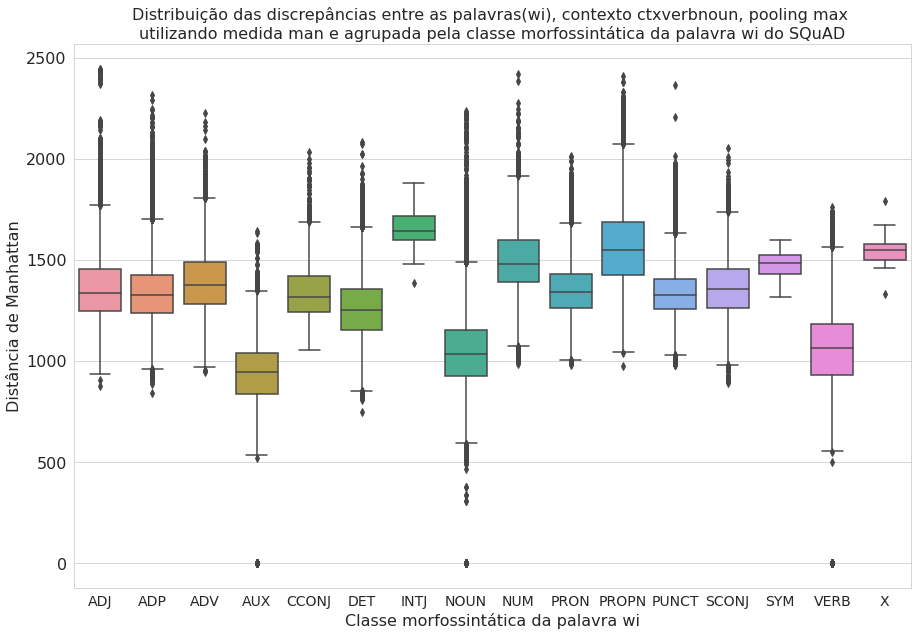

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/340095 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

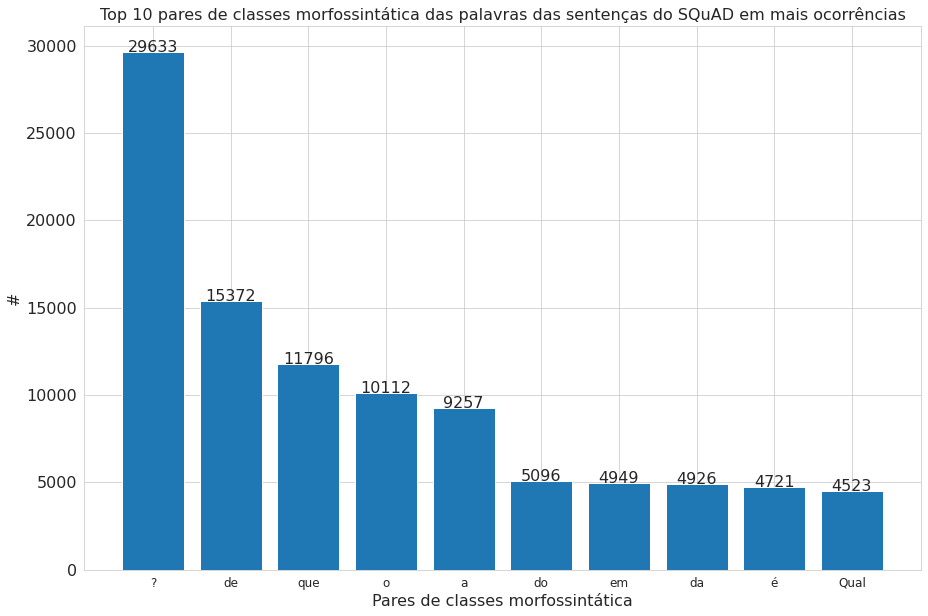

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do SQuAD em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 28822


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count     28822.000000     28822.000000    28822.000000    28822.000000   
mean          0.803526        25.672197     1239.004202        0.797706   
std           0.040361         3.868382      150.185957        0.040121   
min           0.588625        12.059925      778.337160        0.588625   
25%           0.778519        23.136622     1136.391800        0.773984   
50%           0.804714        25.586034     1234.577900        0.800429   
75%           0.830679        27.960104     1332.568025        0.825269   
max           0.947553        46.314487     1847.138700        0.919745   

       euc_ctxall_max  man_ctxall_max  
count    28822.000000    28822.000000  
mean        26.102668     1239.004202  
std          3.556526      150.185957  
min         15.788789      778.337160  
25%         23.679472     1136.391800  
50%         25.860943     1234.577900  
75%         28.198838     1332.568025  
max         46.314487     1847.138700

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/28822 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 4734
      2        4 3766
      3        3 3735
      4        6 3094
      5        5 2922
      6        7 2514
      7        1 1874
      8        8 1576
      9        9 1245
     10       10  833
     11       11  774
     12       12  513
     13       13  347
     14       14  262
     15       15  221
     16       16  129
     17       17   63
     18       20   61
     19        0   58
     20       18   41


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.052159592509269714
Limite superior             : 0.9089183285832405
Limite inferior             : 0.7002799585461617


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 34 de 28822 ( 0.0011796544306432587 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 309 de 28822 ( 0.010720977031434322 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  343 de 28822 ( 0.01190063146207758 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9475526213645936 bambaataa
         que estilo de música afrika bambaataa tocava?

 2 0.9420311450958252 escandaliza
         Que comportamento escandaliza a cidade?

 3 0.9378901124000548 conecta
         USB conecta o que?

 4 0.937092661857605 torna-se
         Quando homens perde / n /, torna-se qual palavra?

 5 0.9343878030776978 dissipadas
         Onde as perdas são dissipadas?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5886249542236328 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam capazes ?

 2 0.6069617867469788 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam poucos ?

 3 0.6122475862503052 tornasse
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?

 4 0.6270434260368347 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam úteis ?

 5 0.6271599531173706 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam suficientes ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que acontece com os plugues fusíveis de chumbo se o nível da água do fogo baixo ?
       1 0.7002537250518799 acontece

 2 Como são vistas as escolas no Havaí e em Salt Lake City ?
       1 0.7001508474349976 vistas

 3 Qual era o nome do grupo que já usou o West Rock como esconderijo , conhecido coloquialmente como " Os Três Juízes ? "
       1 0.7524324655532837 usou
       2 0.7001104354858398 conhecido

 4 Qual era o nome do grupo que já utilizou o West Rock como esconderijo , conhecido coloquialmente como " Os Três Juízes ? "
       1 0.7488467693328857 utilizou
       2 0.700056791305542 conhecido

 5 Qual era o nome do grupo que já utilizou o West Rock como esconderijo, conhecido coloquialmente como "Os Três Juízes?"
       1 0.7488467693328857 utilizou
       2 0.700056791305542 conhecido


##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05128510296344757
Limite superior             : 0.9021962955594063
Limite inferior             : 0.697055883705616


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 9 de 28822 ( 0.00031226146693498025 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 472 de 28822 ( 0.016376379154812295 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  481 de 28822 ( 0.016688640621747276 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9197447299957277 é
         O budismo é em que área ?

 2 0.9149163961410522 está
         O budismo está em que área ?

 3 0.9124686121940612 fizeram
         Que perguntas fizeram às homossexuais ?

 4 0.9101157188415528 é
         O budismo é que tipo de divindade ?

 5 0.9098654389381408 fazer
         Quem pode fazer qualquer brigada ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5886249542236328 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam capazes ?

 2 0.6019488573074341 matricularam
         Para os calouros que se matricularam na turma de 2017, qual era o intervalo interquartil do SAT para matemática?

 3 0.6069617867469788 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam poucos ?

 4 0.6117409467697144 fazê-los
         Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?

 5 0.6122475862503052 tornasse
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que trabalho publicado em 1934 Popper baseia suas teorias centradas na falsificação ?
       1 0.7884750962257385 publicado
       2 0.7725186347961426 baseia
       3 0.6970244646072388 centradas

 2 O estudo de 2008 anterior à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão , assim como de sua família e contemporâneos , tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais ?
       1 0.7804412841796875 tinham
       2 0.724431574344635 coletados
       3 0.6969717144966125 constatou

 3 Qual é a característica do sulfeto de zinco que o fazem perigoso nas telas de televisão ?
       1 0.6969541311264038 fazem

 4 Que termo é dado às favelas estabelecidas nas margens do sul de Yarra?
       1 0.7490791082382202 estabelecidas
       2 0.6969510316848755 dado

 5 Que termo é dado às favelas estabelecidas nas margens do sul de Yarra ?
       1 0.7490791082382202 estabelecidas
       2 0.6969510316848755 dado


##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.823482036590573
Limite superior             : 35.19532704353332
Limite inferior             : 15.901398897171026


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 462 de 28822 ( 0.016029421969328984 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 95 de 28822 ( 0.003296093262091458 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  557 de 28822 ( 0.019325515231420443 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 46.31448745727539 ado
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 2 44.219608306884766 ido
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?

 3 42.84307861328125 tocaram
         Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?

 4 42.57329559326172 Deixou
         Quando o baixo saxão Deixou de fazer parte da língua estoniana ?

 5 42.27388381958008 toque
         Em que dia a empresa que toque a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.059925079345703 escandaliza
         Que comportamento escandaliza a cidade?

 2 12.591123580932615 bambaataa
         que estilo de música afrika bambaataa tocava?

 3 12.763445854187012 torna-se
         Quando homens perde / n /, torna-se qual palavra?

 4 12.84880828857422 dissipadas
         Onde as perdas são dissipadas?

 5 13.337479591369627 conecta
         USB conecta o que?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?
       1 46.31448745727539 ado
       2 28.380563735961918 viajou
       3 26.39829444885254 visitar

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?
       1 44.219608306884766 ido
       2 27.793832778930664 viajou
       3 26.089256286621094 visitar

 3 Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 42.84307861328125 tocaram
       2 27.42961311340332 abriu

 4 Quando o baixo saxão Deixou de fazer parte da língua estoniana ?
       1 42.57329559326172 Deixou
       2 28.607301712036133 fazer

 5 Em que dia a empresa que toque a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 42.27388381958008 toque
       2 27.40

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.519366264343262
Limite superior             : 34.97788763046265
Limite inferior             : 16.9004225730896


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 507 de 28822 ( 0.017590729304003887 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 20 de 28822 ( 0.0006939143709666227 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  527 de 28822 ( 0.01828464367497051 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 46.31448745727539 ado
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 2 44.219608306884766 ido
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?

 3 42.84307861328125 tocaram
         Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?

 4 42.57329559326172 Deixou
         Quando o baixo saxão Deixou de fazer parte da língua estoniana ?

 5 42.27388381958008 toque
         Em que dia a empresa que toque a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.788788795471191 fazer
         Quem pode fazer qualquer brigada ?

 2 16.071407318115234 fizeram
         Que perguntas fizeram às homossexuais ?

 3 16.14002799987793 existem
         Quantas classes primárias existem ?

 4 16.22917366027832 existiam
         Quantas classes primárias existiam ?

 5 16.303136825561523 está
         O budismo está em que área ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?
       1 46.31448745727539 ado
       2 28.380563735961918 viajou
       3 26.39829444885254 visitar

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?
       1 44.219608306884766 ido
       2 27.793832778930664 viajou
       3 26.089256286621094 visitar

 3 Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 42.84307861328125 tocaram
       2 27.42961311340332 abriu

 4 Quando o baixo saxão Deixou de fazer parte da língua estoniana ?
       1 42.57329559326172 Deixou
       2 28.607301712036133 fazer

 5 Em que dia a empresa que toque a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 42.27388381958008 toque
       2 27.40

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 209.32337499999994
Limite superior             : 1635.6693624999998
Limite inferior             : 798.3758625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 284 de 28822 ( 0.009853584067726042 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 205 de 28822 ( 0.0071126223024078825 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  489 de 28822 ( 0.016966206370133925 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1847.1387 descobriu
         Quem descobriu que mirar diretamente no GameCube dar uma nova sensação ao jogo ?

 2 1844.9607 terminando
         Aqui e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?

 3 1843.7712 fazer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?

 4 1832.1921 querendo
         O que Hegel querendo dizer com " objeto " ?

 5 1827.0354 terminando
         Indo e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 587.2842 escandaliza
         Que comportamento escandaliza a cidade?

 2 610.6566 torna-se
         Quando homens perde / n /, torna-se qual palavra?

 3 614.02783 dissipadas
         Onde as perdas são dissipadas?

 4 616.7449 bambaataa
         que estilo de música afrika bambaataa tocava?

 5 635.54443 sintonizados
         Como são geralmente os mandocelos sintonizados?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem descobriu que mirar diretamente no GameCube dar uma nova sensação ao jogo ?
       1 1847.1387 descobriu
       2 1443.6293 dar
       3 1100.8832 mirar

 2 Aqui e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?
       1 1844.9607 terminando
       2 1236.8016 argumenta

 3 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?
       1 1843.7712 fazer
       2 1331.7351 usado

 4 O que Hegel querendo dizer com " objeto " ?
       1 1832.1921 querendo
       2 1397.0149 dizer

 5 Indo e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?
       1 1827.0354 terminando
       2 1670.9434 Indo
       3 1269.1941 argumenta


##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 196.17622500000016
Limite superior             : 1626.8323625000003
Limite inferior             : 842.1274624999996


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 307 de 28822 ( 0.010651585594337659 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 39 de 28822 ( 0.0013531330233849143 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  346 de 28822 ( 0.012004718617722574 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1847.1387 descobriu
         Quem descobriu que mirar diretamente no GameCube dar uma nova sensação ao jogo ?

 2 1844.9607 terminando
         Aqui e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?

 3 1843.7712 fazer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?

 4 1832.1921 querendo
         O que Hegel querendo dizer com " objeto " ?

 5 1827.0354 terminando
         Indo e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 778.33716 fazer
         Quem pode fazer qualquer brigada ?

 2 784.1253 pode
         Quem pode controlar qualquer brigada ?

 3 785.04736 existem
         Quantas classes primárias existem ?

 4 785.9784 era
         Onde era a Universidade de Paris ?

 5 786.3459 existiam
         Quantas classes primárias existiam ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem descobriu que mirar diretamente no GameCube dar uma nova sensação ao jogo ?
       1 1847.1387 descobriu
       2 1443.6293 dar
       3 1387.1101 mirar

 2 Aqui e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?
       1 1844.9607 terminando
       2 1236.8016 argumenta

 3 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?
       1 1843.7712 fazer
       2 1331.7351 usado

 4 O que Hegel querendo dizer com " objeto " ?
       1 1832.1921 querendo
       2 1397.0149 dizer

 5 Indo e terminando com que anos Lee argumenta que as regras do Império eram incompetentes ?
       1 1827.0354 terminando
       2 1670.9434 Indo
       3 1269.1941 argumenta


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 67194


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count     67194.000000     67194.000000     67194.000000    67194.000000   
mean          0.800422        23.964285      1127.249850        0.787078   
std           0.043708         3.680312       162.009393        0.045273   
min           0.574900        10.079731       494.700870        0.523323   
25%           0.775372        21.849502      1032.662700        0.764000   
50%           0.802012        23.753217      1121.452100        0.793194   
75%           0.827633        25.909436      1222.908850        0.818380   
max           0.958752        46.167938      1941.543000        0.912274   

       euc_ctxall_max  man_ctxall_max  
count    67194.000000    67194.000000  
mean        24.902088     1172.857262  
std          3.333178      150.015309  
min         14.963335      703.497300  
25%         22.658449     1070.294475  
50%         24.420317     1153.070700  
75%         26.670372     1256.300300  
max         46.167938     2191.228500

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/67194 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        1 8662
      2        3 8133
      3        4 6797
      4        5 6092
      5        6 5826
      6        7 5591
      7        2 5435
      8        8 4190
      9        9 3666
     10       10 2914
     11       11 2429
     12       13 1635
     13       12 1505
     14       14  895
     15       15  830
     16        0  534
     17       17  483
     18       16  463
     19       19  315
     20       18  210


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0522608757019043
Limite superior             : 0.9060238301753998
Limite inferior             : 0.6969803273677826


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 637 de 67194 ( 0.009480013096407417 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1080 de 67194 ( 0.016072863648540048 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1717 de 67194 ( 0.025552876744947467 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9587522149086 lápis-lazúli
         De qual país o lápis-lazúli foi feito ?

 2 0.9583052396774292 lápis-lazúli
         De qual país o lápis-lazúli foi roubado ?

 3 0.9582912921905518 lápis-lazúli
         De qual país o lápis-lazúli foi descoberto ?

 4 0.9582721590995787 lápis-lazúli
         De qual país o lápis-lazúli foi recebido ?

 5 0.9582644701004028 lápis-lazúli
         De qual país o lápis-lazúli foi retirado ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5749004483222961 termos
         Em termos de exigência , que tipo de serviço seria necessário para a aprovação ?

 2 0.5752295851707458 termos
         Em termos de exigência , que tipo de serviço seria necessário para a certificação ?

 3 0.5805131793022156 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 4 0.5825514793395996 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 5 0.5826498866081238 termos
         Em que classificação é uma pessoa que corresponde ao seu senso exclusivo de si e se define apenas em termos de engajamento social ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem Jacksonville ia com suprimentos durante a guerra revolucionária ?
       1 0.8413779735565186 suprimentos
       2 0.6969682574272156 guerra

 2 Que outra empresa de TV a cabo tinha o interesse de sair da NBCUniversal ?
       1 0.87412428855896 NBCUniversal
       2 0.8234735727310181 empresa
       3 0.7488933205604553 interesse
       4 0.7260657548904419 TV
       5 0.6969561576843262 cabo

 3 Apesar da aprovação do FDA, quanto mais chances de morrer são os pacientes que tomam bedaquilina além do regime padrão de TB?
       1 0.839343786239624 bedaquilina
       2 0.7929744720458984 regime
       3 0.7712827920913696 padrão
       4 0.7508450150489807 pacientes
       5 0.7222207188606262 aprovação
       6 0.6969374418258667 chances

 4 Quantos soldados europeus tomaram em março de 2008 devido à contra-insurgência ?
       1 0.8806991577148438 contra-insurgência
       2 0.7968377470970154 soldados
       3 0.6968809366226196 março

 5 Quem foi o Secretário de Guerra que 

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0543801486492157
Limite superior             : 0.8999500721693039
Limite inferior             : 0.6824294775724411


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 14 de 67194 ( 0.0002083519361847784 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1757 de 67194 ( 0.02614816799118969 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1771 de 67194 ( 0.026356519927374467 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9122740626335144 tratado
         Que tratado inclui o tratado constitucional ?

 2 0.9110488891601562 tratado
         Que tratado e o tratado constitucional ?

 3 0.90836501121521 tratado
         Que tratado compõe o tratado constitucional ?

 4 0.9082342982292176 tratado
         Que tratado representa o tratado constitucional ?

 5 0.9067754149436952 problema
         Qual foi o problema ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5233234167098999 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?

 2 0.5292650461196899 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 3 0.5322545766830444 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?

 4 0.5348828434944153 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos to de grupos croatas , sérvios e albaneses anticomunistas ?

 5 0.5356811881065369 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A duração típica dos relacionamentos aumenta ou passa ao longo da adolescência ?
       1 0.8510638475418091 duração
       2 0.7782680988311768 adolescência
       3 0.759951651096344 relacionamentos
       4 0.68241947889328 longo

 2 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de procurar cargos públicos com base em sua religião eram inexequíveis ?
       1 0.7691711187362671 regra
       2 0.7475770115852356 pessoas
       3 0.7351539134979248 religião
       4 0.7001692652702332 Corte
       5 0.6952679753303528 cargos
       6 0.6942970752716064 base
       7 0.682402491569519 cláusulas

 3 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de obter cargos públicos com base em sua religião eram inexequíveis ?
       1 0.7675856351852417 regra
       2 0.7533536553382874 pessoas
       3 0.736758291721344 religião
       4 0.7237104177474976 base
       5 0.7036667466163635 cargos
       6 0.6958593726158142 Corte
       7

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.059934616088864
Limite superior             : 31.999338150024407
Limite inferior             : 15.759599685668954


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1748


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1015 de 67194 ( 0.015105515373396433 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2763 de 67194 ( 0.04111974283418162 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 46.16793823242188 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?

 2 45.91826248168945 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?

 3 45.69793319702149 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?

 4 45.61933898925781 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos encontro de grupos croatas , sérvios e albaneses anticomunistas ?

 5 45.57243347167969 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.079730987548828 lápis-lazúli
         De qual país o lápis-lazúli foi retirado ?

 2 10.08232307434082 lápis-lazúli
         De qual país o lápis-lazúli foi recebido ?

 3 10.11815071105957 lápis-lazúli
         De qual país o lápis-lazúli foi descoberto ?

 4 10.161538124084473 lápis-lazúli
         De qual país o lápis-lazúli foi levado ?

 5 10.18214225769043 lápis-lazúli
         De qual país o lápis-lazúli foi original ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?
       1 46.16793823242188 protestos
       2 28.80506706237793 líder
       3 28.727867126464844 sérvios
       4 28.327152252197266 ano
       5 24.175844192504883 grupos
       6 22.855064392089844 albaneses

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?
       1 45.91826248168945 protestos
       2 28.863914489746094 ano
       3 28.294931411743164 sérvios
       4 24.929805755615234 grupos
       5 21.736576080322266 albaneses

 3 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?
       1 45.69793319702149 protestos
       2 28.59158515930176 ano
       3 28.541566848754883 sérvios
       4 24.327516555786133 grupos
       5 22.410682678222656 albaneses

 4 Em q

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.0119228363037145
Limite superior             : 32.68825626373292
Limite inferior             : 16.64056491851806


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1768


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 22 de 67194 ( 0.00032741018543322323 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1790 de 67194 ( 0.026639283269339526 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 46.16793823242188 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?

 2 45.91826248168945 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?

 3 45.69793319702149 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?

 4 45.61933898925781 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos encontro de grupos croatas , sérvios e albaneses anticomunistas ?

 5 45.57243347167969 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.963335037231444 questão
         Como é essa questão ?

 2 15.177227020263672 problema
         Qual foi o problema ?

 3 15.469718933105469 tratado
         Que tratado inclui o tratado constitucional ?

 4 15.801834106445312 resultado
         Qual foi o resultado ?

 5 15.84252643585205 tratado
         Que tratado e o tratado constitucional ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?
       1 46.16793823242188 protestos
       2 34.85051345825195 albaneses
       3 31.32648468017578 sérvios
       4 28.80506706237793 líder
       5 28.327152252197266 ano
       6 24.175844192504883 grupos

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?
       1 45.91826248168945 protestos
       2 34.621376037597656 albaneses
       3 30.78049659729004 sérvios
       4 28.863914489746094 ano
       5 24.929805755615234 grupos

 3 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?
       1 45.69793319702149 protestos
       2 34.7639274597168 albaneses
       3 30.99895668029785 sérvios
       4 28.59158515930176 ano
       5 24.327516555786133 grupos

 4 Em que ano

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 190.24614999999994
Limite superior             : 1508.278075
Limite inferior             : 747.2934750000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1044


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1040 de 67194 ( 0.015477572402297824 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2084 de 67194 ( 0.03101467392921987 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1941.543 geração
         Que geração se as baterias do iPod serem afixadas com cola ?

 2 1898.4547 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?

 3 1895.4746 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos pedido de grupos croatas , sérvios e albaneses anticomunistas ?

 4 1875.2124 geração
         Que geração de as baterias do iPod serem afixadas com cola ?

 5 1850.7256 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos pressão de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 494.70087 lápis-lazúli
         De qual país o lápis-lazúli foi levado ?

 2 495.36786 lápis-lazúli
         De qual país o lápis-lazúli foi recebido ?

 3 495.8353 lápis-lazúli
         De qual país o lápis-lazúli foi descoberto ?

 4 496.44696 lápis-lazúli
         De qual país o lápis-lazúli foi retirado ?

 5 498.85065 lápis-lazúli
         De qual país o lápis-lazúli foi roubado ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Que geração se as baterias do iPod serem afixadas com cola ?
       1 1941.543 geração
       2 1168.196 baterias
       3 1164.918 cola
       4 893.1879 iPod

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?
       1 1898.4547 protestos
       2 1446.7773 convite
       3 1364.3479 ano
       4 1196.7576 sérvios
       5 1119.5403 grupos
       6 978.464 albaneses

 3 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos pedido de grupos croatas , sérvios e albaneses anticomunistas ?
       1 1895.4746 protestos
       2 1372.7949 ano
       3 1197.7228 sérvios
       4 1119.7556 grupos
       5 992.327 albaneses

 4 Que geração de as baterias do iPod serem afixadas com cola ?
       1 1875.2124 geração
       2 1172.5834 cola
       3 1165.7761 baterias
       4 908.3109 iPod

 5 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos pressão de grup

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 186.00582499999973
Limite superior             : 1535.3090374999995
Limite inferior             : 791.2857375000006


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1426


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 27 de 67194 ( 0.0004018215912135012 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1453 de 67194 ( 0.021623954519748786 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2191.2285 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 2 2178.031 lápis-lazúli
         De qual país o lápis-lazúli foi escolhido ?

 3 2177.8562 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 4 2169.634 lápis-lazúli
         De qual país o lápis-lazúli foi original ?

 5 2167.4287 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 703.4973 questão
         Como é essa questão ?

 2 713.0557 problema
         Qual foi o problema ?

 3 734.6627 tratado
         Que tratado e o tratado constitucional ?

 4 735.9314 tratado
         Que tratado inclui o tratado constitucional ?

 5 745.3845 situação
         Como é essa situação ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi mesmo ?
       1 2191.2285 lápis-lazúli
       2 1179.5588 país

 2 De qual país o lápis-lazúli foi escolhido ?
       1 2178.031 lápis-lazúli
       2 1152.3358 país

 3 De qual país o lápis-lazúli foi importado?
       1 2177.8562 lápis-lazúli
       2 1257.282 país

 4 De qual país o lápis-lazúli foi original ?
       1 2169.634 lápis-lazúli
       2 1170.1992 país

 5 De qual país o lápis-lazúli foi transferido ?
       1 2167.4287 lápis-lazúli
       2 1175.3066 país


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count   340095.000000   340095.000000   340095.000000    28822.000000   
mean         0.809786       23.147593     1109.294026        0.803526   
std          0.063689        3.799373      164.173175        0.040361   
min          0.123609        9.172180      448.242980        0.588625   
25%          0.784300       20.649336     1001.471255        0.778519   
50%          0.815291       22.823093     1101.795200        0.804714   
75%          0.844283       25.237112     1209.890650        0.830679   
max          0.965054       46.385330     1961.549000        0.947553   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count    28822.000000    28822.000000    67194.000000    67194.000000   
mean        25.672197     1217.896628        0.800422       23.964285   
std          3.868382      163.844155        0.043708        3.680312   
min         12.059925      587.284200        0.574900       10.079731   
25%         23.136622     1112.360925        0.775372       21.849502   
50%         25.586034     1221.237850        0.802012       23.753217   
75%         27.960104     1321.684300        0.827633       25.909436   
max         46.314487     1847.138700        0.958752       46.167938   

                       
      man_ctxall_mean  
count    67194.000000  
mean      1127.249850  
std        162.009393  
min        494.700870  
25%       1032.662700  
50%       1121.452100  
75%       1222.908850  
max       1941.543000

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count   340095.000000    28822.000000    67194.000000
mean         0.809786        0.803526        0.800422
std          0.063689        0.040361        0.043708
min          0.123609        0.588625        0.574900
25%          0.784300        0.778519        0.775372
50%          0.815291        0.804714        0.802012
75%          0.844283        0.830679        0.827633
max          0.965054        0.947553        0.958752

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


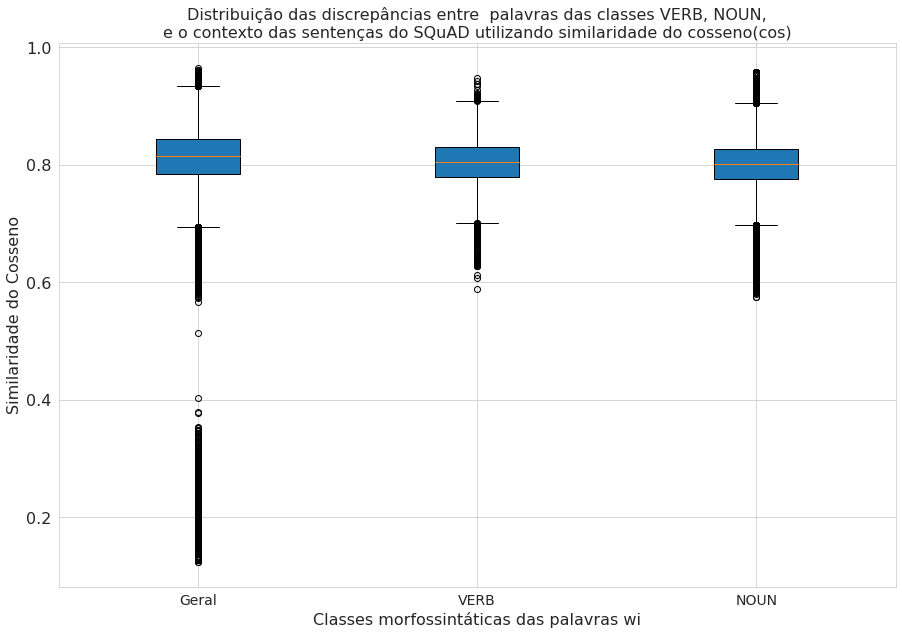

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count   340095.000000    28822.000000    67194.000000
mean        23.147593       25.672197       23.964285
std          3.799373        3.868382        3.680312
min          9.172180       12.059925       10.079731
25%         20.649336       23.136622       21.849502
50%         22.823093       25.586034       23.753217
75%         25.237112       27.960104       25.909436
max         46.385330       46.314487       46.167938

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


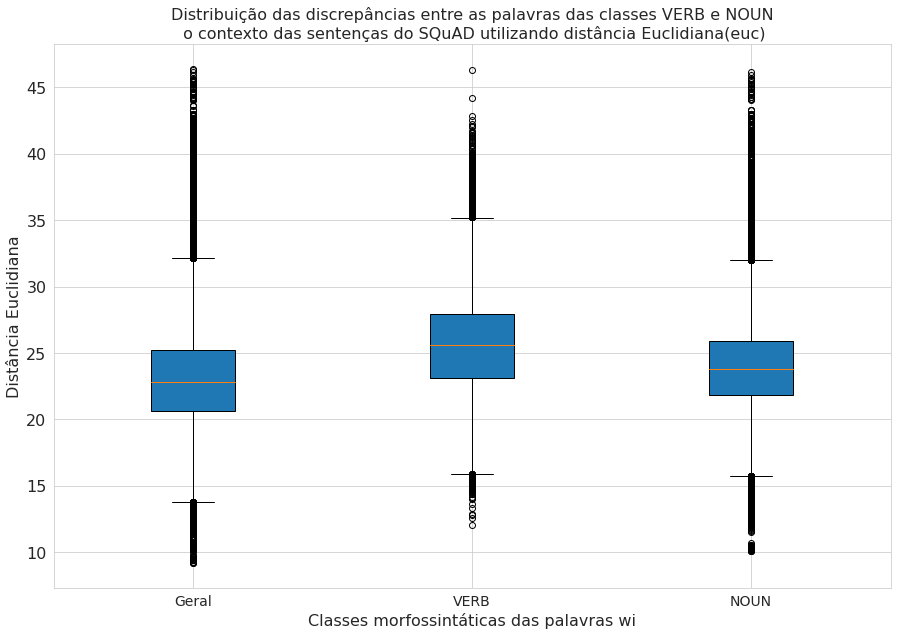

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count   340095.000000    28822.000000    67194.000000
mean      1109.294026     1217.896628     1127.249850
std        164.173175      163.844155      162.009393
min        448.242980      587.284200      494.700870
25%       1001.471255     1112.360925     1032.662700
50%       1101.795200     1221.237850     1121.452100
75%       1209.890650     1321.684300     1222.908850
max       1961.549000     1847.138700     1941.543000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


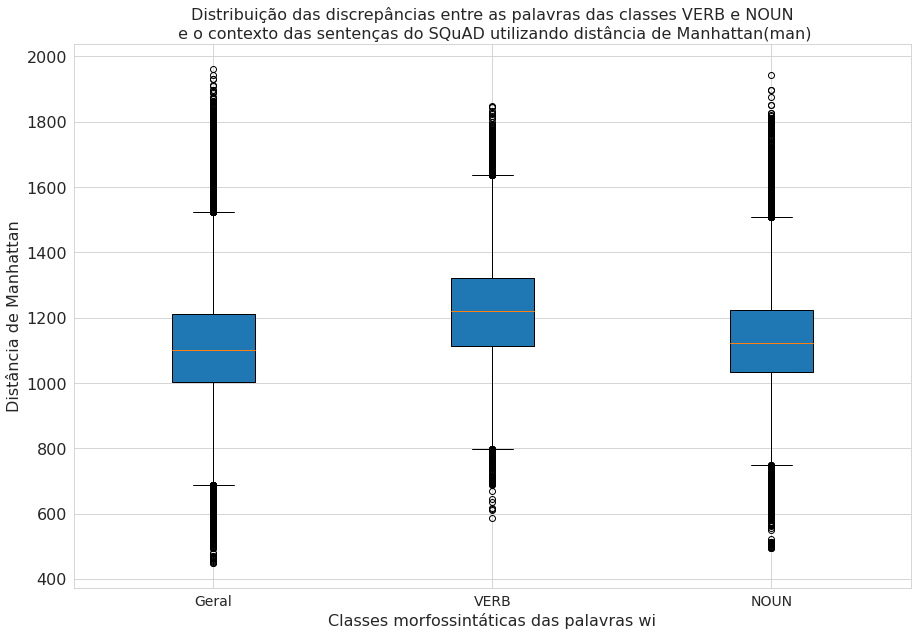

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 28822


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count       28822.000000       28822.000000      28822.000000   
mean            0.821501          24.564871          0.815614   
std             0.044448           3.648148          0.048307   
min             0.517346          13.196042          0.517346   
25%             0.797168          22.093099          0.789171   
50%             0.826732          24.406538          0.822476   
75%             0.852410          26.770092          0.849308   
max             0.936870          47.041553          0.934306   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count      28822.000000      28822.000000       28822.000000  
mean          24.991487       1189.639560        1168.932452  
std            3.554840        158.876154         161.677335  
min           13.196042        641.974240         641.974240  
25%           22.589512       1083.107050        1060.454850  
50%           24.779565       1184.334400        1165.806250  
75%           27.132053       1288.436125        1271.215275  
max           47.041553       2145.623500        2145.623500

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/28822 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 4734
      2        4 3766
      3        3 3735
      4        6 3094
      5        5 2922
      6        7 2514
      7        1 1874
      8        8 1576
      9        9 1245
     10       10  833
     11       11  774
     12       12  513
     13       13  347
     14       14  262
     15       15  221
     16       16  129
     17       17   63
     18       20   61
     19        0   58
     20       18   41


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.055242180824279785
Limite superior             : 0.9352732747793198
Limite inferior             : 0.7143045514822006


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 28822 ( 3.469571854833114e-05 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 629 de 28822 ( 0.021823606966900284 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  630 de 28822 ( 0.021858302685448614 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9368703961372375 10i
         O que foi 10i ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5173459053039551 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 0.5466500520706177 dizer
         O que Hegel querem dizer com " objeto " ?

 3 0.5548271536827087 dizer
         O que Hegel vem dizer com " objeto " ?

 4 0.5640639662742615 querem
         O que Hegel querem dizer com " objeto " ?

 5 0.5692145228385925 conhecido
         Qual é o vértice também conhecido como ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Que inseto se faz de pulgões ?
       1 0.7141987085342407 faz

 2 Uma parte reservadora de um tratado pode incluir uma declaração que significa fazer o que com suas obrigações legais ou seus efeitos ?
       1 0.8301709890365601 significa
       2 0.7916253209114075 incluir
       3 0.7801956534385681 fazer
       4 0.7141650915145874 pode

 3 Que condição climática se diz muito mais estável ?
       1 0.7140668034553528 diz

 4 Quem disse um filme chamado ' Bronx Burning ' ?
       1 0.855129063129425 chamado
       2 0.7140660285949707 disse

 5 O que um cardeal leigo não pode fazer e que não é considerado um status normal de um cardeal?
       1 0.8123294711112976 considerado
       2 0.7463185787200928 fazer
       3 0.7139999866485596 pode


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.060137033462524414
Limite superior             : 0.9395131766796112
Limite inferior             : 0.6989650428295135


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 746 de 28822 ( 0.025883006037055026 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  746 de 28822 ( 0.025883006037055026 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5173459053039551 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 0.5466500520706177 dizer
         O que Hegel querem dizer com " objeto " ?

 3 0.5548271536827087 dizer
         O que Hegel vem dizer com " objeto " ?

 4 0.5570244193077087 fazê-los
         Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?

 5 0.5640639662742615 querem
         O que Hegel querem dizer com " objeto " ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O estudo de 2008 referente à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão , assim como de sua família e contemporâneos , tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais ?
       1 0.7793740034103394 tinham
       2 0.7293828725814819 coletados
       3 0.6988942623138428 constatou

 2 Funcionários do metrô foram ordenados a bloquear as estações durante os ataques , mas por quanto tempo depois das ordens ?
       1 0.709598183631897 bloquear
       2 0.6988937854766846 ordenados

 3 Qual mercado em Melbourne bateu forte durante a crise financeira do final dos anos 2000 e resultou em preços historicamente altos e aumentos de aluguel ?
       1 0.793087363243103 bateu
       2 0.6988333463668823 resultou

 4 O estudo de 2008 relacionado à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão, assim como de sua família e contemporâneos, tinham níveis de arsênico aproximadamente quantas vezes mai

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.676992893218994
Limite superior             : 33.78558135032654
Limite inferior             : 15.077609777450562


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 428 de 28822 ( 0.014849767538685726 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 41 de 28822 ( 0.0014225244604815766 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  469 de 28822 ( 0.016272291999167302 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 47.04155349731445 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 46.16238021850586 Fez
         Que preocupação Fez com que associações e clubes nacionais discordassem dos amistosos ?

 3 44.2568473815918 dizem
         Onde as pessoas se dizem do clima ameno ?

 4 42.56647109985352 querem
         O que Hegel querem dizer com " objeto " ?

 5 42.249755859375 quero
         O que Hegel quero dizer com " objeto " ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 13.19604206085205 houve
         Sobre o que não houve controvérsia ?

 2 13.35395336151123 havia
         Sobre o que não havia controvérsia ?

 3 13.556203842163086 conecta
         USB conecta o que?

 4 13.594656944274902 moídas
         Como são também às morenas moídas ?

 5 13.694087982177734 moídas
         Como são também elas morenas moídas ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que Hegel Quer dizer com " objeto " ?
       1 47.04155349731445 Quer
       2 35.39082336425781 dizer

 2 Que preocupação Fez com que associações e clubes nacionais discordassem dos amistosos ?
       1 46.16238021850586 Fez
       2 22.29117202758789 discordassem

 3 Onde as pessoas se dizem do clima ameno ?
       1 44.2568473815918 dizem

 4 O que Hegel querem dizer com " objeto " ?
       1 42.56647109985352 querem
       2 36.6936149597168 dizer

 5 O que Hegel quero dizer com " objeto " ?
       1 42.249755859375 quero
       2 36.14473342895508 dizer


##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.54254150390625
Limite superior             : 33.945865631103516
Limite inferior             : 15.775699615478516


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 404 de 28822 ( 0.01401707029352578 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 40 de 28822 ( 0.0013878287419332453 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  444 de 28822 ( 0.015404899035459024 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 47.04155349731445 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 46.16238021850586 Fez
         Que preocupação Fez com que associações e clubes nacionais discordassem dos amistosos ?

 3 44.2568473815918 dizem
         Onde as pessoas se dizem do clima ameno ?

 4 42.56647109985352 querem
         O que Hegel querem dizer com " objeto " ?

 5 42.249755859375 quero
         O que Hegel quero dizer com " objeto " ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 13.19604206085205 houve
         Sobre o que não houve controvérsia ?

 2 13.35395336151123 havia
         Sobre o que não havia controvérsia ?

 3 14.095060348510742 há
         Sobre o que não há controvérsia?

 4 14.095060348510742 há
         Sobre o que não há controvérsia ?

 5 14.440059661865234 existe
         Sobre o que não existe controvérsia ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que Hegel Quer dizer com " objeto " ?
       1 47.04155349731445 Quer
       2 35.39082336425781 dizer

 2 Que preocupação Fez com que associações e clubes nacionais discordassem dos amistosos ?
       1 46.16238021850586 Fez
       2 27.93338966369629 discordassem

 3 Onde as pessoas se dizem do clima ameno ?
       1 44.2568473815918 dizem

 4 O que Hegel querem dizer com " objeto " ?
       1 42.56647109985352 querem
       2 36.6936149597168 dizer

 5 O que Hegel quero dizer com " objeto " ?
       1 42.249755859375 quero
       2 36.14473342895508 dizer


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 210.76042499999994
Limite superior             : 1587.3559125
Limite inferior             : 744.3142125000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 324 de 28822 ( 0.011241412809659289 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 64 de 28822 ( 0.002220525987093193 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  388 de 28822 ( 0.013461938796752481 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2145.6235 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 1987.7825 quero
         O que Hegel quero dizer com " objeto " ?

 3 1961.0493 fazer
         Quando o baixo saxão sai de fazer parte da língua estoniana ?

 4 1958.7875 fazer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?

 5 1945.0056 querem
         O que Hegel querem dizer com " objeto " ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 641.97424 houve
         Sobre o que não houve controvérsia ?

 2 647.3926 conecta
         USB conecta o que?

 3 655.17993 havia
         Sobre o que não havia controvérsia ?

 4 655.9802 moídas
         Como são também elas morenas moídas ?

 5 659.5087 moídas
         Como são também às morenas moídas ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que Hegel Quer dizer com " objeto " ?
       1 2145.6235 Quer
       2 1746.2625 dizer

 2 O que Hegel quero dizer com " objeto " ?
       1 1987.7825 quero
       2 1790.6191 dizer

 3 Quando o baixo saxão sai de fazer parte da língua estoniana ?
       1 1961.0493 fazer
       2 1448.3246 sai

 4 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?
       1 1958.7875 fazer
       2 1365.7002 usado

 5 O que Hegel querem dizer com " objeto " ?
       1 1945.0056 querem
       2 1803.6199 dizer


##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 205.3290750000001
Limite superior             : 1596.4297375000003
Limite inferior             : 775.1134374999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 323 de 28822 ( 0.011206717091110957 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 67 de 28822 ( 0.002324613142738186 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  390 de 28822 ( 0.013531330233849143 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2145.6235 Quer
         O que Hegel Quer dizer com " objeto " ?

 2 1987.7825 quero
         O que Hegel quero dizer com " objeto " ?

 3 1961.0493 fazer
         Quando o baixo saxão sai de fazer parte da língua estoniana ?

 4 1958.7875 fazer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?

 5 1945.0056 querem
         O que Hegel querem dizer com " objeto " ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 641.97424 houve
         Sobre o que não houve controvérsia ?

 2 655.17993 havia
         Sobre o que não havia controvérsia ?

 3 679.786 há
         Sobre o que não há controvérsia ?

 4 679.786 há
         Sobre o que não há controvérsia?

 5 698.8986 existe
         Sobre o que não existe controvérsia ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que Hegel Quer dizer com " objeto " ?
       1 2145.6235 Quer
       2 1746.2625 dizer

 2 O que Hegel quero dizer com " objeto " ?
       1 1987.7825 quero
       2 1790.6191 dizer

 3 Quando o baixo saxão sai de fazer parte da língua estoniana ?
       1 1961.0493 fazer
       2 1448.3246 sai

 4 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?
       1 1958.7875 fazer
       2 1365.7002 usado

 5 O que Hegel querem dizer com " objeto " ?
       1 1945.0056 querem
       2 1803.6199 dizer


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 67194


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count       67194.000000       67194.000000      67194.000000   
mean            0.818249          22.948073          0.804930   
std             0.049999           3.615788          0.061042   
min             0.506326          12.095321          0.455170   
25%             0.793167          20.544742          0.773738   
50%             0.825756          22.493617          0.818040   
75%             0.853237          24.869676          0.848039   
max             0.946003          42.424927          0.946003   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count      67194.000000      67194.000000       67194.000000  
mean          23.853526       1125.521526        1082.312734  
std            3.874890        180.653506         165.929097  
min           12.095321        584.524400         584.524400  
25%           21.155116        999.872090         970.134870  
50%           23.260228       1099.172000        1061.390950  
75%           26.095335       1227.841825        1173.055650  
max           42.424927       2224.537600        1963.251200

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/67194 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        1 8662
      2        3 8133
      3        4 6797
      4        5 6092
      5        6 5826
      6        7 5591
      7        2 5435
      8        8 4190
      9        9 3666
     10       10 2914
     11       11 2429
     12       13 1635
     13       12 1505
     14       14  895
     15       15  830
     16        0  534
     17       17  483
     18       16  463
     19       19  315
     20       18  210


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06006963551044464
Limite superior             : 0.943341352045536
Limite inferior             : 0.7030628100037575


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 67194 ( 2.97645623121112e-05 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2130 de 67194 ( 0.03169925886239843 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2132 de 67194 ( 0.03172902342471054 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.946002721786499 tratado
         Que tratado e o tratado constitucional ?

 2 0.9434096813201904 tratado
         Que tratado seria o tratado constitucional ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5063263177871704 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 2 0.5071783661842346 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 3 0.5124366283416748 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de melhorar completamente o consentimento ?

 4 0.5129632353782654 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de regular completamente o consentimento ?

 5 0.5146695971488953 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de alterar completamente o consentimento ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Onde estava Beyonce quando ainda grávida ?
       1 0.7030238509178162 Onde

 2 O que marcou fortemente os equilíbrios de poder e as percepções da origem do poder na região do Mediterrâneo ?
       1 0.8506893515586853 equilíbrios
       2 0.821046769618988 origem
       3 0.7966025471687317 percepções
       4 0.775744616985321 região
       5 0.7177236676216125 poder
       6 0.7030224800109863 poder

 3 Para os calouros entrando na turma de 2019 , qual era o intervalo interquartil do SAT para matemática ?
       1 0.8389393091201782 matemática
       2 0.8062121272087097 intervalo
       3 0.7964445948600769 turma
       4 0.7030110955238342 calouros

 4 Em que mês é apresentado o All-Star Game da MLB ?
       1 0.7030104994773865 mês

 5 O que alter fortemente os equilíbrios de poder e as percepções da origem do poder na região do Mediterrâneo ?
       1 0.8443067669868469 equilíbrios
       2 0.8192571997642517 alter
       3 0.798153817653656 origem
       4 0.776640951633453

##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07430130243301392
Limite superior             : 0.9594909995794296
Limite inferior             : 0.662285789847374


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 67194 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2065 de 67194 ( 0.030731910587254815 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2065 de 67194 ( 0.030731910587254815 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.4551704227924347 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 2 0.4611412584781647 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos to de grupos croatas , sérvios e albaneses anticomunistas ?

 3 0.4646452665328979 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?

 4 0.4664887487888336 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?

 5 0.4775586128234863 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quantas ogivas nucleares podem ser fabricadas com 450 toneladas de urânio altamente apropriado para armas ?
       1 0.834988534450531 armas
       2 0.7989444732666016 toneladas
       3 0.7821934819221497 urânio
       4 0.6622728705406189 ogivas

 2 Por causa do acordo da Universal Studios , quais personagens do Big Hero 6 estão fora dos limites da Disney ?
       1 0.8086106777191162 personagens
       2 0.7811050415039062 acordo
       3 0.7657308578491211 limites
       4 0.6622726321220398 causa

 3 O que é resistente ao trítio e experimenta a fusão nuclear em uma bomba de fissão / fusão ?
       1 0.891940176486969 fusão
       2 0.8634511828422546 fusão
       3 0.8428085446357727 bomba
       4 0.7419548630714417 fissão
       5 0.6622552871704102 trítio

 4 Fora de Londres , onde é tipicamente observado o sotaque Cockney ?
       1 0.662218451499939 sotaque

 5 Que outra empresa de TV a cabo tinha o interesse de comprar da NBCUniversal ?
       1 0.8417057991027832 empre

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.324934005737308
Limite superior             : 31.357077121734626
Limite inferior             : 14.057341098785395


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1719


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 76 de 67194 ( 0.0011310533678602257 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1795 de 67194 ( 0.026713694675119803 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.4249267578125 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?

 2 42.4018783569336 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos apoio de grupos croatas , sérvios e albaneses anticomunistas ?

 3 42.23421859741211 formas
         As áreas de Docklands , St . Kilda Road e Southbank , formas de alta ou baixa densidade ?

 4 42.21976852416992 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?

 5 42.07993698120117 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.09532070159912 problema
         Qual foi o problema ?

 2 12.168100357055664 veredicto
         Qual foi o veredicto?

 3 12.476425170898438 tratado
         Que tratado seria o tratado constitucional ?

 4 12.583600044250488 impérios
         Quantos impérios não-muçulmanos querem o imperialismo ?

 5 12.665340423583984 tratado
         Que tratado e o tratado constitucional ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?
       1 42.4249267578125 protestos
       2 29.734224319458008 sérvios
       3 28.834871292114254 convite
       4 27.290483474731445 ano
       5 24.47542953491211 albaneses
       6 22.35562515258789 grupos

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos apoio de grupos croatas , sérvios e albaneses anticomunistas ?
       1 42.4018783569336 protestos
       2 29.40440559387207 sérvios
       3 27.61944961547852 ano
       4 26.48038101196289 apoio
       5 24.56616973876953 albaneses
       6 22.28782081604004 grupos

 3 As áreas de Docklands , St . Kilda Road e Southbank , formas de alta ou baixa densidade ?
       1 42.23421859741211 formas
       2 24.979116439819336 densidade
       3 21.555688858032227 áreas

 4 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croat

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.940218925476074
Limite superior             : 33.50566339492798
Limite inferior             : 13.744787693023682


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1299


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 34 de 67194 ( 0.0005059975593058904 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1333 de 67194 ( 0.019838080781022116 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.4249267578125 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?

 2 42.4018783569336 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos apoio de grupos croatas , sérvios e albaneses anticomunistas ?

 3 42.23421859741211 formas
         As áreas de Docklands , St . Kilda Road e Southbank , formas de alta ou baixa densidade ?

 4 42.21976852416992 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?

 5 42.16468048095703 lápis-lazúli
         De qual país o lápis-lazúli foi importado?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.09532070159912 problema
         Qual foi o problema ?

 2 12.476425170898438 tratado
         Que tratado seria o tratado constitucional ?

 3 12.665340423583984 tratado
         Que tratado e o tratado constitucional ?

 4 12.722504615783691 tratado
         Que tratado é o tratado constitucional ?

 5 12.740344047546388 situação
         Como é essa situação ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?
       1 42.4249267578125 protestos
       2 36.8492317199707 albaneses
       3 32.22011184692383 sérvios
       4 28.834871292114254 convite
       5 27.290483474731445 ano
       6 22.35562515258789 grupos

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos apoio de grupos croatas , sérvios e albaneses anticomunistas ?
       1 42.4018783569336 protestos
       2 36.13280487060547 albaneses
       3 31.708410263061523 sérvios
       4 27.61944961547852 ano
       5 26.48038101196289 apoio
       6 22.28782081604004 grupos

 3 As áreas de Docklands , St . Kilda Road e Southbank , formas de alta ou baixa densidade ?
       1 42.23421859741211 formas
       2 24.979116439819336 densidade
       3 21.555688858032227 áreas

 4 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croata

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 202.92078000000004
Limite superior             : 1477.4368200000001
Limite inferior             : 665.7537


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1422


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 59 de 67194 ( 0.0008780545882072804 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1481 de 67194 ( 0.022040658392118342 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1963.2512 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 2 1957.3955 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de aceitar completamente o consentimento ?

 3 1954.9501 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 4 1953.3575 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de completar completamente o consentimento ?

 5 1952.0322 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 584.5244 problema
         Qual foi o problema ?

 2 587.84033 veredicto
         Qual foi o veredicto?

 3 591.3157 tratado
         Que tratado e o tratado constitucional ?

 4 597.15735 tratado
         Que tratado seria o tratado constitucional ?

 5 608.05237 pergunta
         Como é essa pergunta ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?
       1 1963.2512 vez
       2 1306.0266 partes
       3 1234.3389 processos
       4 1104.9878 consentimento
       5 1089.9603 tratado
       6 1014.7198 consentimento

 2 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de aceitar completamente o consentimento ?
       1 1957.3955 vez
       2 1311.3104 partes
       3 1241.0298 processos
       4 1096.9828 consentimento
       5 1092.4524 tratado
       6 984.6478 consentimento

 3 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?
       1 1954.9501 vez
       2 1315.6544 partes
       3 1230.7545 processos
       4 1112.8187 consentimento
       5 1078.2703 tratado
       6 1012.2451 consentimento

 4 Quais

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 227.9697349999999
Limite superior             : 1569.7964275
Limite inferior             : 657.9174875000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1333


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 30 de 67194 ( 0.000446468434681668 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1363 de 67194 ( 0.020284549215703784 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2224.5376 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 2 2222.8604 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 3 2220.2095 lápis-lazúli
         De qual país o lápis-lazúli foi escolhido ?

 4 2211.914 lápis-lazúli
         De qual país o lápis-lazúli foi original ?

 5 2207.4277 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 584.5244 problema
         Qual foi o problema ?

 2 591.3157 tratado
         Que tratado e o tratado constitucional ?

 3 597.15735 tratado
         Que tratado seria o tratado constitucional ?

 4 608.05237 pergunta
         Como é essa pergunta ?

 5 608.5182 tratado
         Que tratado é o tratado constitucional ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi mesmo ?
       1 2224.5376 lápis-lazúli
       2 906.3577 país

 2 De qual país o lápis-lazúli foi importado?
       1 2222.8604 lápis-lazúli
       2 1044.729 país

 3 De qual país o lápis-lazúli foi escolhido ?
       1 2220.2095 lápis-lazúli
       2 970.4492 país

 4 De qual país o lápis-lazúli foi original ?
       1 2211.914 lápis-lazúli
       2 1040.6106 país

 5 De qual país o lápis-lazúli foi transferido ?
       1 2207.4277 lápis-lazúli
       2 990.70795 país


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count     340095.000000     340095.000000    340095.000000    340095.000000   
mean           0.789919         24.226210         0.780062        24.908069   
std            0.071891          3.652454         0.074095         3.648706   
min            0.091714          0.000000         0.091714         0.000000   
25%            0.756935         21.802636         0.746819        22.445575   
50%            0.797100         24.075121         0.787803        24.656116   
75%            0.833007         26.410422         0.824966        27.008127   
max            1.000000         47.041553         1.000000        47.041553   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count    340095.000000     340095.000000      28822.000000      28822.000000   
mean       1191.354374       1158.243978          0.821501         24.564871   
std         169.945851        169.817091          0.044448          3.648148   
min           0.000000          0.000000          0.517346         13.196042   
25%        1076.591300       1041.825350          0.797168         22.093099   
50%        1183.699500       1155.564500          0.826732         24.406538   
75%        1295.178000       1268.977950          0.852410         26.770092   
max        2245.952600       2145.623500          0.936870         47.041553   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count     28822.000000     28822.000000     28822.000000      28822.000000   
mean          0.815614        24.991487      1189.639560       1168.932452   
std           0.048307         3.554840       158.876154        161.677335   
min           0.517346        13.196042       641.974240        641.974240   
25%           0.789171        22.589512      1083.107050       1060.454850   
50%           0.822476        24.779565      1184.334400       1165.806250   
75%           0.849308        27.132053      1288.436125       1271.215275   
max           0.934306        47.041553      2145.623500       2145.623500   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      67194.000000      67194.000000     67194.000000     67194.000000   
mean           0.818249         22.948073         0.804930        23.853526   
std            0.049999          3.615788         0.061042         3.874890   
min            0.506326         12.095321         0.455170        12.095321   
25%            0.793167         20.544742         0.773738        21.155116   
50%            0.825756         22.493617         0.818040        23.260228   
75%            0.853237         24.869676         0.848039        26.095335   
max            0.946003         42.424927         0.946003        42.424927   

                                          
      man_ctxclean_max man_ctxclean_mean  
count     67194.000000      67194.000000  
mean       1125.521526       1082.312734  
std         180.653506        165.929097  
min         584.524400        584.524400  
25%         999.872090        970.134870  
50%        1099.172000       1061.390950  
75%        1227.841825       1173.055650  
max        2224.537600       1963.251200

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count     340095.000000      28822.000000      67194.000000
mean           0.789919          0.821501          0.818249
std            0.071891          0.044448          0.049999
min            0.091714          0.517346          0.506326
25%            0.756935          0.797168          0.793167
50%            0.797100          0.826732          0.825756
75%            0.833007          0.852410          0.853237
max            1.000000          0.936870          0.946003

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


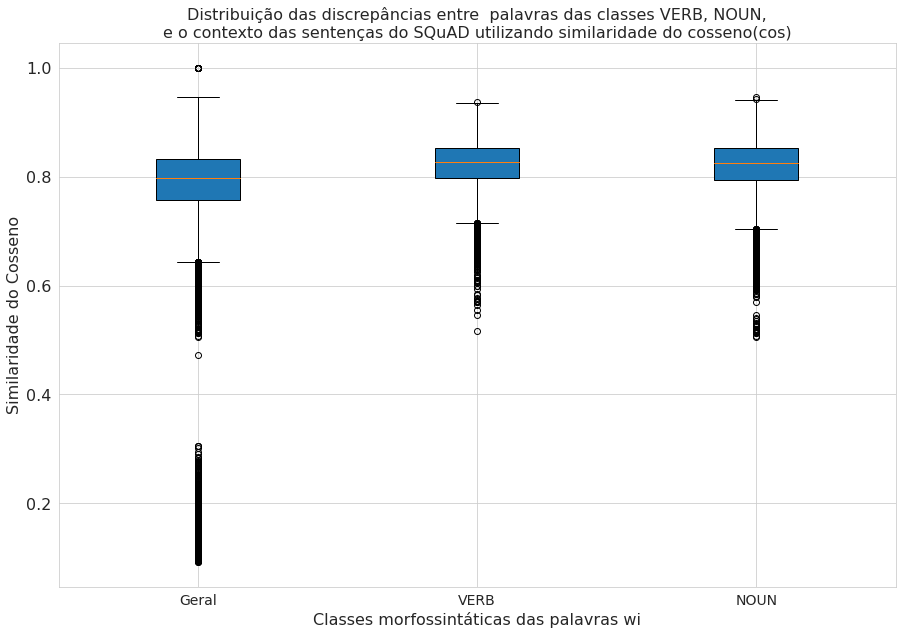

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count     340095.000000      28822.000000      67194.000000
mean          24.226210         24.564871         22.948073
std            3.652454          3.648148          3.615788
min            0.000000         13.196042         12.095321
25%           21.802636         22.093099         20.544742
50%           24.075121         24.406538         22.493617
75%           26.410422         26.770092         24.869676
max           47.041553         47.041553         42.424927

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


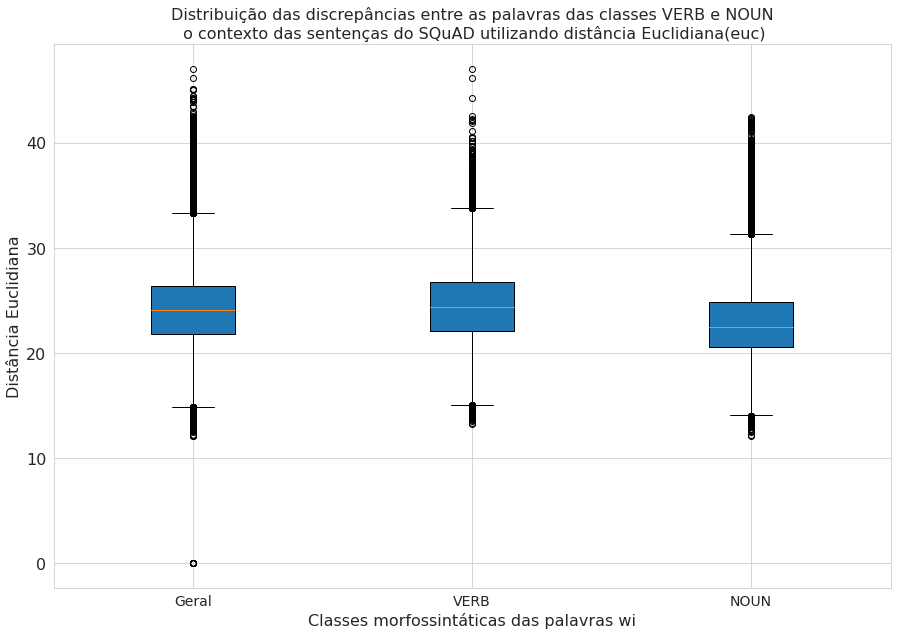

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count     340095.000000      28822.000000      67194.000000
mean        1158.243978       1168.932452       1082.312734
std          169.817091        161.677335        165.929097
min            0.000000        641.974240        584.524400
25%         1041.825350       1060.454850        970.134870
50%         1155.564500       1165.806250       1061.390950
75%         1268.977950       1271.215275       1173.055650
max         2145.623500       2145.623500       1963.251200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


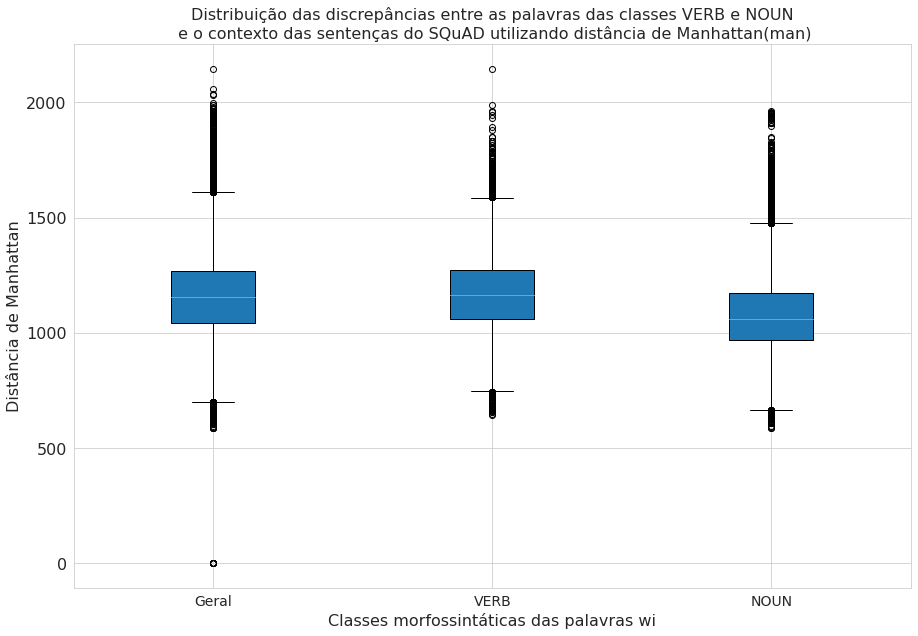

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 28822


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count      28822.000000      28822.000000      28822.000000     28822.000000   
mean           0.934907         11.984327        574.559014         0.928938   
std            0.056046          9.307691        445.506495         0.065036   
min            0.737606          0.000000          0.000000         0.594533   
25%            0.895033          0.000000          0.000000         0.889568   
50%            0.928599         16.006541        769.939789         0.927677   
75%            1.000000         19.189392        921.787491         1.000000   
max            1.000000         33.503696       1589.097900         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count     28822.000000     28822.000000  
mean         12.536544       601.274924  
std           9.677058       463.697214  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%          16.238789       780.192871  
75%          19.818084       950.568924  
max          35.646072      1705.520508

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/28822 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 4734
      2        4 3766
      3        3 3735
      4        6 3094
      5        5 2922
      6        7 2514
      7        1 1874
      8        8 1576
      9        9 1245
     10       10  833
     11       11  774
     12       12  513
     13       13  347
     14       14  262
     15       15  221
     16       16  129
     17       17   63
     18       20   61
     19        0   58
     20       18   41


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.10496672987937927
Limite superior             : 1.157450094819069
Limite inferior             : 0.7375831753015518


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.11043168604373932
Limite superior             : 1.165647529065609
Limite inferior             : 0.7239207848906517


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 158 de 28822 ( 0.005481923530636319 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  158 de 28822 ( 0.005481923530636319 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5945326685905457 envolver-se
         Que papel Eisenhower acreditava que ele não viria cumprir se acreditasse querer envolver-se na política ?

 2 0.6005947589874268 fazê-los
         Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?

 3 0.6103019118309021 envolver-se
         Que papel Eisenhower acreditava que ele não desejava cumprir se acreditasse querer envolver-se na política ?

 4 0.611210286617279 envolver-se
         Que papel Eisenhower acreditava que ele não precisa cumprir se acreditasse querer envolver-se na política ?

 5 0.6148379445075989 envolver-se
         Que papel Eisenhower acreditava que ele não fosse cumprir se acreditasse querer envolver-se na política ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual é o termo utilizado para aves que concentram tempo e esforço em itens alimentares específicos ?
       1 0.8737845420837402 utilizado
       2 0.7238726615905762 concentram

 2 Por que um garoto que amadurece tardiamente deverá ter menos confiança ao se comparar com os outros ?
       1 0.885343074798584 ter
       2 0.8539588451385498 deverá
       3 0.752644956111908 amadurece
       4 0.7236967086791992 comparar

 3 O que os restaurantes e os fabricantes de alimentos precisam enfrentar para ajudar os consumidores que desejam seguir as diretrizes alimentares ?
       1 0.8639927506446838 ajudar
       2 0.8626230955123901 precisam
       3 0.858565628528595 seguir
       4 0.8494195938110352 enfrentar
       5 0.7236943244934082 desejam

 4 Quando foi declarada oficialmente a Grécia que conhecemos hoje ?
       1 0.8818094730377197 declarada
       2 0.7229851484298706 conhecemos

 5 Por que um garoto que amadurece tardiamente demonstra ter menos confiança ao se comparar com

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 19.18939208984375
Limite superior             : 47.973480224609375
Limite inferior             : -28.784088134765625


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 19.818084239959717
Limite superior             : 49.54521059989929
Limite inferior             : -29.727126359939575


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 921.7874908447266
Limite superior             : 2304.4687271118164
Limite inferior             : -1382.6812362670898


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 950.5689239501953
Limite superior             : 2376.4223098754883
Limite inferior             : -1425.853385925293


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 67194


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count      65423.000000      65423.000000      65423.000000     65423.000000   
mean           0.649309         33.632994       1593.136731         0.638344   
std            0.069546          4.350733        194.603384         0.076450   
min            0.358891         18.706682        895.426636         0.273082   
25%            0.604963         30.598806       1455.477905         0.590212   
50%            0.653745         33.367889       1585.381592         0.644596   
75%            0.699713         36.358948       1721.655334         0.694126   
max            0.870525         56.597595       2413.784424         0.870525   

       euc_ctxverb_max  man_ctxverb_max  
count     65423.000000     65423.000000  
mean         34.283120      1623.170731  
std           4.537695       202.657529  
min          18.706682       895.426636  
25%          31.126902      1479.215149  
50%          33.952751      1613.797607  
75%          37.096861      1753.434692  
max          57.363255      2505.884521

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/67194 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        1 8662
      2        3 8133
      3        4 6797
      4        5 6092
      5        6 5826
      6        7 5591
      7        2 5435
      8        8 4190
      9        9 3666
     10       10 2914
     11       11 2429
     12       13 1635
     13       12 1505
     14       14  895
     15       15  830
     16        0  534
     17       17  483
     18       16  463
     19       19  315
     20       18  210


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 67194 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 67194 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 67194 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 67194 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count    331912.000000    331912.000000    331912.000000   331912.000000   
mean          0.700006        29.674597      1419.602261        0.692011   
std           0.127552         9.331478       435.689519        0.132714   
min           0.035415         0.000000         0.000000        0.035415   
25%           0.624257        27.036452      1315.383362        0.613372   
50%           0.686261        31.303370      1507.000000        0.681156   
75%           0.752709        35.207200      1678.912323        0.750148   
max           1.000000        62.451836      2418.588623        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count   331912.000000   331912.000000     28822.000000     28822.000000   
mean        30.174545     1443.203088         0.934907        11.984327   
std          9.542134      445.342536         0.056046         9.307691   
min          0.000000        0.000000         0.737606         0.000000   
25%         27.249225     1326.963013         0.895033         0.000000   
50%         31.743555     1526.587952         0.928599        16.006541   
75%         35.897658     1709.629364         1.000000        19.189392   
max         62.451836     2609.769287         1.000000        33.503696   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count     28822.000000    28822.000000    28822.000000    28822.000000   
mean        574.559014        0.928938       12.536544      601.274924   
std         445.506495        0.065036        9.677058      463.697214   
min           0.000000        0.594533        0.000000        0.000000   
25%           0.000000        0.889568        0.000000        0.000000   
50%         769.939789        0.927677       16.238789      780.192871   
75%         921.787491        1.000000       19.818084      950.568924   
max        1589.097900        1.000000       35.646072     1705.520508   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     65423.000000     65423.000000     65423.000000    65423.000000   
mean          0.649309        33.632994      1593.136731        0.638344   
std           0.069546         4.350733       194.603384        0.076450   
min           0.358891        18.706682       895.426636        0.273082   
25%           0.604963        30.598806      1455.477905        0.590212   
50%           0.653745        33.367889      1585.381592        0.644596   
75%           0.699713        36.358948      1721.655334        0.694126   
max           0.870525        56.597595      2413.784424        0.870525   

                                       
      euc_ctxverb_max man_ctxverb_max  
count    65423.000000    65423.000000  
mean        34.283120     1623.170731  
std          4.537695      202.657529  
min         18.706682      895.426636  
25%         31.126902     1479.215149  
50%         33.952751     1613.797607  
75%         37.096861     1753.434692  
max         57.363255     2505.884521

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count    331912.000000     28822.000000     65423.000000
mean          0.700006         0.934907         0.649309
std           0.127552         0.056046         0.069546
min           0.035415         0.737606         0.358891
25%           0.624257         0.895033         0.604963
50%           0.686261         0.928599         0.653745
75%           0.752709         1.000000         0.699713
max           1.000000         1.000000         0.870525

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


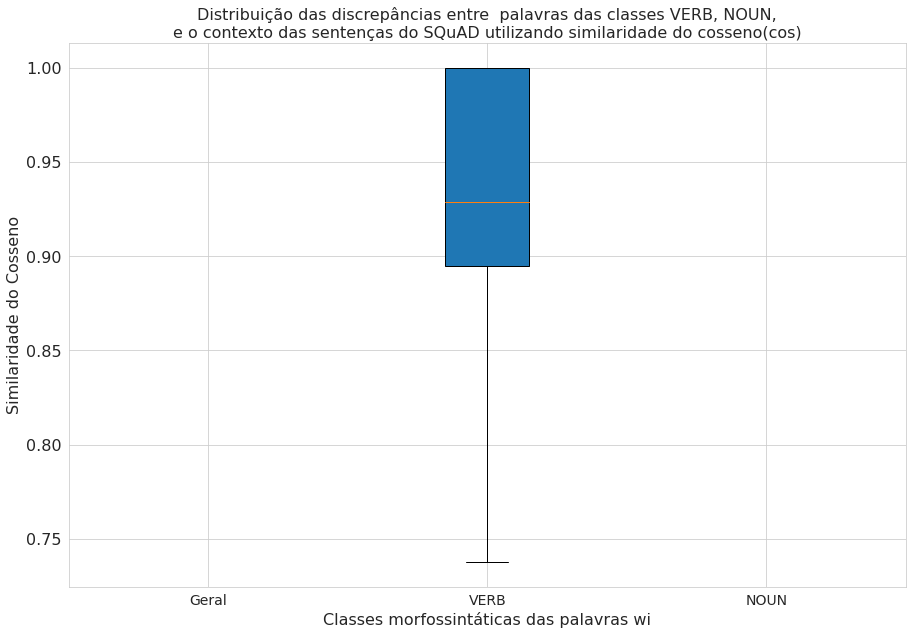

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count    331912.000000     28822.000000     65423.000000
mean         29.674597        11.984327        33.632994
std           9.331478         9.307691         4.350733
min           0.000000         0.000000        18.706682
25%          27.036452         0.000000        30.598806
50%          31.303370        16.006541        33.367889
75%          35.207200        19.189392        36.358948
max          62.451836        33.503696        56.597595

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


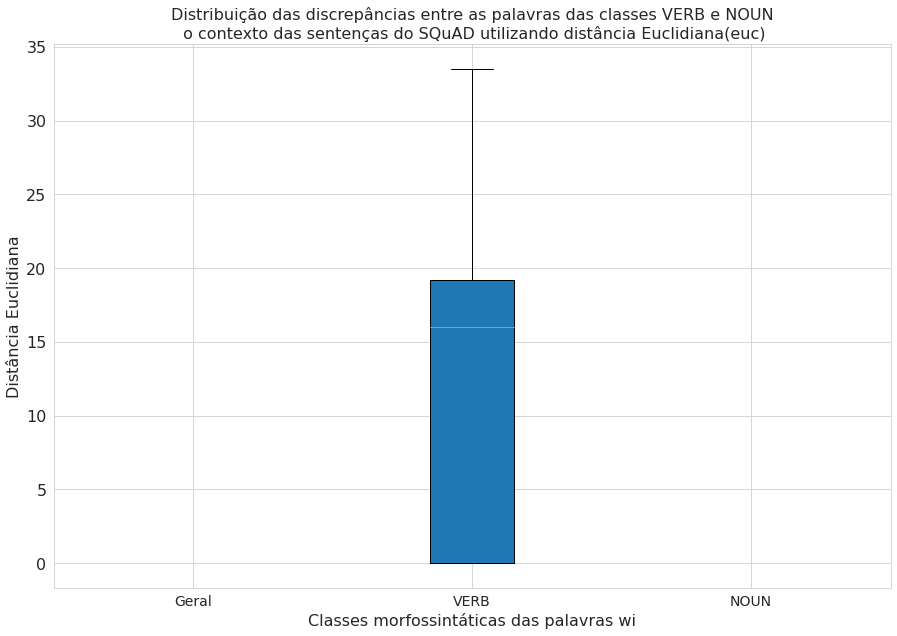

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count    331912.000000     28822.000000     65423.000000
mean       1419.602261       574.559014      1593.136731
std         435.689519       445.506495       194.603384
min           0.000000         0.000000       895.426636
25%        1315.383362         0.000000      1455.477905
50%        1507.000000       769.939789      1585.381592
75%        1678.912323       921.787491      1721.655334
max        2418.588623      1589.097900      2413.784424

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


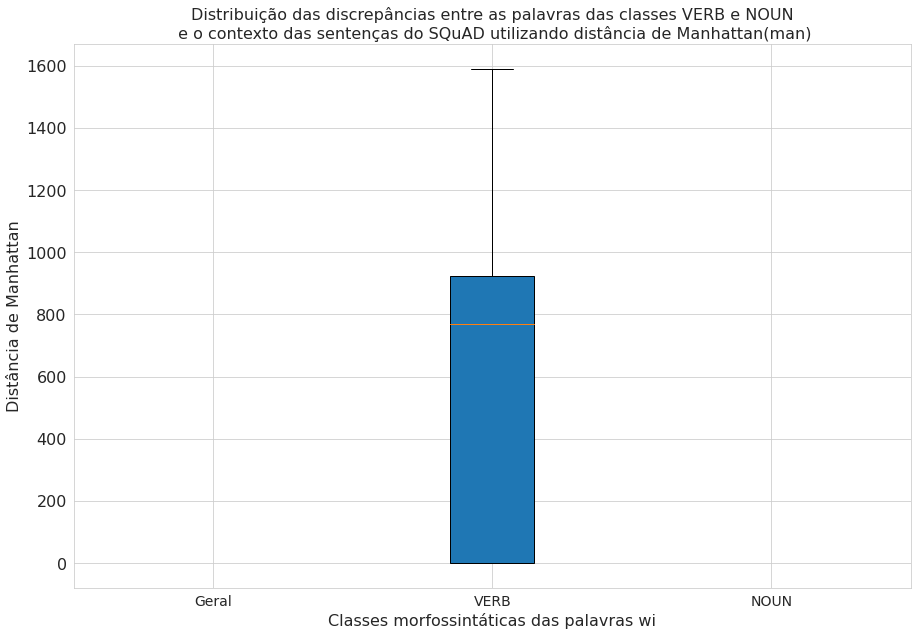

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 28822


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count      27047.000000      27047.000000      27047.000000     27047.000000   
mean           0.689830         31.893317       1514.586003         0.684414   
std            0.061034          3.990506        174.115642         0.061650   
min            0.419089         20.285978        940.808838         0.419089   
25%            0.654182         29.236368       1397.441162         0.647546   
50%            0.696538         31.563770       1503.593628         0.691729   
75%            0.733659         34.153843       1619.849365         0.728538   
max            0.849375         54.366077       2405.960449         0.849375   

       euc_ctxnoun_max  man_ctxnoun_max  
count     27047.000000     27047.000000  
mean         32.246606      1531.766590  
std           3.797967       165.221927  
min          20.285978       972.968445  
25%          29.618940      1417.001831  
50%          31.886673      1518.601318  
75%          34.365330      1630.722778  
max          54.366077      2405.960449

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/28822 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 4734
      2        4 3766
      3        3 3735
      4        6 3094
      5        5 2922
      6        7 2514
      7        1 1874
      8        8 1576
      9        9 1245
     10       10  833
     11       11  774
     12       12  513
     13       13  347
     14       14  262
     15       15  221
     16       16  129
     17       17   63
     18       20   61
     19        0   58
     20       18   41


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 28822 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 28822 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 28822 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 67194


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count      67194.000000      67194.000000      67194.000000     67194.000000   
mean           0.883187         17.550377        825.327293         0.869650   
std            0.059440          7.116641        332.595871         0.071581   
min            0.593737          0.000000          0.000000         0.504419   
25%            0.845799         15.994550        755.431915         0.832076   
50%            0.880502         19.001740        894.675934         0.873135   
75%            0.914627         21.680735       1020.557404         0.911094   
max            1.000000         40.591515       1791.232056         1.000000   

       euc_ctxnoun_max  man_ctxnoun_max  
count     67194.000000     67194.000000  
mean         18.695180       881.051749  
std           7.289260       343.279617  
min           0.000000         0.000000  
25%          16.461041       780.840805  
50%          19.731310       931.117126  
75%          22.844383      1074.431580  
max          41.630505      2211.171387

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/67194 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        1 8662
      2        3 8133
      3        4 6797
      4        5 6092
      5        6 5826
      6        7 5591
      7        2 5435
      8        8 4190
      9        9 3666
     10       10 2914
     11       11 2429
     12       13 1635
     13       12 1505
     14       14  895
     15       15  830
     16        0  534
     17       17  483
     18       16  463
     19       19  315
     20       18  210


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06882788240909565
Limite superior             : 1.0178691968321798
Limite inferior             : 0.7425576671957972


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 67194 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 625 de 67194 ( 0.00930142572253475 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  625 de 67194 ( 0.00930142572253475 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5937369465827942 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 2 0.5972690582275391 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 3 0.5976364016532898 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de melhorar completamente o consentimento ?

 4 0.6005291938781738 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de remover completamente o consentimento ?

 5 0.6011030673980713 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de regular completamente o consentimento ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como o holandês tem muitos sons de vogal e palavras compostas , o que é frequentemente na ortografia holandesa ?
       1 0.887136697769165 vogal
       2 0.88303142786026 sons
       3 0.8549084067344666 palavras
       4 0.7914638519287109 ortografia
       5 0.7425004243850708 holandês

 2 Quais são as duas músicas que faziam referência às cores da equipe da escola em seus títulos ?
       1 0.8155629634857178 cores
       2 0.8144406676292419 músicas
       3 0.8095664381980896 títulos
       4 0.804206132888794 equipe
       5 0.7889249324798584 escola
       6 0.7424693703651428 referência

 3 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de procurar cargos públicos com base em sua religião eram inexequíveis ?
       1 0.82033371925354 regra
       2 0.7715243697166443 religião
       3 0.7699810862541199 cláusulas
       4 0.7692576050758362 pessoas
       5 0.742425262928009 base
       6 0.7333876490592957 Corte
       7 0.7189034819602966 carg

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06882788240909565
Limite superior             : 1.0178691968321798
Limite inferior             : 0.7425576671957972


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 67194 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 625 de 67194 ( 0.00930142572253475 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  625 de 67194 ( 0.00930142572253475 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5937369465827942 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 2 0.5972690582275391 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 3 0.5976364016532898 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de melhorar completamente o consentimento ?

 4 0.6005291938781738 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de remover completamente o consentimento ?

 5 0.6011030673980713 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de regular completamente o consentimento ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como o holandês tem muitos sons de vogal e palavras compostas , o que é frequentemente na ortografia holandesa ?
       1 0.887136697769165 vogal
       2 0.88303142786026 sons
       3 0.8549084067344666 palavras
       4 0.7914638519287109 ortografia
       5 0.7425004243850708 holandês

 2 Quais são as duas músicas que faziam referência às cores da equipe da escola em seus títulos ?
       1 0.8155629634857178 cores
       2 0.8144406676292419 músicas
       3 0.8095664381980896 títulos
       4 0.804206132888794 equipe
       5 0.7889249324798584 escola
       6 0.7424693703651428 referência

 3 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de procurar cargos públicos com base em sua religião eram inexequíveis ?
       1 0.82033371925354 regra
       2 0.7715243697166443 religião
       3 0.7699810862541199 cláusulas
       4 0.7692576050758362 pessoas
       5 0.742425262928009 base
       6 0.7333876490592957 Corte
       7 0.7189034819602966 carg

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.686184883117674
Limite superior             : 30.21001195907592
Limite inferior             : 7.465272426605226


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 592


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7478 de 67194 ( 0.11128969848498378 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8070 de 67194 ( 0.12010000892936869 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.59151458740234 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?

 2 40.547760009765625 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?

 3 40.51653671264648 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?

 4 40.11596298217773 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?

 5 40.03711318969727 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 escolas
         Onde a CES coloca as escolas irmãs da BYU ?

 2 0.0 dezembro
         Para onde Bin Laden escapou em dezembro de 2001 ?

 3 0.0 dezembro
         Para onde Bin Laden veio em dezembro de 2001 ?

 4 0.0 dezembro
         Para onde Bin Laden segue em dezembro de 2001 ?

 5 0.0 dezembro
         Para onde Bin Laden mudou em dezembro de 2001 ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?
       1 40.59151458740234 protestos
       2 28.38656234741211 sérvios
       3 26.47886657714844 ano
       4 23.487764358520508 albaneses
       5 21.432546615600582 grupos

 2 Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?
       1 40.547760009765625 protestos
       2 28.650575637817383 sérvios
       3 26.243335723876957 ano
       4 23.544065475463867 albaneses
       5 21.10667610168457 grupos

 3 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?
       1 40.51653671264648 protestos
       2 28.613014221191406 sérvios
       3 26.50656509399414 ano
       4 23.11993789672852 albaneses
       5 22.269777297973636 grupos

 4 Em que ano Tito viajou para os EUA para vi

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.383341312408447
Limite superior             : 32.419394731521606
Limite inferior             : 6.886029481887817


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 664


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 6303 de 67194 ( 0.09380301812661845 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  6967 de 67194 ( 0.10368485281423936 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.6305046081543 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 2 41.312103271484375 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 3 41.0854606628418 lápis-lazúli
         De qual país o lápis-lazúli foi original ?

 4 41.02883529663086 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?

 5 40.96681594848633 lápis-lazúli
         De qual país o lápis-lazúli foi emprestado ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 filme
         Quem fez um filme chamado 'Bronx Burning'?

 2 0.0 situação
         O que comemorar quando a situação econômica melhorou ?

 3 0.0 situação
         O que fizeram quando a situação econômica melhorou ?

 4 0.0 situação
         O que melhorou quando a situação econômica melhorou ?

 5 0.0 situação
         O que comer quando a situação econômica melhorou ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi importado?
       1 41.6305046081543 lápis-lazúli
       2 16.227445602416992 país

 2 De qual país o lápis-lazúli foi mesmo ?
       1 41.312103271484375 lápis-lazúli
       2 15.051660537719728 país

 3 De qual país o lápis-lazúli foi original ?
       1 41.0854606628418 lápis-lazúli
       2 14.854494094848633 país

 4 De qual país o lápis-lazúli foi transferido ?
       1 41.02883529663086 lápis-lazúli
       2 15.347451210021973 país

 5 De qual país o lápis-lazúli foi emprestado ?
       1 40.96681594848633 lápis-lazúli
       2 15.123701095581056 país


##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 265.12548828125
Limite superior             : 1418.2456359863281
Limite inferior             : 357.7436828613281


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 386


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7512 de 67194 ( 0.11179569604428967 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7898 de 67194 ( 0.11754025657052714 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1791.2320556640625 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 2 1785.863037109375 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?

 3 1784.19677734375 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de remover completamente o consentimento ?

 4 1778.172607421875 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de melhorar completamente o consentimento ?

 5 1777.604736328125 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de destruir completamente o consentimento ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 356.0420227050781 fagossomo
         O que você produz quando combina um lisossomo e um fagossomo ?

 2 356.0419921875 lisossomo
         O que você produz quando combina um lisossomo e um fagossomo ?

 3 354.43701171875 lisossomo
         O que você come quando combina um lisossomo e um fagossomo ?

 4 354.4369812011719 fagossomo
         O que você come quando combina um lisossomo e um fagossomo ?

 5 352.9266357421875 fagossomo
         O que você descobre quando combina um lisossomo e um fagossomo ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?
       1 1791.2320556640625 vez
       2 1233.126708984375 processos
       3 1163.529296875 partes
       4 992.7982177734376 consentimento
       5 960.7493896484376 tratado
       6 863.992919921875 consentimento

 2 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de manter completamente o consentimento ?
       1 1785.863037109375 vez
       2 1231.693359375 processos
       3 1161.0029296875 partes
       4 977.4143676757812 consentimento
       5 946.4427490234376 tratado
       6 856.4147338867188 consentimento

 3 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de remover completamente o consentimento ?
       1 1784.19677734375 vez
       2 1216.3128662109375 processos
       3 1168.600219726

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 293.5907745361328
Limite superior             : 1514.817741394043
Limite inferior             : 340.4546432495117


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 680


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 6311 de 67194 ( 0.09392207637586689 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  6991 de 67194 ( 0.1040420275619847 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2211.17138671875 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 2 2207.543701171875 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 3 2198.887939453125 lápis-lazúli
         De qual país o lápis-lazúli foi original ?

 4 2197.14990234375 lápis-lazúli
         De qual país o lápis-lazúli foi escolhido ?

 5 2193.1328125 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 338.521728515625 tratado
         Que tratado inclui o tratado constitucional ?

 2 338.521728515625 tratado
         Que tratado inclui o tratado constitucional ?

 3 334.9139404296875 tratado
         Que tratado substituiu o tratado constitucional?

 4 334.9139404296875 tratado
         Que tratado substituiu o tratado constitucional?

 5 334.89288330078125 tratado
         Que tratado e o tratado constitucional ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi mesmo ?
       1 2211.17138671875 lápis-lazúli
       2 721.8394775390625 país

 2 De qual país o lápis-lazúli foi importado?
       1 2207.543701171875 lápis-lazúli
       2 787.2183837890625 país

 3 De qual país o lápis-lazúli foi original ?
       1 2198.887939453125 lápis-lazúli
       2 719.862548828125 país

 4 De qual país o lápis-lazúli foi escolhido ?
       1 2197.14990234375 lápis-lazúli
       2 716.0223388671875 país

 5 De qual país o lápis-lazúli foi transferido ?
       1 2193.1328125 lápis-lazúli
       2 734.9637451171875 país


#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count    324048.000000    324048.000000    324048.000000   324048.000000   
mean          0.722569        27.761247      1322.220621        0.714011   
std           0.111869         7.129056       336.516919        0.113589   
min           0.069511         0.000000         0.000000        0.069511   
25%           0.655730        25.139366      1204.383514        0.647753   
50%           0.710517        28.842566      1383.303833        0.704677   
75%           0.777302        31.894205      1525.053253        0.769681   
max           1.000000        54.870331      2405.960449        1.000000   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count   324048.000000   324048.000000     27047.000000     27047.000000   
mean        28.360421     1351.437228         0.689830        31.893317   
std          7.044752      332.423615         0.061034         3.990506   
min          0.000000        0.000000         0.419089        20.285978   
25%         25.660860     1231.443176         0.654182        29.236368   
50%         29.228889     1401.512573         0.696538        31.563770   
75%         32.421236     1548.919067         0.733659        34.153843   
max         56.903202     2523.168213         0.849375        54.366077   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count     27047.000000    27047.000000    27047.000000    27047.000000   
mean       1514.586003        0.684414       32.246606     1531.766590   
std         174.115642        0.061650        3.797967      165.221927   
min         940.808838        0.419089       20.285978      972.968445   
25%        1397.441162        0.647546       29.618940     1417.001831   
50%        1503.593628        0.691729       31.886673     1518.601318   
75%        1619.849365        0.728538       34.365330     1630.722778   
max        2405.960449        0.849375       54.366077     2405.960449   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     67194.000000     67194.000000     67194.000000    67194.000000   
mean          0.883187        17.550377       825.327293        0.869650   
std           0.059440         7.116641       332.595871        0.071581   
min           0.593737         0.000000         0.000000        0.504419   
25%           0.845799        15.994550       755.431915        0.832076   
50%           0.880502        19.001740       894.675934        0.873135   
75%           0.914627        21.680735      1020.557404        0.911094   
max           1.000000        40.591515      1791.232056        1.000000   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count    67194.000000    67194.000000  
mean        18.695180      881.051749  
std          7.289260      343.279617  
min          0.000000        0.000000  
25%         16.461041      780.840805  
50%         19.731310      931.117126  
75%         22.844383     1074.431580  
max         41.630505     2211.171387

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count    324048.000000     27047.000000     67194.000000
mean          0.722569         0.689830         0.883187
std           0.111869         0.061034         0.059440
min           0.069511         0.419089         0.593737
25%           0.655730         0.654182         0.845799
50%           0.710517         0.696538         0.880502
75%           0.777302         0.733659         0.914627
max           1.000000         0.849375         1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


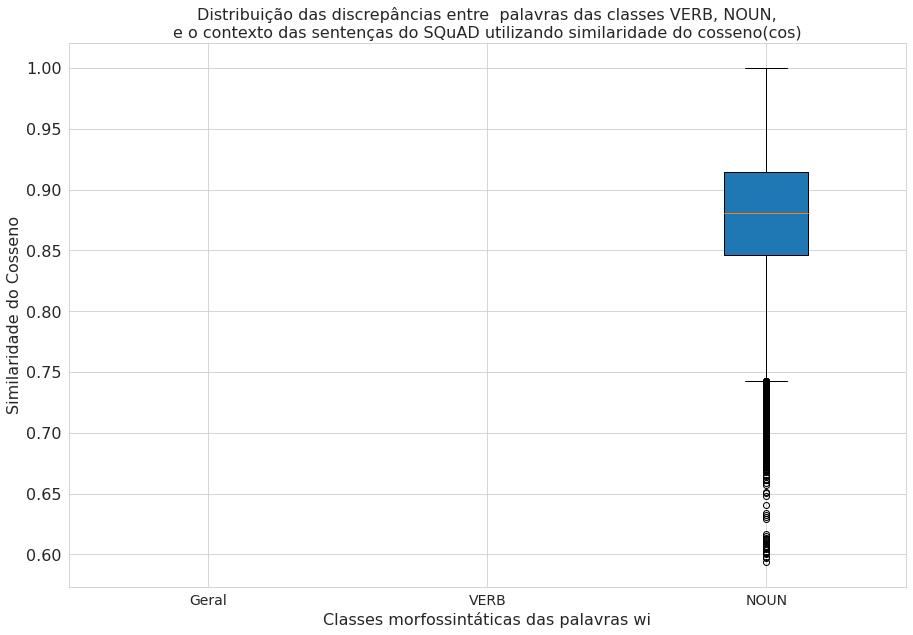

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count    324048.000000     27047.000000     67194.000000
mean         27.761247        31.893317        17.550377
std           7.129056         3.990506         7.116641
min           0.000000        20.285978         0.000000
25%          25.139366        29.236368        15.994550
50%          28.842566        31.563770        19.001740
75%          31.894205        34.153843        21.680735
max          54.870331        54.366077        40.591515

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


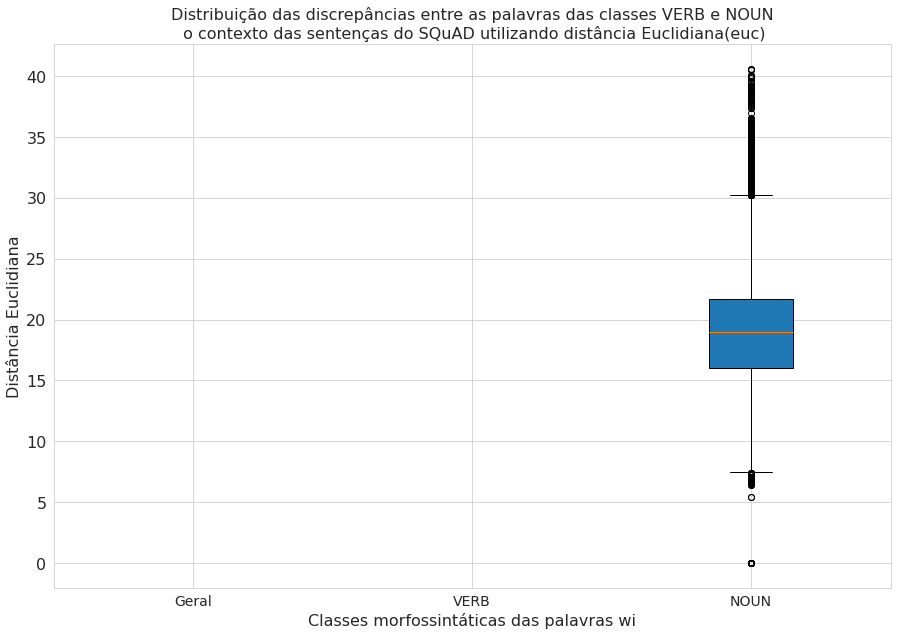

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count    324048.000000     27047.000000     67194.000000
mean       1322.220621      1514.586003       825.327293
std         336.516919       174.115642       332.595871
min           0.000000       940.808838         0.000000
25%        1204.383514      1397.441162       755.431915
50%        1383.303833      1503.593628       894.675934
75%        1525.053253      1619.849365      1020.557404
max        2405.960449      2405.960449      1791.232056

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


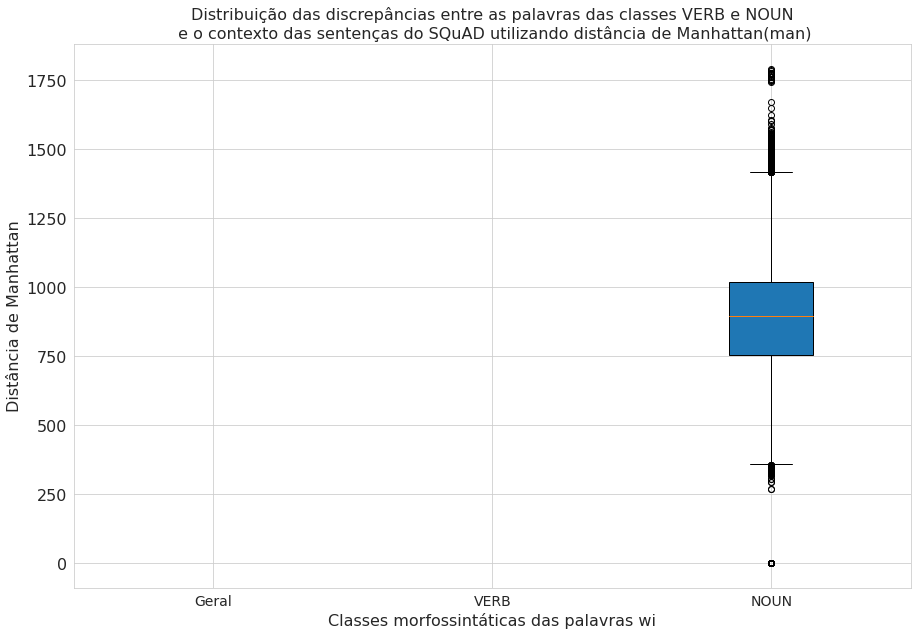

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 28822


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count          28822.000000          28822.000000          28822.000000   
mean               0.863351             21.356176           1016.854813   
std                0.047499              5.214789            242.659261   
min                0.659767              0.000000              0.000000   
25%                0.834149             19.035048            911.917786   
50%                0.861406             21.779977           1041.781555   
75%                0.892517             24.332668           1158.999359   
max                1.000000             39.285553           1729.329346   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count         28822.000000         28822.000000         28822.000000  
mean              0.857425            21.806291          1038.689677  
std               0.054446             5.323140           249.076269  
min               0.561536             0.000000             0.000000  
25%               0.828321            19.461892           931.430756  
50%               0.858632            22.199906          1062.251892  
75%               0.890667            24.861372          1183.850525  
max               1.000000            39.285553          1762.138916

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/28822 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 4734
      2        4 3766
      3        3 3735
      4        6 3094
      5        5 2922
      6        7 2514
      7        1 1874
      8        8 1576
      9        9 1245
     10       10  833
     11       11  774
     12       12  513
     13       13  347
     14       14  262
     15       15  221
     16       16  129
     17       17   63
     18       20   61
     19        0   58
     20       18   41


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05836792290210724
Limite superior             : 0.9800691977143288
Limite inferior             : 0.7465975061058998


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 783 de 28822 ( 0.027166747623343278 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 261 de 28822 ( 0.009055582541114427 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1044 de 28822 ( 0.03622233016445771 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 canta
         Sobre o que Heer Ranjha canta?

 2 1.0 dirige
         Quem dirige a Abadia de Westminster ?

 3 1.0 passou
         Quem passou para o UNFPA ?

 4 1.0 torce
         Quem torce para o UNFPA ?

 5 1.0 mandou
         Quem mandou para o UNFPA ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6597669124603271 tornasse
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?

 2 0.6867924928665161 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam eliminados ?

 3 0.6920908093452454 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam perdidos ?

 4 0.6972185969352722 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam destruídos ?

 5 0.6972492933273315 disse
         Quem disse que milhares de apoiadores pró-Pequim seriam vendidos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O estudo de 2008 anterior à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão , assim como de sua família e contemporâneos , tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais ?
       1 0.8167286515235901 coletados
       2 0.8000223636627197 tinham
       3 0.7463570833206177 constatou

 2 Uma parte reservadora de um tratado pode incluir uma declaração que implica fazer o que com suas obrigações legais ou seus efeitos ?
       1 0.8458255529403687 implica
       2 0.8231402039527893 fazer
       3 0.8158021569252014 incluir
       4 0.7463269829750061 pode

 3 Quem determinou que os telefones não possam estar no modo avião , com o serviço móvel ativado e as barras exibidas ?
       1 0.8279001116752625 estar
       2 0.7850416898727417 possam
       3 0.7798653244972229 exibidas
       4 0.7560023665428162 ativado
       5 0.7462132573127747 determinou

 4 Que idioma manifesta a tendência de se referir à Holanda como " 

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.062346622347831726
Limite superior             : 0.9841874316334724
Limite inferior             : 0.7348009422421455


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 756 de 28822 ( 0.02622996322253834 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 731 de 28822 ( 0.02536257025883006 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1487 de 28822 ( 0.0515925334813684 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 canta
         Sobre o que Heer Ranjha canta?

 2 1.0 invadiu
         Quem invadiu a Abadia de Westminster ?

 3 1.0 voltou
         Quem voltou para o UNFPA ?

 4 1.0 fundou
         Quem fundou a Abadia de Westminster ?

 5 1.0 construiu
         Quem construiu a Abadia de Westminster ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5615358352661133 fazê-los
         Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?

 2 0.5773158669471741 sobrecarregar
         Qual foi o nome da empresa de fabricação da Apple parar de sobrecarregar seus funcionários ?

 3 0.591364324092865 sobrecarregar
         Qual foi o nome da empresa de fabricação da Apple além de sobrecarregar seus funcionários ?

 4 0.599592924118042 sobrecarregar
         Qual foi o nome da empresa de fabricação da Apple acusou de sobrecarregar seus funcionários ?

 5 0.6013188362121582 sobrecarregar
         Qual foi o nome da empresa de fabricação da Apple depois de sobrecarregar seus funcionários ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que induz a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?
       1 0.7347738146781921 induz

 2 Quem incentivou as universidades locais a promover as oportunidades para os alunos nos distritos das escolas públicas ?
       1 0.826245129108429 promover
       2 0.7346627712249756 incentivou

 3 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se nomear Papa ?
       1 0.847495436668396 usado
       2 0.7345091104507446 nomear

 4 O que está comprometido em muitos níveis de formas de lei ificação e não codificadas ?
       1 0.734504222869873 codificadas

 5 Que geração para as baterias do iPod serem afixadas com cola ?
       1 0.7344903349876404 afixadas


##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.297620296478275
Limite superior             : 32.279098272323616
Limite inferior             : 11.088617086410517


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 247 de 28822 ( 0.00856984248143779 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 784 de 28822 ( 0.02720144334189161 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1031 de 28822 ( 0.035771285823329405 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.285552978515625 tornando
         Qual é a característica do sulfeto de zinco que o tornando perigoso nas telas de televisão ?

 2 39.22104263305664 levando
         O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?

 3 39.207176208496094 tocaram
         Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?

 4 39.127723693847656 distinguir
         Como os elevadores de carga distinguir dos elevadores de passageiros ?

 5 38.90407943725586 desconhecidas
         Que tecnologia permitiu a pesquisa nas partes do cérebro que desconhecidas anteriormente ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 canta
         Sobre o que Heer Ranjha canta?

 2 0.0 passou
         Quem passou para o UNFPA ?

 3 0.0 torce
         Quem torce para o UNFPA ?

 4 0.0 mandou
         Quem mandou para o UNFPA ?

 5 0.0 contribui
         Quem contribui para o UNFPA ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual é a característica do sulfeto de zinco que o tornando perigoso nas telas de televisão ?
       1 39.285552978515625 tornando

 2 O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?
       1 39.22104263305664 levando

 3 Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 39.207176208496094 tocaram
       2 24.99991607666016 abriu

 4 Como os elevadores de carga distinguir dos elevadores de passageiros ?
       1 39.127723693847656 distinguir

 5 Que tecnologia permitiu a pesquisa nas partes do cérebro que desconhecidas anteriormente ?
       1 38.90407943725586 desconhecidas
       2 24.262454986572266 permitiu


##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.39948034286499
Limite superior             : 32.9605929851532
Limite inferior             : 11.362671613693237


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 192 de 28822 ( 0.006661577961279578 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 757 de 28822 ( 0.02626465894108667 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  949 de 28822 ( 0.03292623690236625 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.285552978515625 tornando
         Qual é a característica do sulfeto de zinco que o tornando perigoso nas telas de televisão ?

 2 39.22104263305664 levando
         O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?

 3 39.207176208496094 tocaram
         Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?

 4 39.127723693847656 distinguir
         Como os elevadores de carga distinguir dos elevadores de passageiros ?

 5 38.90407943725586 desconhecidas
         Que tecnologia permitiu a pesquisa nas partes do cérebro que desconhecidas anteriormente ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 canta
         Sobre o que Heer Ranjha canta?

 2 0.0 contribui
         Quem contribui para o UNFPA ?

 3 0.0 voltou
         Quem voltou para o UNFPA ?

 4 0.0 fundou
         Quem fundou a Abadia de Westminster ?

 5 0.0 construiu
         Quem construiu a Abadia de Westminster ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual é a característica do sulfeto de zinco que o tornando perigoso nas telas de televisão ?
       1 39.285552978515625 tornando

 2 O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?
       1 39.22104263305664 levando

 3 Em que dia a empresa que tocaram a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes ?
       1 39.207176208496094 tocaram
       2 24.99991607666016 abriu

 4 Como os elevadores de carga distinguir dos elevadores de passageiros ?
       1 39.127723693847656 distinguir

 5 Que tecnologia permitiu a pesquisa nas partes do cérebro que desconhecidas anteriormente ?
       1 38.90407943725586 desconhecidas
       2 24.262454986572266 permitiu


##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 247.08157348632812
Limite superior             : 1529.6217193603516
Limite inferior             : 541.2954254150391


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 139 de 28822 ( 0.0048227048782180275 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 784 de 28822 ( 0.02720144334189161 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  923 de 28822 ( 0.03202414822010964 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1729.329345703125 tornasse
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?

 2 1724.714111328125 estabelecer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se estabelecer Papa ?

 3 1724.35107421875 determinou
         Quem determinou que os telefones não costumam estar no modo avião , com o serviço móvel ativado e as barras exibidas ?

 4 1713.7015380859375 fazer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?

 5 1706.16259765625 levando
         O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 497.8141784667969 ler
         Que livro Douglas Stuart ler ?

 2 0.0 canta
         Sobre o que Heer Ranjha canta?

 3 0.0 visitou
         Quem visitou a Abadia de Westminster ?

 4 0.0 passou
         Quem passou para o UNFPA ?

 5 0.0 torce
         Quem torce para o UNFPA ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?
       1 1729.329345703125 tornasse
       2 1172.658447265625 usado

 2 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se estabelecer Papa ?
       1 1724.714111328125 estabelecer
       2 1139.75439453125 usado

 3 Quem determinou que os telefones não costumam estar no modo avião , com o serviço móvel ativado e as barras exibidas ?
       1 1724.35107421875 determinou
       2 1433.317626953125 costumam
       3 1303.3287353515625 exibidas
       4 1204.8006591796875 ativado
       5 1164.806884765625 estar

 4 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se fazer Papa ?
       1 1713.7015380859375 fazer
       2 1130.48876953125 usado

 5 O que levando a maus investimentos por parte dos gerentes de ativos em ativos de crédito acima do preço ?
       1 1706

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 252.4197692871095
Limite superior             : 1562.480178833008
Limite inferior             : 552.8011016845701


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 133 de 28822 ( 0.004614530566928041 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 758 de 28822 ( 0.026299354659635 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  891 de 28822 ( 0.03091388522656304 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1762.138916015625 fazê-los
         Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?

 2 1741.365234375 reulava
         Qual era o nome da lei da pureza que reulava a cerveja em 1500?

 3 1739.8458251953125 bambaataa
         que estilo de música afrika bambaataa tocava?

 4 1729.329345703125 tornasse
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?

 5 1724.714111328125 estabelecer
         Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se estabelecer Papa ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 550.985107421875 escreveu
         Que livro Douglas Stuart escreveu ?

 2 497.8141784667969 ler
         Que livro Douglas Stuart ler ?

 3 0.0 controla
         Quem controla a Abadia de Westminster ?

 4 0.0 contribui
         Quem contribui para o UNFPA ?

 5 0.0 voltou
         Quem voltou para o UNFPA ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual era o nome do bloqueio e bombardeio do Japão planejado para fazê-los se render?
       1 1762.138916015625 fazê-los
       2 1220.60595703125 render
       3 1208.6650390625 planejado

 2 Qual era o nome da lei da pureza que reulava a cerveja em 1500?
       1 1741.365234375 reulava

 3 que estilo de música afrika bambaataa tocava?
       1 1739.8458251953125 bambaataa
       2 992.4752197265624 tocava

 4 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se tornasse Papa ?
       1 1729.329345703125 tornasse
       2 1172.658447265625 usado

 5 Em que ano o nome " Paulo " foi usado pela última vez como nome pontifício antes de o Papa Paulo VI se estabelecer Papa ?
       1 1724.714111328125 estabelecer
       2 1139.75439453125 usado


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 67194


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count          67194.000000          67194.000000          67194.000000   
mean               0.845190             21.265510           1002.584570   
std                0.045975              3.583899            162.707964   
min                0.576384              0.000000              0.000000   
25%                0.817601             19.079908            903.306549   
50%                0.848203             21.190631           1000.295410   
75%                0.876695             23.377262           1099.508942   
max                1.000000             41.115711           1794.353516   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count         67194.000000         67194.000000         67194.000000  
mean              0.831872            22.191029          1046.847574  
std               0.061682             4.134466           191.346434  
min               0.441195             0.000000             0.000000  
25%               0.802945            19.580528           927.599579  
50%               0.842014            21.851637          1033.928345  
75%               0.873442            24.485620          1151.485229  
max               1.000000            42.399506          2235.998047

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/67194 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        1 8662
      2        3 8133
      3        4 6797
      4        5 6092
      5        6 5826
      6        7 5591
      7        2 5435
      8        8 4190
      9        9 3666
     10       10 2914
     11       11 2429
     12       13 1635
     13       12 1505
     14       14  895
     15       15  830
     16        0  534
     17       17  483
     18       16  463
     19       19  315
     20       18  210


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05909322202205658
Limite superior             : 0.9653345271945
Limite inferior             : 0.7289616391062737


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 220 de 67194 ( 0.003274101854332232 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 895 de 67194 ( 0.013319641634669763 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1115 de 67194 ( 0.016593743489001993 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 floresta
         Quanto da floresta tropical existente hoje na Ilha Norfolk ?

 2 1.0 parque
         Além do maior parque da Philidelphia ?

 3 1.0 parque
         O do maior parque da Philidelphia ?

 4 1.0 parque
         Depois do maior parque da Philidelphia ?

 5 1.0 parque
         A do maior parque da Philidelphia ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5763837695121765 sérvios
         Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?

 2 0.5790383219718933 sérvios
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 3 0.5902110934257507 sérvios
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos líder de grupos croatas , sérvios e albaneses anticomunistas ?

 4 0.5934551954269409 sérvios
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?

 5 0.5956574082374573 sérvios
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos reunião de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como o holandês tem muitos sons de vogal e palavras compostas , o que aparece frequentemente na ortografia holandesa ?
       1 0.8679745197296143 sons
       2 0.8520693778991699 vogal
       3 0.8268152475357056 palavras
       4 0.7675600647926331 ortografia
       5 0.72894686460495 holandês

 2 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de procurar cargos públicos com base em sua religião eram inexequíveis ?
       1 0.8126373291015625 regra
       2 0.760424792766571 religião
       3 0.7576634883880615 pessoas
       4 0.75153648853302 cláusulas
       5 0.7289193272590637 cargos
       6 0.7197214961051941 base
       7 0.7011714577674866 Corte

 3 Qual é o nome do local em que o evento de término da retransmissão foi cancelado ?
       1 0.8581860661506653 evento
       2 0.8456707000732422 local
       3 0.8301507234573364 término
       4 0.7952207922935486 nome
       5 0.7288951873779297 retransmissão

 4 Qual é o nome do local em que o 

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07049670815467834
Limite superior             : 0.9791868627071381
Limite inferior             : 0.6972000300884247


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 189 de 67194 ( 0.0028127511384945084 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2524 de 67194 ( 0.03756287763788434 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2713 de 67194 ( 0.04037562877637884 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 floresta
         Quanto da floresta tropical existente hoje na Ilha Norfolk ?

 2 1.0 tropas
         Quando as tropas Qing para Nanjing ?

 3 1.0 parque
         A do maior parque da Philidelphia ?

 4 1.0 parque
         Dona do maior parque da Philidelphia ?

 5 1.0 parque
         Diante do maior parque da Philidelphia ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.4411951601505279 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ado de grupos croatas , sérvios e albaneses anticomunistas ?

 2 0.4520369470119476 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ido de grupos croatas , sérvios e albaneses anticomunistas ?

 3 0.4609293639659881 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC, protestos amistas de grupos croatas, sérvios e albaneses anticomunistas?

 4 0.4811286330223083 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos mãos de grupos croatas , sérvios e albaneses anticomunistas ?

 5 0.4836108982563019 albaneses
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos interesses de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de ganhar cargos públicos com base em sua religião eram inexequíveis ?
       1 0.8130974173545837 regra
       2 0.7785690426826477 pessoas
       3 0.7530189156532288 religião
       4 0.7364886403083801 base
       5 0.7304196953773499 cargos
       6 0.7020574808120728 cláusulas
       7 0.6971976161003113 Corte

 2 O que a mídia fez para mostrar o aborrecimento de Lehrer com Kerry ?
       1 0.8562278747558594 mídia
       2 0.6971802711486816 aborrecimento

 3 Que ação não poderá ser procurada pelos adivinhos estatais ?
       1 0.8668486475944519 ação
       2 0.697150707244873 adivinhos

 4 Qual mercado em Melbourne funcionou forte durante a crise financeira do final dos anos 2000 e resultou em preços historicamente altos e aumentos de aluguel ?
       1 0.8097474575042725 mercado
       2 0.8088748455047607 preços
       3 0.7641260027885437 crise
       4 0.7160651683807373 anos
       5 0.71290057

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.297353267669678
Limite superior             : 29.823291540145874
Limite inferior             : 12.633878469467163


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1033


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 315 de 67194 ( 0.004687918564157514 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1348 de 67194 ( 0.020061314998362948 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.1157112121582 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?

 2 40.9199104309082 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?

 3 40.60199737548828 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?

 4 40.12715148925781 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos to de grupos croatas , sérvios e albaneses anticomunistas ?

 5 39.78007125854492 protestos
         Em que ano Tito viajou para os EUA para visitar Washington DC , protestos convite de grupos croatas , sérvios e albaneses anticomunistas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 função
         Qual a função de Estêvão Gomes ?

 2 0.0 músicas
         Quantas músicas polonesas de Chopin Liszt transliterou para Inglês ?

 3 0.0 músicas
         Quantas músicas polonesas de Chopin Liszt transliterou para Portugal ?

 4 0.0 músicas
         Quantas músicas polonesas de Chopin Liszt transliterou para ela ?

 5 0.0 mos
         Quem Bell mos em 1874 ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos ndo de grupos croatas , sérvios e albaneses anticomunistas ?
       1 41.1157112121582 protestos
       2 30.36978912353516 sérvios
       3 26.27604103088379 ano
       4 25.260892868041992 albaneses
       5 22.291406631469727 grupos

 2 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos protestos de grupos croatas , sérvios e albaneses anticomunistas ?
       1 40.9199104309082 protestos
       2 30.613080978393555 sérvios
       3 26.30234909057617 ano
       4 24.934362411499023 albaneses
       5 23.365938186645508 grupos

 3 Em que ano Tito viajou para os EUA para visitar Washington DC , protestos alvo de grupos croatas , sérvios e albaneses anticomunistas ?
       1 40.60199737548828 protestos
       2 30.5631103515625 sérvios
       3 26.24345016479492 ano
       4 24.60242462158203 albaneses
       5 24.22429847717285 grupos

 4 Em que ano Tito viajou para os EUA para visitar 

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.905092239379886
Limite superior             : 31.8432583808899
Limite inferior             : 12.222889423370356


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1341


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 247 de 67194 ( 0.0036759234455457333 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1588 de 67194 ( 0.023633062475816292 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.399505615234375 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 2 42.03474807739258 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 3 41.97520446777344 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?

 4 41.9156494140625 lápis-lazúli
         De qual país o lápis-lazúli foi emprestado ?

 5 41.88703155517578 lápis-lazúli
         De qual país o lápis-lazúli foi trazido ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 floresta
         Quanto da floresta tropical existente hoje na Ilha Norfolk ?

 2 0.0 nacionalidade
         Qual a a nacionalidade do Destot ?

 3 0.0 nacionalidade
         Qual então a nacionalidade do Destot ?

 4 0.0 nacionalidade
         Qual exatamente a nacionalidade do Destot ?

 5 0.0 nacionalidade
         Qual á a nacionalidade do Destot ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi importado?
       1 42.399505615234375 lápis-lazúli
       2 21.29656410217285 país

 2 De qual país o lápis-lazúli foi mesmo ?
       1 42.03474807739258 lápis-lazúli
       2 19.508676528930664 país

 3 De qual país o lápis-lazúli foi transferido ?
       1 41.97520446777344 lápis-lazúli
       2 20.7440242767334 país

 4 De qual país o lápis-lazúli foi emprestado ?
       1 41.9156494140625 lápis-lazúli
       2 20.78688240051269 país

 5 De qual país o lápis-lazúli foi trazido ?
       1 41.88703155517578 lápis-lazúli
       2 20.631452560424805 país


##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 196.202392578125
Limite superior             : 1393.8125305175781
Limite inferior             : 609.0029602050781


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 820


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 334 de 67194 ( 0.0049706819061225704 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1154 de 67194 ( 0.01717415245408816 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1794.353515625 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?

 2 1789.752685546875 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de aceitar completamente o consentimento ?

 3 1789.3720703125 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de completar completamente o consentimento ?

 4 1789.186767578125 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de modificar completamente o consentimento ?

 5 1787.227294921875 vez
         Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de alterar completamente o consentimento ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 607.6693115234375 tratado
         Que tratado seria o tratado constitucional ?

 2 606.419677734375 idéias
         Quais eram as idéias de Frédéric ?

 3 605.8065185546875 ator
         Qual ator era mais famoso , Lucan ou Statius ?

 4 605.57568359375 documentário
         Quem filmou o documentário em The Sanders Women of Shreveport, Louisiana?

 5 605.1124267578125 controvérsia
         Sobre o que não há controvérsia?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de retirar completamente o consentimento ?
       1 1794.353515625 vez
       2 1254.2451171875 processos
       3 1242.32763671875 partes
       4 1057.053955078125 tratado
       5 1048.969482421875 consentimento
       6 951.3211059570312 consentimento

 2 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de aceitar completamente o consentimento ?
       1 1789.752685546875 vez
       2 1263.4765625 processos
       3 1248.601806640625 partes
       4 1057.7261962890625 tratado
       5 1033.021484375 consentimento
       6 910.3416137695312 consentimento

 3 Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido , em vez de completar completamente o consentimento ?
       1 1789.3720703125 vez
       2 1260.667236328125 partes
       3 1236.714599609375 pro

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 223.88565063476574
Limite superior             : 1487.3137054443362
Limite inferior             : 591.7711029052732


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1228


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 268 de 67194 ( 0.003988451349822901 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1496 de 67194 ( 0.022263892609459178 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2235.998046875 lápis-lazúli
         De qual país o lápis-lazúli foi importado?

 2 2226.830078125 lápis-lazúli
         De qual país o lápis-lazúli foi mesmo ?

 3 2225.425048828125 lápis-lazúli
         De qual país o lápis-lazúli foi escolhido ?

 4 2221.564697265625 C-X75s
         Qual grupo foi responsável pelos C-X75s destruídos no Spectre ?

 5 2215.54345703125 lápis-lazúli
         De qual país o lápis-lazúli foi transferido ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 591.2913818359375 tratado
         Que tratado significa o tratado constitucional ?

 2 591.2430419921875 processo
         Qual foi o processo ?

 3 590.404296875 garoto
         Qual garoto era mais famoso , Lucan ou Statius ?

 4 587.9554443359375 recursos
         Para que esses recursos são necessários ?

 5 587.901611328125 Conservadores
         Com quem os Conservadores ocasionalmente tam ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De qual país o lápis-lazúli foi importado?
       1 2235.998046875 lápis-lazúli
       2 1032.1805419921875 país

 2 De qual país o lápis-lazúli foi mesmo ?
       1 2226.830078125 lápis-lazúli
       2 939.95849609375 país

 3 De qual país o lápis-lazúli foi escolhido ?
       1 2225.425048828125 lápis-lazúli
       2 1000.7727661132812 país

 4 Qual grupo foi responsável pelos C-X75s destruídos no Spectre ?
       1 2221.564697265625 C-X75s
       2 971.358642578125 grupo

 5 De qual país o lápis-lazúli foi transferido ?
       1 2215.54345703125 lápis-lazúli
       2 988.82373046875 país


#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count        339469.000000        339469.000000        339469.000000   
mean              0.764602            25.640929          1224.678101   
std               0.093543             5.079661           235.616019   
min               0.064910             0.000000             0.000000   
25%               0.712676            22.527838          1075.542725   
50%               0.763456            25.897774          1247.447388   
75%               0.828851            28.674824          1377.537842   
max               1.000000            56.015049          2418.588623   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count       339469.000000       339469.000000       339469.000000   
mean             0.755558           26.234810         1253.304524   
std              0.099241            5.345338          248.489716   
min              0.064910            0.000000            0.000000   
25%              0.703379           23.010130         1101.235962   
50%              0.756941           26.304796         1267.959717   
75%              0.822912           29.275644         1404.048828   
max              1.000000           56.015049         2444.037109   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         28822.000000         28822.000000         28822.000000   
mean              0.863351            21.356176          1016.854813   
std               0.047499             5.214789           242.659261   
min               0.659767             0.000000             0.000000   
25%               0.834149            19.035048           911.917786   
50%               0.861406            21.779977          1041.781555   
75%               0.892517            24.332668          1158.999359   
max               1.000000            39.285553          1729.329346   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        28822.000000        28822.000000        28822.000000   
mean             0.857425           21.806291         1038.689677   
std              0.054446            5.323140          249.076269   
min              0.561536            0.000000            0.000000   
25%              0.828321           19.461892          931.430756   
50%              0.858632           22.199906         1062.251892   
75%              0.890667           24.861372         1183.850525   
max              1.000000           39.285553         1762.138916   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         67194.000000         67194.000000         67194.000000   
mean              0.845190            21.265510          1002.584570   
std               0.045975             3.583899           162.707964   
min               0.576384             0.000000             0.000000   
25%               0.817601            19.079908           903.306549   
50%               0.848203            21.190631          1000.295410   
75%               0.876695            23.377262          1099.508942   
max               1.000000            41.115711          1794.353516   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        67194.000000        67194.000000        67194.000000  
mean             0.831872           22.191029         1046.847574  
std              0.061682            4.134466          191.346434  
min              0.441195            0.000000            0.000000  
25%              0.802945           19.580528          927.599579  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count        339469.000000         28822.000000         67194.000000
mean              0.764602             0.863351             0.845190
std               0.093543             0.047499             0.045975
min               0.064910             0.659767             0.576384
25%               0.712676             0.834149             0.817601
50%               0.763456             0.861406             0.848203
75%               0.828851             0.892517             0.876695
max               1.000000             1.000000             1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


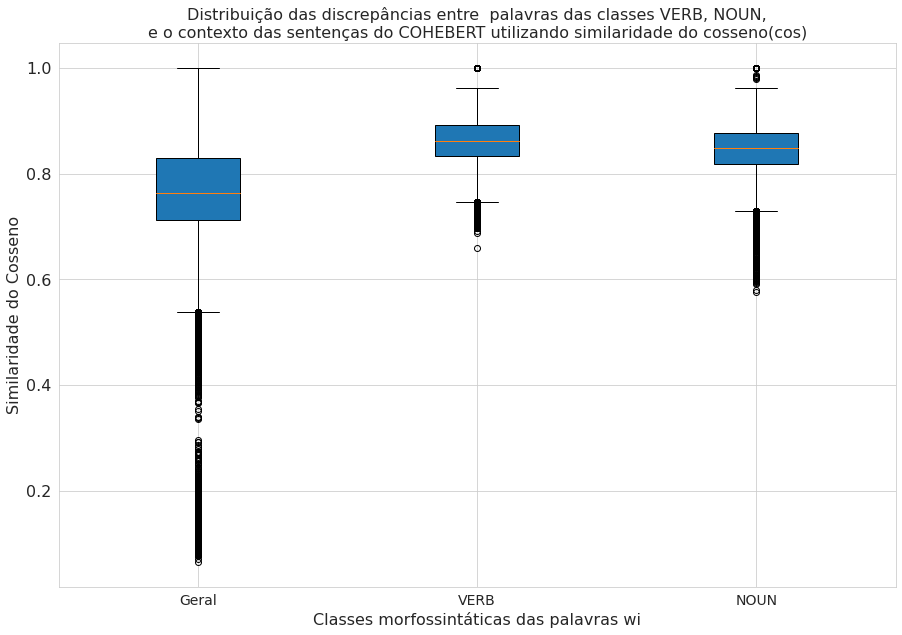

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count        339469.000000         28822.000000         67194.000000
mean             25.640929            21.356176            21.265510
std               5.079661             5.214789             3.583899
min               0.000000             0.000000             0.000000
25%              22.527838            19.035048            19.079908
50%              25.897774            21.779977            21.190631
75%              28.674824            24.332668            23.377262
max              56.015049            39.285553            41.115711

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


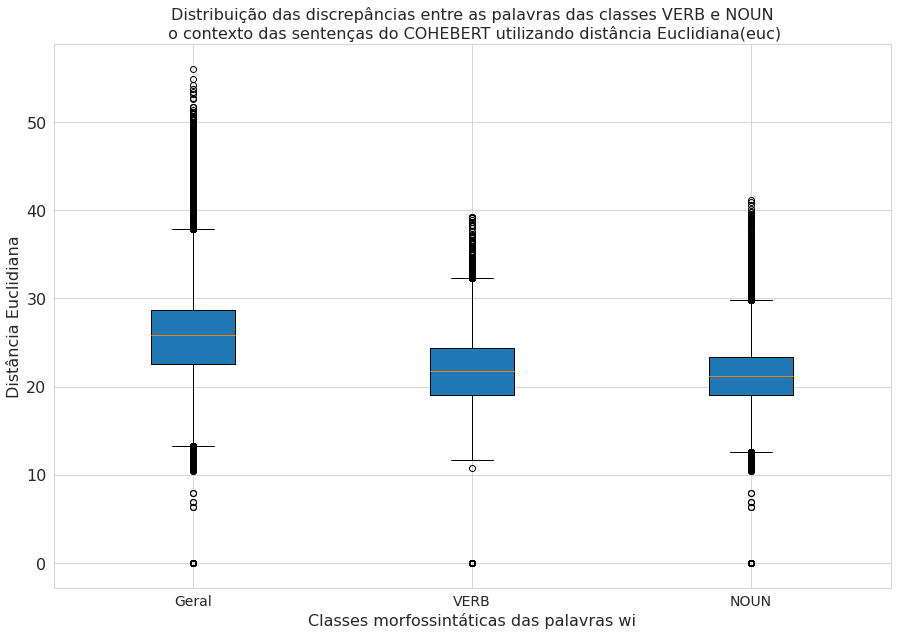

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count        339469.000000         28822.000000         67194.000000
mean           1224.678101          1016.854813          1002.584570
std             235.616019           242.659261           162.707964
min               0.000000             0.000000             0.000000
25%            1075.542725           911.917786           903.306549
50%            1247.447388          1041.781555          1000.295410
75%            1377.537842          1158.999359          1099.508942
max            2418.588623          1729.329346          1794.353516

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


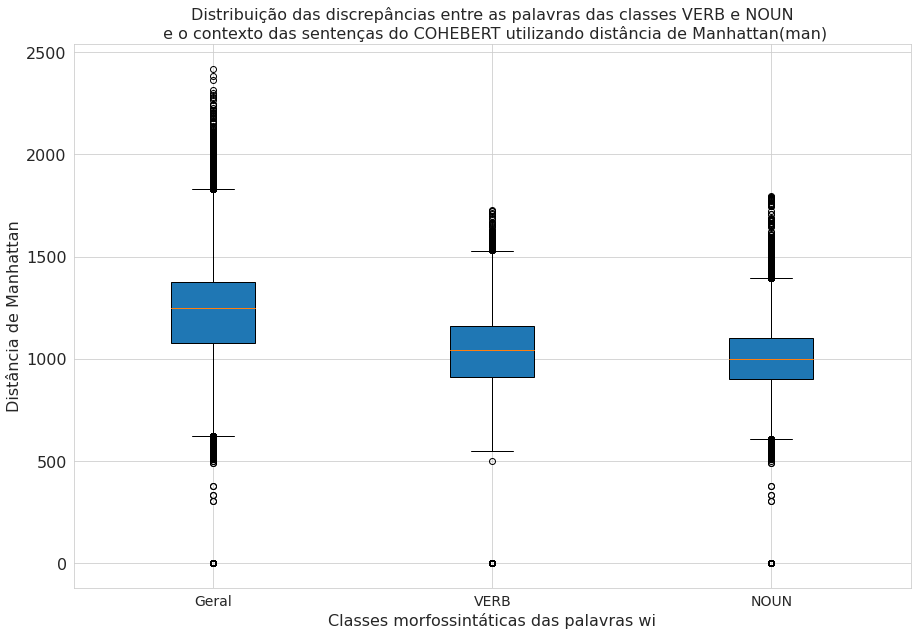

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:04:50 (h:mm:ss)
